# PySINDy Being Applied to Beam Physics

Application to undercovering the underlying terms driving the the transvers coordinate centriods behavior $x_c(z)$ and $y_c(z)$ 

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import nolds
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
import math
import time
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from pysindy.utils import linear_damped_SHO
from pysindy.utils import cubic_damped_SHO
from pysindy.utils import linear_3D
from pysindy.utils import hopf
from pysindy.utils import lorenz
from scipy.ndimage.filters import uniform_filter1d
from scipy.signal import argrelextrema
from scipy import integrate
from scipy.stats import moment

import itertools
marker = itertools.cycle((',', '+', '.', 'o', '*')) 

import pysindy as ps

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(1000)  # Seed for reproducibility

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

# for plotting
csfont = {'fontname':"Times New Roman"}
plt.rcParams['font.family'] = "Times New Roman"
plt.rcParams['text.usetex'] = True

# colors for plotting things
colors =  plt.rcParams['axes.prop_cycle'].by_key()['color']
# plotting stuff
title_size = 28
label_size = 24
leg_size   = 16
tick_size = 16
GR = 1.618

COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

/var/folders/33/jztbzbp12xq9cj11tzlsrdm80000gn/T/ipykernel_21364/1560423313.py:16: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


dz = 5.00e-03


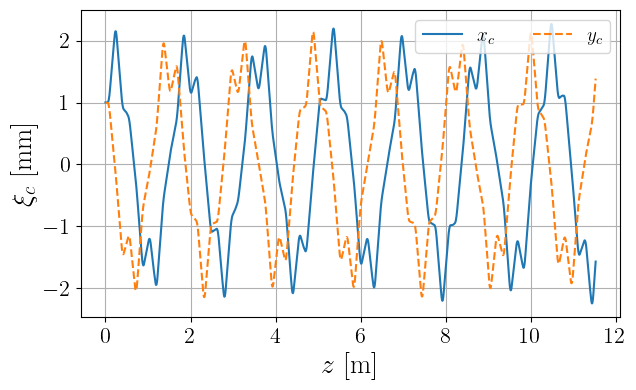

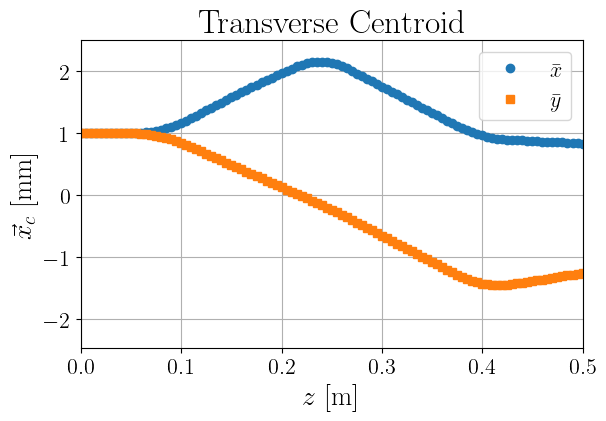

In [2]:
pos = np.loadtxt('pos.txt')
dz = pos[1,0] - pos[0,0]
z = pos[:,0]
X = pos[:,1:]

print("dz = %.2e"%(dz))

plt.figure(figsize=(GR*4,4))
plt.plot(z,X[:,0]*1000,'-',color=colors[0],label=r'$x_c$',ms=2)
plt.plot(z,X[:,1]*1000,'--',color=colors[1],label=r'$y_c$',ms=2)
plt.grid(True)
plt.xlabel(r'$z$ [m]',fontsize=20)
plt.ylabel(r'$\xi_c$ [mm]',fontsize=20)
#plt.title(r'Warp Simulation Data',fontsize=24)
plt.legend(loc='best',fontsize=14,ncol=2)
plt.tick_params(axis='both',labelsize=16)
plt.tight_layout()
plt.savefig("./figures/xc_yc_ofz_plot.pdf",dpi=200,transparent=True)
plt.show()

plt.figure(figsize=(GR*4,4))
plt.plot(z,X[:,0]*1000,'o',color=colors[0],label=r'$\bar{x}$')
plt.plot(z,X[:,1]*1000,'s',color=colors[1],label=r'$\bar{y}$')
plt.grid(True)
plt.xlabel(r'$z$ [m]',fontsize=20)
plt.ylabel(r'$\vec{x}_c$ [mm]',fontsize=20)
plt.title(r'Transverse Centroid',fontsize=24)
plt.legend(loc='best',fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.xlim([0,0.5])
plt.show()

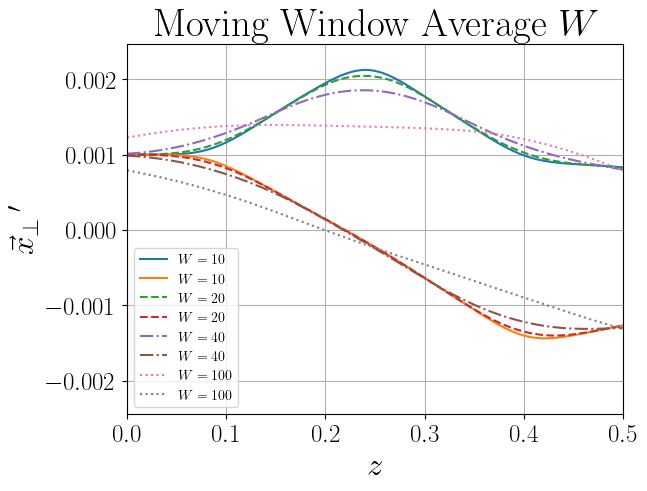

In [3]:
# massage the data with a moving window average so that the resultant derivatives are a little smoother
plt.figure()
# plt.plot(uniform_filter1d(X[:,0],size=20))
# plt.plot(uniform_filter1d(X[:,1],size=20))
plt.plot(z,uniform_filter1d(X,size=10,axis=0,mode='nearest'),'-',label=r"$W=10$")
plt.plot(z,uniform_filter1d(X,size=20,axis=0,mode='nearest'),'--',label=r"$W=20$")
plt.plot(z,uniform_filter1d(X,size=40,axis=0,mode='nearest'),'-.',label=r"$W=40$")
plt.plot(z,uniform_filter1d(X,size=100,axis=0,mode='nearest'),':',label=r"$W=100$")
plt.xlabel(r"$z$",fontsize=label_size)
plt.ylabel(r"$\vec{x}_{\perp} \, '$",fontsize=label_size)
plt.title(r"Moving Window Average $W$",fontsize=title_size)
plt.legend(loc='best')
plt.tick_params(axis='both',labelsize=18)
plt.grid(True)
plt.xlim([0,0.5])
plt.show()

Overall the results from plotting with the box car filter (basically multiplying the signal with a boxcars spectrium in frequency space, so neat)

## Data Analysis

### Autocorrelation

Rememeber that the autocorrelation goes to plus and minus the full time series, so only plot the last half of the computed data set for the correlation in Question.

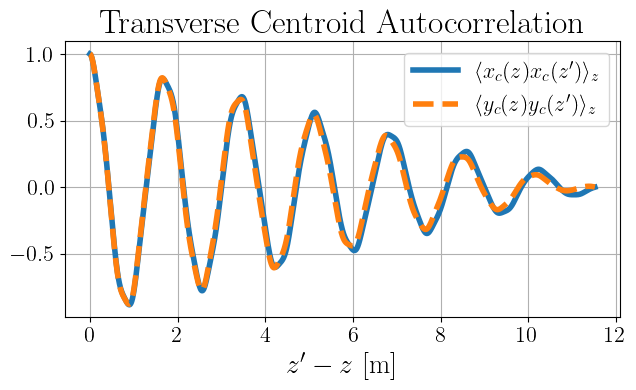

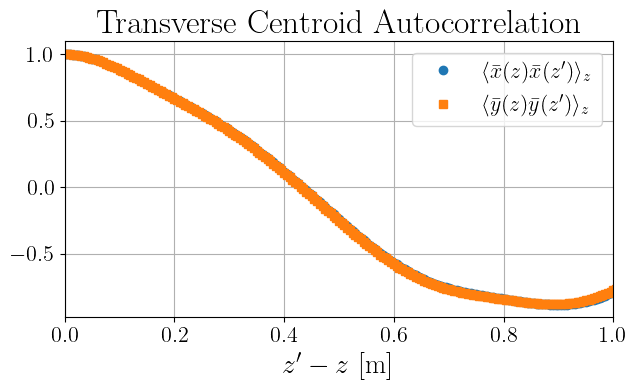

In [4]:
X_W20 = uniform_filter1d(X,size=10,axis=0,mode='nearest')# set X equal to the window averaged amount

corr_x = np.correlate(X[:,0], X[:,0],mode='full')
corr_x = corr_x/(np.sum((X[:,0])**2))

corr_y = np.correlate(X[:,1], X[:,1],mode='full')
corr_y = corr_y/(np.sum((X[:,1])**2))

plt.figure(figsize=(GR*4,4))
# zlimit = 3.0
plt.plot(z,corr_x[int(len(corr_x)/2):],'-',linewidth=4.0,color=colors[0],label=r"$\langle x_c(z) x_c(z') \rangle_z$")
plt.plot(z,corr_y[int(len(corr_y)/2):],'--',linewidth=4.0,color=colors[1],label=r"$\langle y_c(z) y_c(z') \rangle_z$")
plt.grid(True)
plt.xlabel(r"$z'-z$ [m]",fontsize=20)
plt.title(r'Transverse Centroid Autocorrelation',fontsize=24)
plt.legend(loc='best',fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.tight_layout()
plt.savefig("./figures/Turn1_Data_Auto.png",dpi=200,transparent=True)
plt.show()

plt.figure(figsize=(GR*4,4))
# zlimit = 3.0
plt.plot(z,corr_x[int(len(corr_x)/2):],'o',color=colors[0],label=r"$\langle \bar{x}(z) \bar{x}(z') \rangle_z$")
plt.plot(z,corr_y[int(len(corr_y)/2):],'s',color=colors[1],label=r"$\langle \bar{y}(z) \bar{y}(z') \rangle_z$")
plt.grid(True)
plt.xlabel(r"$z'-z$ [m]",fontsize=20)
plt.title(r'Transverse Centroid Autocorrelation',fontsize=24)
plt.legend(loc='best',fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.xlim([0,1.0])
plt.tight_layout()
plt.savefig("./figures/Turn1_Data_Auto_Zoom.pdf",dpi=1000,transparent=True)
plt.show()

### Fourier Transform and Power Spectra $S_{\vec{x}_{\perp} \vec{x}_{\perp}}$

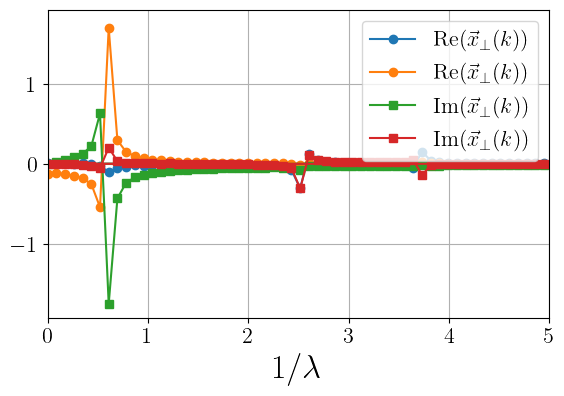

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


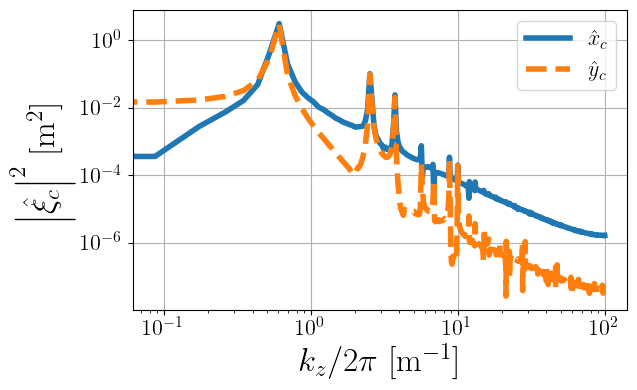

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


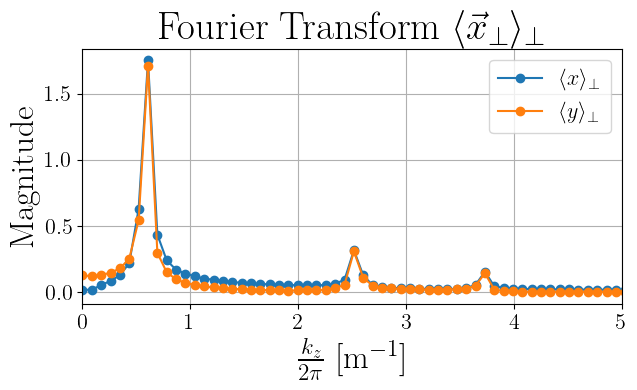

In [5]:
wn_z = np.fft.fftfreq(z.shape[-1],d=dz); # wave number for z
dat_f = np.fft.fft(X,axis=0);

plt.figure(figsize=(4*GR,4))
plt.plot(wn_z, dat_f.real,'-o',label=r"Re$(\vec{x}_{\perp}(k))$")
plt.plot(wn_z, dat_f.imag,'-s',label=r"Im$(\vec{x}_{\perp}(k))$")
plt.xlabel(r"$1/\lambda$",fontsize=label_size)
plt.legend(loc="best",fontsize=leg_size)
plt.xlim([0.0,5.0])
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.grid(True)
plt.show()

plt.figure(figsize=(4*GR,4))
plt.plot(wn_z[:int(dat_f.shape[0]/2)], np.abs(dat_f[:int(dat_f.shape[0]/2),0])**2,linewidth=4.0)
plt.plot(wn_z[:int(dat_f.shape[0]/2)], np.abs(dat_f[:int(dat_f.shape[0]/2),1])**2,'--',linewidth=4.0)
plt.xlabel(r"$k_z/2\pi$ [m$^{-1}$]",fontsize=label_size)
plt.ylabel(r"$\left| \hat{\xi}_c \right|^2$ [m$^2$]",fontsize=label_size)
# plt.title(r"Fourier Transform $\vec{x}_c$",fontsize=title_size)
plt.legend(loc="best",fontsize=leg_size)
# plt.xlim([0,20.0])
plt.xscale("log")
plt.yscale("log")
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.grid(True)
plt.legend([r"$\hat{x}_c$",r"$\hat{y}_c$"],loc="best",fontsize=leg_size)
plt.tight_layout()
plt.savefig("./figures/Turn1_Data_Fourier_Log.pdf",dpi=200,transparent=True)
plt.show()

plt.figure(figsize=(4*GR,4))
plt.plot(wn_z[:int(dat_f.shape[0]/2)], np.abs(dat_f[:int(dat_f.shape[0]/2)]),'-o')
plt.xlabel(r"$\frac{k_z}{2\pi}$ [m$^{-1}$]",fontsize=label_size)
plt.ylabel(r"Magnitude",fontsize=label_size)
plt.title(r"Fourier Transform $\langle \vec{x}_{\perp} \rangle_{\perp}$",fontsize=title_size)
plt.legend(loc="best",fontsize=leg_size)
plt.xlim([0,5.0])
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.grid(True)
plt.legend([r"$\langle x \rangle_{\perp}$",r"$\langle y \rangle_{\perp}$"],loc="best",fontsize=leg_size)
plt.tight_layout()
plt.savefig("./figures/Turn1_Data_Fourier_Linear.pdf",dpi=1000,transparent=True)
plt.show()

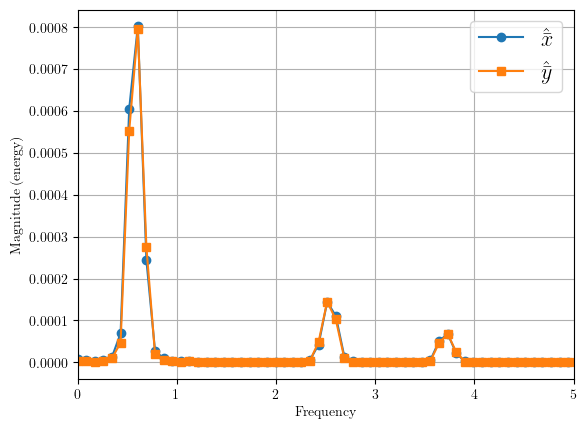

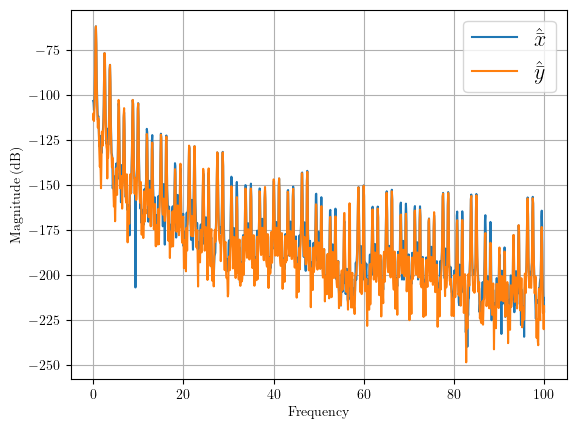

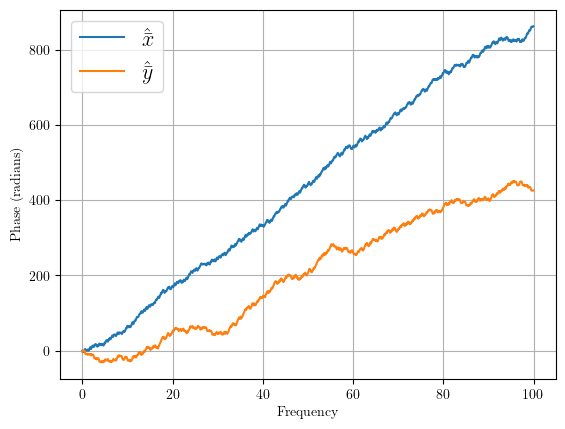

In [6]:
# plot magnitude spectrum
plt.figure()
plt.grid(True)
plt.magnitude_spectrum(X[:,0], Fs=1.0/dz, color=colors[0],marker="o",label=r"$\hat{\bar{x}}$")
plt.magnitude_spectrum(X[:,1], Fs=1.0/dz, color=colors[1],marker="s",label=r"$\hat{\bar{y}}$")
plt.legend(loc='best',fontsize=leg_size)
plt.xlim([0,5])

plt.figure()
plt.grid(True)
plt.magnitude_spectrum(X[:,0], Fs=1.0/dz, color=colors[0],scale='dB',label=r"$\hat{\bar{x}}$")
plt.magnitude_spectrum(X[:,1], Fs=1.0/dz, color=colors[1],scale='dB',label=r"$\hat{\bar{y}}$")
plt.legend(loc='best',fontsize=leg_size)


plt.figure()
plt.grid(True)
plt.phase_spectrum(X[:,0], Fs=1.0/dz, color=colors[0],label=r"$\hat{\bar{x}}$")
plt.phase_spectrum(X[:,1], Fs=1.0/dz, color=colors[1],label=r"$\hat{\bar{y}}$")
plt.legend(loc='best',fontsize=leg_size)
plt.show()

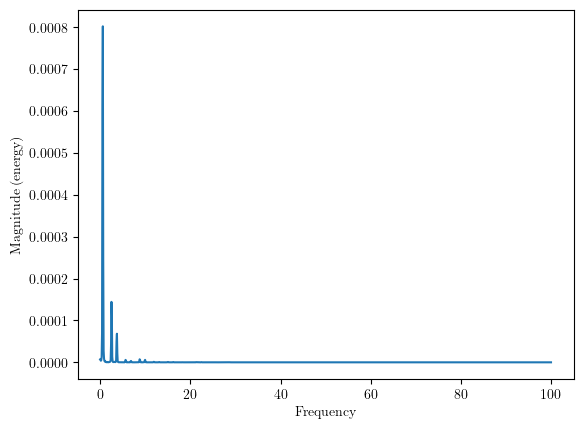

In [7]:
fobj = plt.magnitude_spectrum(X[:,0], Fs=1.0/dz)
freq_amp = fobj[0]

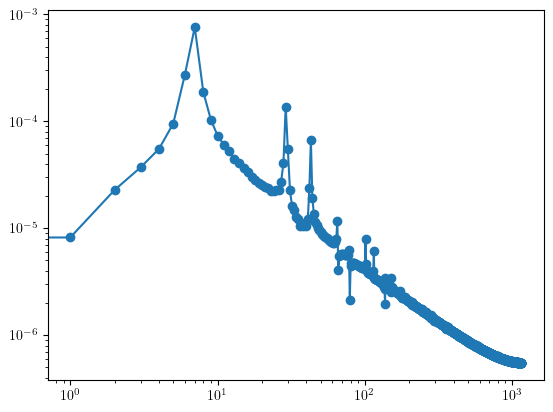

[0.         0.0867679  0.17353579 0.26030369 0.34707158 0.43383948
 0.52060738 0.60737527 0.69414317 0.78091106]
[0.01583907 0.01890265 0.05259993 0.08547753 0.12731208 0.21932751
 0.62998173 1.75176733 0.4345025  0.23940938]
[48.01041554 48.01041554 48.01041554 48.01041554 48.01041554 48.01041554
 48.01041554 48.01041554 48.01041554 48.01041554]


In [8]:
plt.plot(np.abs(dat_f[:int(dat_f.shape[0]/2),0])/2305,'-o')
plt.xscale("log")
plt.yscale("log")
plt.show()

print(wn_z[:int(dat_f.shape[0]/2)][:10])
print(np.abs(dat_f[:int(dat_f.shape[0]/2),0])[0:10])

mmaXcFour = [.00032990904686689, 0.0003937197512819, 0.0010955941088774,0.0017803956476769, 0.0026517596824060, 0.0045683319134786, 0.0131217719932751, 0.0364872352755238, 0.0090501715353988,0.0049866134722693]
print(np.abs(dat_f[:int(dat_f.shape[0]/2),0])[0:10] / mmaXcFour)

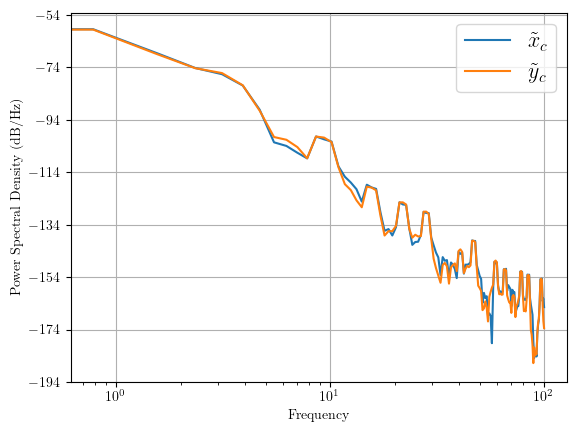

In [9]:
# plot magnitude spectrum
plt.figure()
plt.grid(True)
plt.psd(X[:,0], Fs=1.0/dz, color=colors[0],label=r"$\tilde{x}_c$")
plt.psd(X[:,1], Fs=1.0/dz, color=colors[1],label=r"$\tilde{y}_c$")
plt.legend(loc='best',fontsize=leg_size)
plt.xscale("log")
# plt.yscale("log")
# plt.xlim([0,0.0005])
plt.show()

(0.0, 20.0)

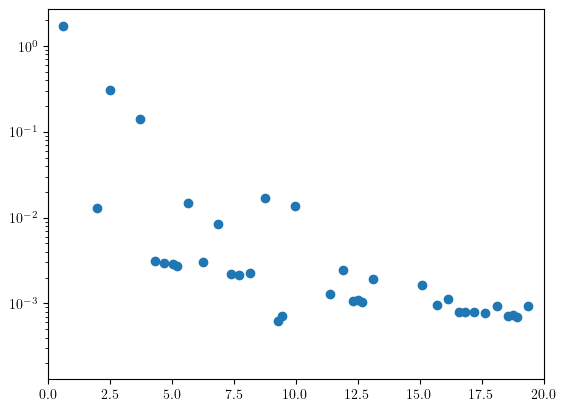

In [10]:
# get the peak frequencies
# wn_z, np.abs(dat_f)
# slope = x[1:] - x[:-1]
# slope = np.abs(dat_f)[1:,1] - np.abs(dat_f)[:-1,1]
peaks = argrelextrema(np.abs(dat_f)[:int(dat_f.shape[0]/2),1], np.greater)
fplot = np.abs(dat_f)[peaks,1].flatten()
plt.figure()
plt.plot(wn_z[peaks],fplot,'o')
plt.yscale("log")
plt.xlim([0,20])

Now taking only the maximum $\tilde{x}_{c}(k)$ values above a threshold

In [11]:
threshold = 0.00001
x_tilde_amp = fobj[0][peaks][fobj[0][peaks]>threshold] # amplitude of the analyzed frequency
k_val_z = fobj[1][peaks][fobj[0][peaks]>threshold] # value of the frequency/wavenumber
print("Wavenumber k_i: ",k_val_z)
print("Wavenumber k_i: ",k_val_z/(2*np.pi))
print("Length L_i: ",1.0/k_val_z)

Wavenumber k_i:  [0.60737527 2.51626898 3.73101952]
Wavenumber k_i:  [0.09666678 0.40047665 0.5938102 ]
Length L_i:  [1.64642857 0.39741379 0.26802326]


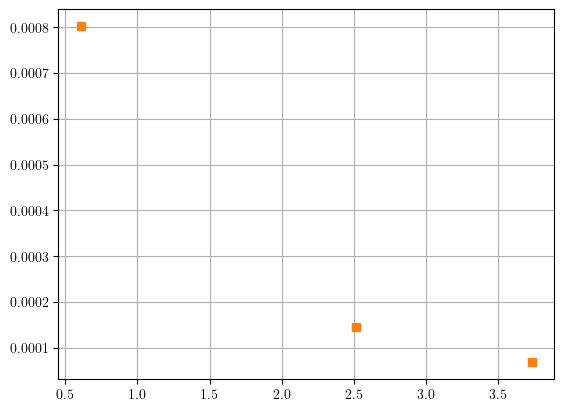

In [12]:
plt.figure()
plt.plot(k_val_z,x_tilde_amp,'s',color=colors[1])
plt.grid(True)
plt.show()

Plotting everything together and seeing what the result is.

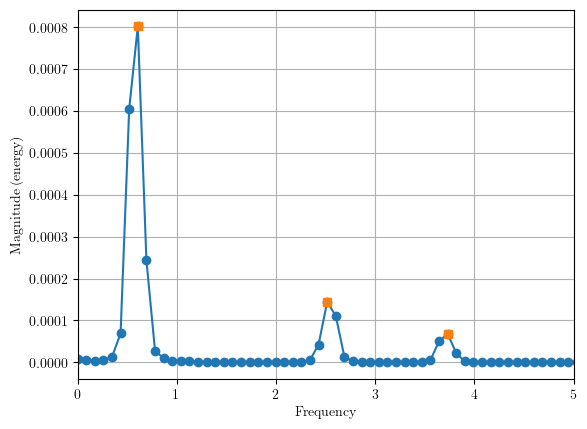

In [13]:
plt.figure()
plt.grid(True)
plt.magnitude_spectrum(X[:,0], Fs=1.0/dz, color=colors[0],label=r"$\tilde{x}_c$",marker="o")
plt.plot(k_val_z,x_tilde_amp,'s',color=colors[1])
plt.xlim([0,5.0])
plt.show()

In [14]:
k_val_z[1:]/k_val_z[0] # ratio of the frequency ratio to the first base harmonic. 
# Not really harmonics going on here 

array([4.14285714, 6.14285714])

### Plotting Data in the 2d projections of trace space for $(x_c,x_c',y_c,y_c')$ as functions of z

In [15]:
# plot plot
z = pos[:,0]
x_c = pos[:,1]
y_c = pos[:,2]
print(z.shape)
print(x_c.shape)

(2305,)
(2305,)


In [16]:
from pysindy.differentiation import FiniteDifference
from pysindy.differentiation import SmoothedFiniteDifference
fd = FiniteDifference(order=2)

Now get the moving averages and the derivative

In [17]:
x_c10 = uniform_filter1d(x_c,size=10,axis=0,mode='nearest')
y_c10 = uniform_filter1d(y_c,size=10,axis=0,mode='nearest')

x_c10p = fd._differentiate(x_c10, z)
y_c10p = fd._differentiate(y_c10, z)

XY = np.array([x_c10,y_c10,x_c10p,y_c10p]).T
XY.shape

labelstr = [r"$\langle x \rangle_{\perp}$ [m]",r"$\langle y \rangle_{\perp}$ [m]",r"$\langle x' \rangle_{\perp}$ [1]",r"$\langle y' \rangle_{\perp}$ [1]"]

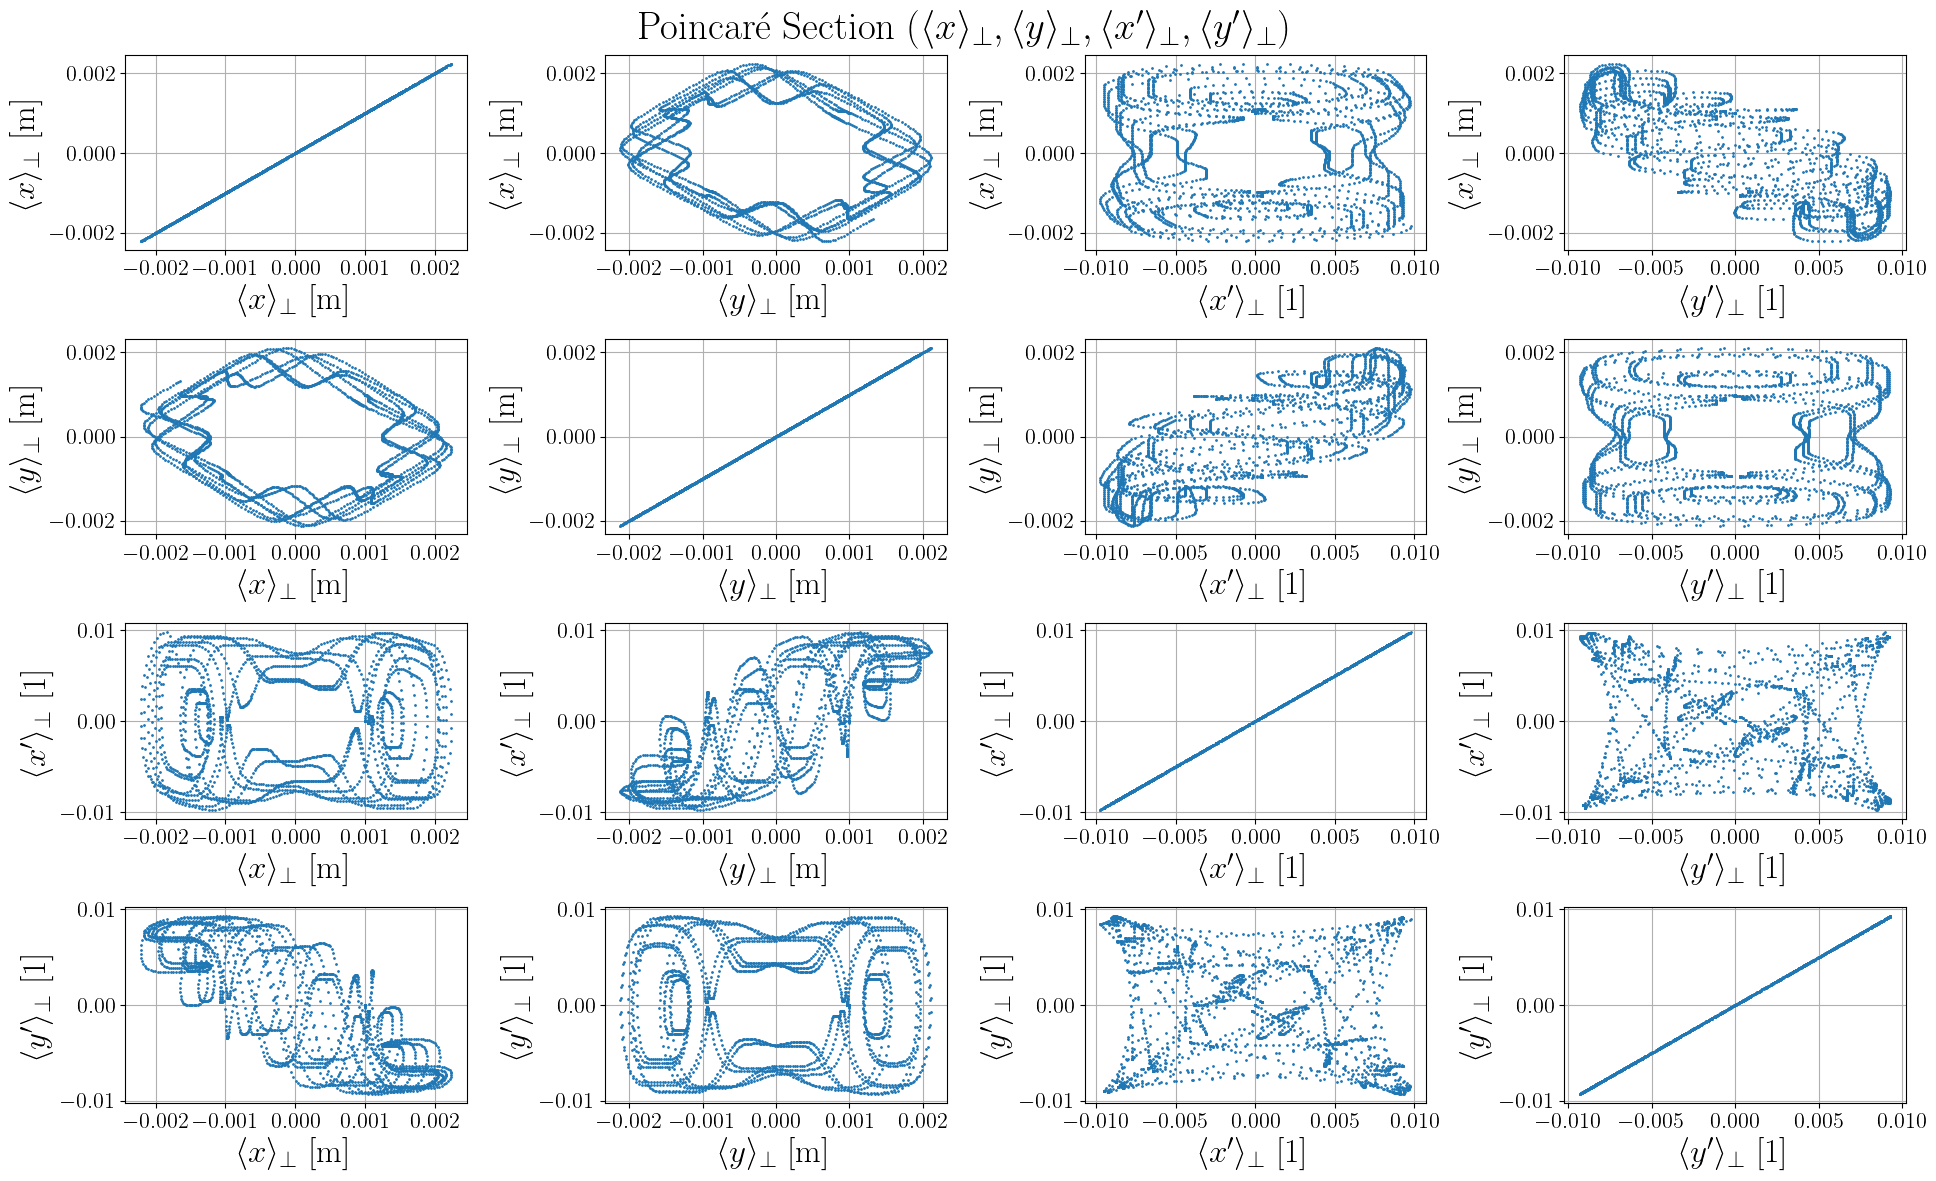

In [18]:
dim = 4
fig, axs = plt.subplots(dim,dim,figsize=(12*GR,12))

for i in range(dim):
    for j in range(dim):
        
        axs[i,j].plot(XY[:,j],XY[:,i],'o',markersize=1.0)
        axs[i,j].set_xlabel(labelstr[j],fontsize=label_size)
        axs[i,j].set_ylabel(labelstr[i],fontsize=label_size)
        axs[i,j].tick_params(axis = 'both', labelsize=tick_size)
        axs[i,j].grid(True)

plt.suptitle(r"Poincar\'e Section $\left( \langle x \rangle_{\perp},\langle y \rangle_{\perp},\langle x' \rangle_{\perp},\langle y' \rangle_{\perp} \right)$",fontsize=title_size)
plt.tight_layout()
plt.show()

# Not Poincare section of the beam particles, just Poincare section of the centriod/displacement of the beam
# as it goes through the pipe.

## Correlation Dimension

from the nolds python module https://nolds.readthedocs.io/en/latest/nolds.html#hurst-exponent

In [19]:
# what is it's value?
x_c10 = uniform_filter1d(x_c,size=10,axis=0,mode='nearest') # get data
y_c10 = uniform_filter1d(y_c,size=10,axis=0,mode='nearest')
 
XY = np.array([x_c10,y_c10]).T

In [20]:
a = nolds.corr_dim(XY,10,debug_data=True)

rlen = a[1][0].shape[0]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [21]:
Dmax = 20 # max dimension
Dvec = np.linspace(1,Dmax,Dmax)
rmat = np.zeros((Dmax,rlen))
Cmat = np.zeros((Dmax,rlen))
nu_list = []

for D in range(Dmax):
    print(D+1)
    res = nolds.corr_dim(XY,D+1,debug_data=True)
    
    rmat[D,:] = res[1][0]
    Cmat[D,:] = res[1][1]
    
    nu = res[0]
    nu_list.append(nu)
    
print(nu_list)
nu_list = np.array(nu_list)
nu_list_diff = nu_list[1:] - nu_list[:-1]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
[0.9523469939227236, 0.9704510470555909, 1.031475726329476, 1.1926737706522517, 1.3684041426857425, 1.4848920201926552, 1.5413312675794058, 1.5553841879644195, 1.5536743250119323, 1.5527423186289162, 1.5572936423934263, 1.5670650532626789, 1.5803217156249758, 1.5970766119800683, 1.614831012855277, 1.6303312240720205, 1.643633948637189, 1.6535348932215526, 1.6596904675922297, 1.662046630508184]


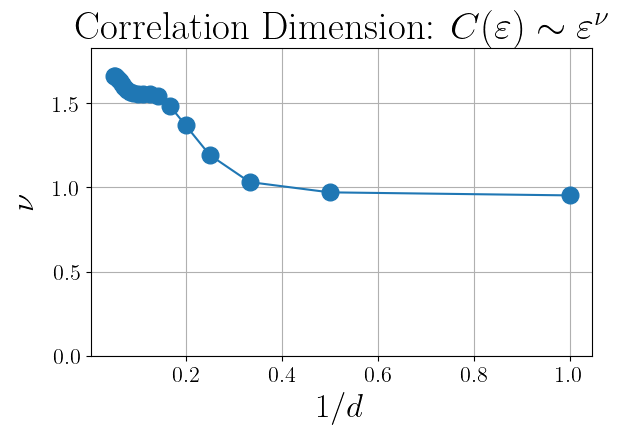

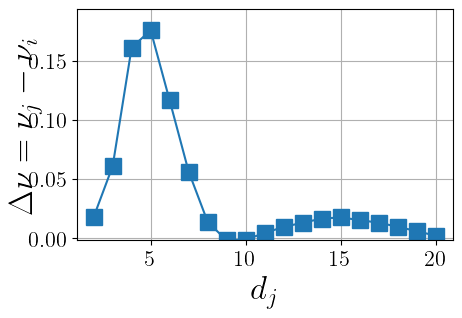

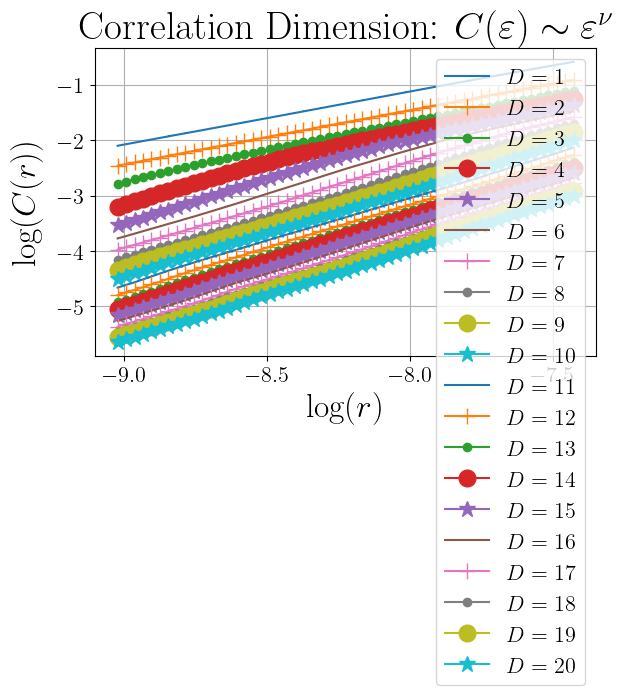

In [22]:
plt.figure(figsize=(GR*4,4))
plt.plot(1.0/Dvec,nu_list,'o-',ms=12)
plt.xlabel(r'$1/d$',fontsize=label_size)
plt.ylabel(r'$\nu$',fontsize=label_size,labelpad=10)
plt.title(r'Correlation Dimension: $C(\varepsilon)\sim\varepsilon^{\nu}$',fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.ylim([0,nu_list[-1]*1.1])
plt.grid(True)

plt.figure(figsize=(GR*3,3))
plt.plot(Dvec[1:],nu_list_diff,'s-',ms=12)
plt.xlabel(r'$d_j$',fontsize=label_size)
plt.ylabel(r'$\Delta\nu = \nu_j - \nu_i$',fontsize=label_size,labelpad=-10)
# plt.title(r'Correlation Dimension Difference',fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.ylim([min(nu_list_diff),1.1*max(nu_list_diff)])
plt.grid(True)

plt.figure(figsize=(GR*4,4))
for D in range(Dmax):
    plt.plot(rmat[D,:],Cmat[D,:],ms=12, marker = next(marker),label=r"$D = {}$".format(D+1))
    
plt.xlabel(r'log$(r)$',fontsize=label_size)
plt.ylabel(r'log$(C(r))$',fontsize=label_size,labelpad=10)
plt.title(r'Correlation Dimension: $C(\varepsilon)\sim\varepsilon^{\nu}$',fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc="best",fontsize=leg_size)
plt.grid(True)

## First Stab with Polynomial Data

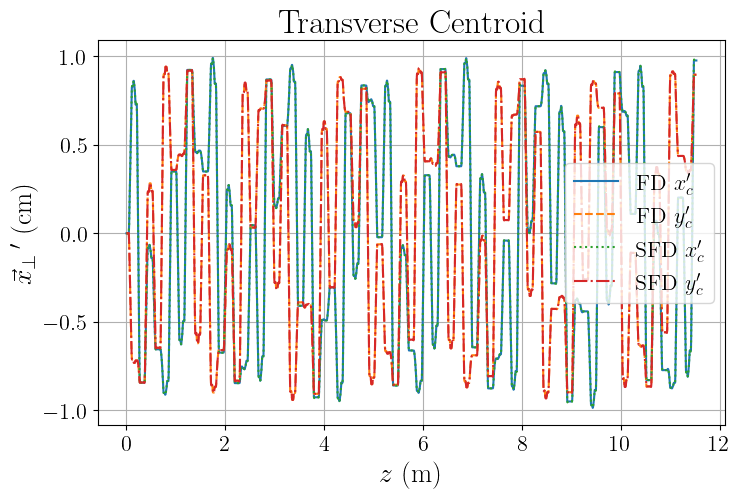

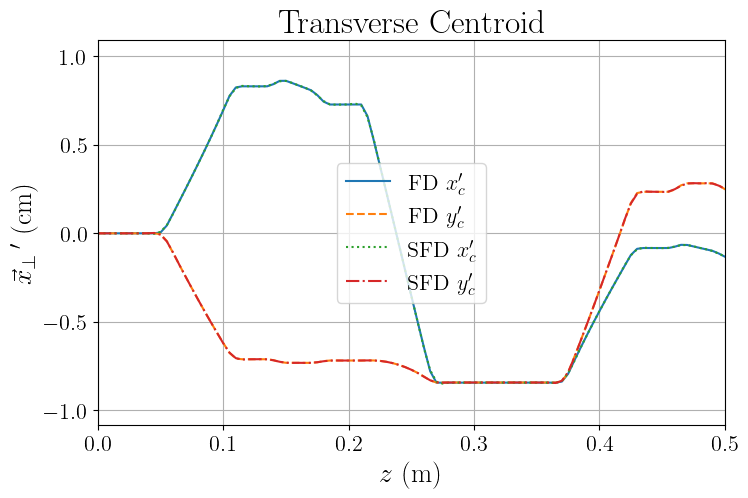

In [23]:
# plot the differentiation
from pysindy.differentiation import FiniteDifference
from pysindy.differentiation import SmoothedFiniteDifference
fd = FiniteDifference(order=2)
Xpfd = fd._differentiate(X, z)

sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
Xpsfd = sfd._differentiate(X, z)

plt.figure(figsize=(GR*5,5))

plt.plot(z,Xpfd[:,0]*100,color=colors[0],label=r"FD $x_c'$")
plt.plot(z,Xpfd[:,1]*100,'--',color=colors[1],label=r"FD $y_c'$")

plt.plot(z,Xpsfd[:,0]*100,':',color=colors[2],label=r"SFD $x_c'$")
plt.plot(z,Xpsfd[:,1]*100,'-.',color=colors[3],label=r"SFD $y_c'$")
plt.grid(True)
plt.xlabel(r'$z$ (m)',fontsize=20)
plt.ylabel(r"$\vec{x}_{\perp}\,'$ (cm)",fontsize=20)
plt.title(r'Transverse Centroid',fontsize=24)
plt.legend(loc='best',fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.show()

plt.figure(figsize=(GR*5,5))

plt.plot(z,Xpfd[:,0]*100,color=colors[0],label=r"FD $x_c'$")
plt.plot(z,Xpfd[:,1]*100,'--',color=colors[1],label=r"FD $y_c'$")

plt.plot(z,Xpsfd[:,0]*100,':',color=colors[2],label=r"SFD $x_c'$")
plt.plot(z,Xpsfd[:,1]*100,'-.',color=colors[3],label=r"SFD $y_c'$")
plt.grid(True)
plt.xlabel(r'$z$ (m)',fontsize=20)
plt.ylabel(r"$\vec{x}_{\perp}\,'$ (cm)",fontsize=20)
plt.title(r'Transverse Centroid',fontsize=24)
plt.legend(loc='best',fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.xlim([0,0.5])
plt.show()

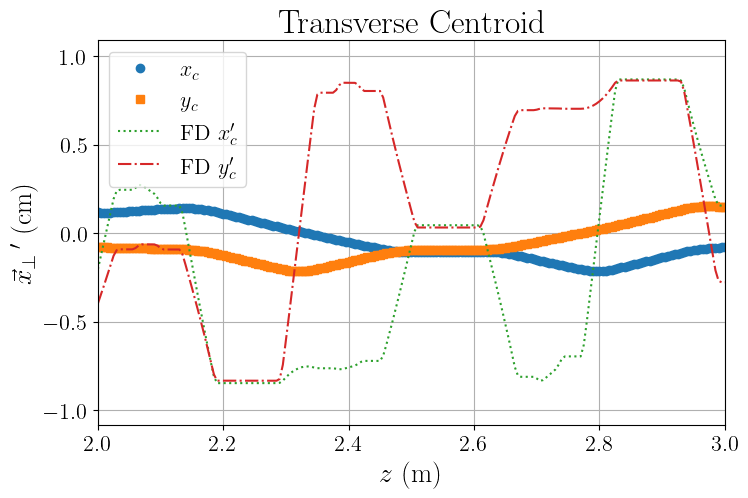

In [24]:
left = 2.0
right = 3.0
# comparing the differentitation to the data
plt.figure(figsize=(GR*5,5))

plt.plot(z,X[:,0]*100,'o',color=colors[0],label=r'$x_c$')
plt.plot(z,X[:,1]*100,'s',color=colors[1],label=r'$y_c$')

plt.plot(z,Xpfd[:,0]*100,':',color=colors[2],label=r"FD $x_c'$")
plt.plot(z,Xpfd[:,1]*100,'-.',color=colors[3],label=r"FD $y_c'$")
plt.grid(True)
plt.xlabel(r'$z$ (m)',fontsize=20)
plt.ylabel(r"$\vec{x}_{\perp}\,'$ (cm)",fontsize=20)
plt.title(r'Transverse Centroid',fontsize=24)
plt.legend(loc='best',fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.xlim([left,right])
plt.show()

In [25]:
# differentiate the signal 
differentiation_method = ps.FiniteDifference(order=2)

# feature library
# just try Polynomial for fun for now
feature_library = ps.PolynomialLibrary(degree=5)

optimizer = ps.STLSQ(threshold=0.2)
# optimizer for the PySINDy model

In [26]:
# create the PySINDy object of interest
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x_c", "y_c"]
)

In [27]:
model.fit(X, t=z)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=5), feature_names=['x_c', 'y_c'],
      optimizer=STLSQ(threshold=0.2))

In [28]:
model.print()

(x_c)' = 3.933 y_c
(y_c)' = -3.677 x_c


## Massage the Data of Interest

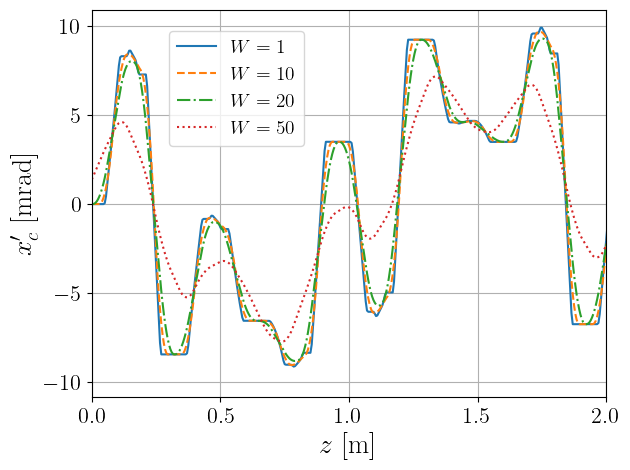

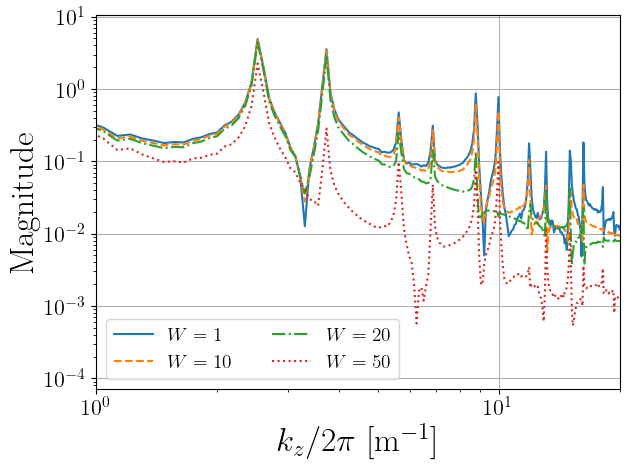

In [29]:
# plot the differentiation
Xpfd5 = fd._differentiate(uniform_filter1d(X,size=5,axis=0,mode='nearest'), z)
Xpfd10 = fd._differentiate(uniform_filter1d(X,size=10,axis=0,mode='nearest'), z)
Xpfd20 = fd._differentiate(uniform_filter1d(X,size=20,axis=0,mode='nearest'), z)
Xpfd50 = fd._differentiate(uniform_filter1d(X,size=50,axis=0,mode='nearest'), z)
Xpfd100 = fd._differentiate(uniform_filter1d(X,size=100,axis=0,mode='nearest'), z)

np.savetxt("fd1.txt",Xpfd,delimiter=',')
np.savetxt("fd10.txt",Xpfd10,delimiter=',')
np.savetxt("fd20.txt",Xpfd20,delimiter=',')
np.savetxt("fd50.txt",Xpfd50,delimiter=',')
# sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
# Xpsfd = sfd._differentiate(X, z)

plt.figure()

plt.plot(z,Xpfd[:,0]*1000,linestyle='-',label=r"$W=1$")
# plt.plot(z,Xpfd5[:,0]*100,color=colors[1],label=r"$W=5$")
plt.plot(z,Xpfd10[:,0]*1000,linestyle='--',label=r"$W=10$")
plt.plot(z,Xpfd20[:,0]*1000,linestyle='-.',label=r"$W=20$")
plt.plot(z,Xpfd50[:,0]*1000,linestyle=':',label=r"$W=50$")
# plt.plot(z,Xpfd100[:,0]*100,color=colors[5],label=r"$W=100$")

# plt.plot(z,Xpfd[:,1]*100,'--',color=colors[6],label=r"$W=1$ $y_c'$")
# plt.plot(z,Xpfd5[:,1]*100,'--',color=colors[7],label=r"$W=5$ $y_c'$")
# plt.plot(z,Xpfd10[:,1]*100,'--',color=colors[8],label=r"$W=10$ $y_c'$")
# plt.plot(z,Xpfd20[:,1]*100,'--',color=colors[9],label=r"$W=20$ $y_c'$")
# plt.plot(z,Xpfd50[:,1]*100,'--',color=colors[0],label=r"$W=50$ $y_c'$")
# plt.plot(z,Xpfd100[:,1]*100,'--',color=colors[1],label=r"$W=100$ $y_c'$")

plt.grid(True)
plt.xlabel(r'$z$ [m]',fontsize=20)
plt.ylabel(r"$x_c'$ [mrad]",fontsize=20)
# plt.title(r'Transverse Centroid Derivative',fontsize=24)
plt.legend(loc=(0.15,0.65),ncol=1,fontsize=14) 
plt.tick_params(axis='both',labelsize=16)
plt.xlim([0,2.0])
plt.tight_layout()
plt.savefig("./figures/Turn1_Smoothing_FD_Comparison.pdf",dpi=200,transparent=True)
plt.show()

# plot the fourier transform of the signal as a function of the smoothing. Show how the statistics are changed by the smoothing

wn_z = np.fft.fftfreq(z.shape[-1],d=dz); # wave number for z;
dat_f = np.fft.fft(Xpfd,axis=0);

plt.figure()
dat_f = np.fft.fft(Xpfd,axis=0);
plt.plot(wn_z[:int(dat_f.shape[0]/2)], np.abs(dat_f[:int(dat_f.shape[0]/2),0]),linestyle='-',label=r'$W=1$')
# dat_f = np.fft.fft(Xpfd5,axis=0);
# plt.plot(wn_z[:int(dat_f.shape[0]/2)], np.abs(dat_f[:int(dat_f.shape[0]/2),0]),linestyle='--',label=r'$W=5$')
dat_f = np.fft.fft(Xpfd10,axis=0);
plt.plot(wn_z[:int(dat_f.shape[0]/2)], np.abs(dat_f[:int(dat_f.shape[0]/2),0]),linestyle='--',label=r'$W=10$')
dat_f = np.fft.fft(Xpfd20,axis=0);
plt.plot(wn_z[:int(dat_f.shape[0]/2)], np.abs(dat_f[:int(dat_f.shape[0]/2),0]),linestyle='-.',label=r'$W=20$')
dat_f = np.fft.fft(Xpfd50,axis=0);
plt.plot(wn_z[:int(dat_f.shape[0]/2)], np.abs(dat_f[:int(dat_f.shape[0]/2),0]),linestyle=':',label=r'$W=50$')
# dat_f = np.fft.fft(Xpfd100,axis=0);
# plt.plot(wn_z[:int(dat_f.shape[0]/2)], np.abs(dat_f[:int(dat_f.shape[0]/2),0]),linestyle='--',label=r'$W=100$')
# plt.plot(wn_z[:int(dat_f.shape[0]/2)], np.abs(dat_f[:int(dat_f.shape[0]/2),1]),'--',linewidth=4.0)
plt.xlabel(r"$k_z/2 \pi$ [m$^{-1}$]",fontsize=label_size)
plt.ylabel(r"$|\hat{x}_c'(k_z/2\pi)|$ [m$^{-2}$]",fontsize=label_size)
plt.ylabel(r"Magnitude",fontsize=label_size)
# plt.title(r"Fourier Transform $\vec{x}_c$",fontsize=title_size)
plt.xlim([1.0,20.0])
plt.xscale("log")
plt.yscale("log")
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.grid(True)
plt.legend(loc="best",fontsize=14,ncol=2)
plt.tight_layout()
plt.savefig("./figures/Turn1_Fourier_Log_Smoothing.pdf",dpi=200,transparent=True)
plt.show()

## Selecting the $W=10$ averaged data for the smoothness of the derivative

In [30]:
# differentiate the signal 
differentiation_method = ps.FiniteDifference(order=2)

# feature library
feature_library = ps.PolynomialLibrary(degree=3)

optimizer = ps.STLSQ(threshold=0.1)
# optimizer for the PySINDy model

In [31]:
# create the PySINDy object of interest
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["z","x_c", "y_c"]
)

In [32]:
print(pos[:20,0])
print(uniform_filter1d(pos[:20,0],size=10,axis=0,mode='nearest'))

[0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055
 0.06  0.065 0.07  0.075 0.08  0.085 0.09  0.095]
[0.005  0.0075 0.0105 0.014  0.018  0.0225 0.0275 0.0325 0.0375 0.0425
 0.0475 0.0525 0.0575 0.0625 0.0675 0.0725 0.077  0.081  0.0845 0.0875]


In [33]:
X_W10 = uniform_filter1d(pos,size=10,axis=0,mode='nearest')# set X equalt ot he window averaged amount
# print(X_W20.shape)
# X_W20 = np.array([pos,X_W20])
# print(X_W20.shape)
model.fit(X_W10, t=z)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=3),
      feature_names=['z', 'x_c', 'y_c'], optimizer=STLSQ())

In [34]:
model.print()

(z)' = 0.999 1
(x_c)' = 0.519 z y_c
(y_c)' = -3.950 x_c + 0.047 z x_c


In [35]:
model.coefficients().shape

(3, 20)

In [36]:
model.get_feature_names()

['1',
 'z',
 'x_c',
 'y_c',
 'z^2',
 'z x_c',
 'z y_c',
 'x_c^2',
 'x_c y_c',
 'y_c^2',
 'z^3',
 'z^2 x_c',
 'z^2 y_c',
 'z x_c^2',
 'z x_c y_c',
 'z y_c^2',
 'x_c^3',
 'x_c^2 y_c',
 'x_c y_c^2',
 'y_c^3']

In [37]:
model.score(X_W10, t=z[-1]-z[0])

-3619507527.3623104

In [38]:
# plot the result
z0 = X_W10[0,0]
x0 = X_W10[0,1]
y0 = X_W10[0,2]
sim = model.simulate([z0,x0, y0], t=z)

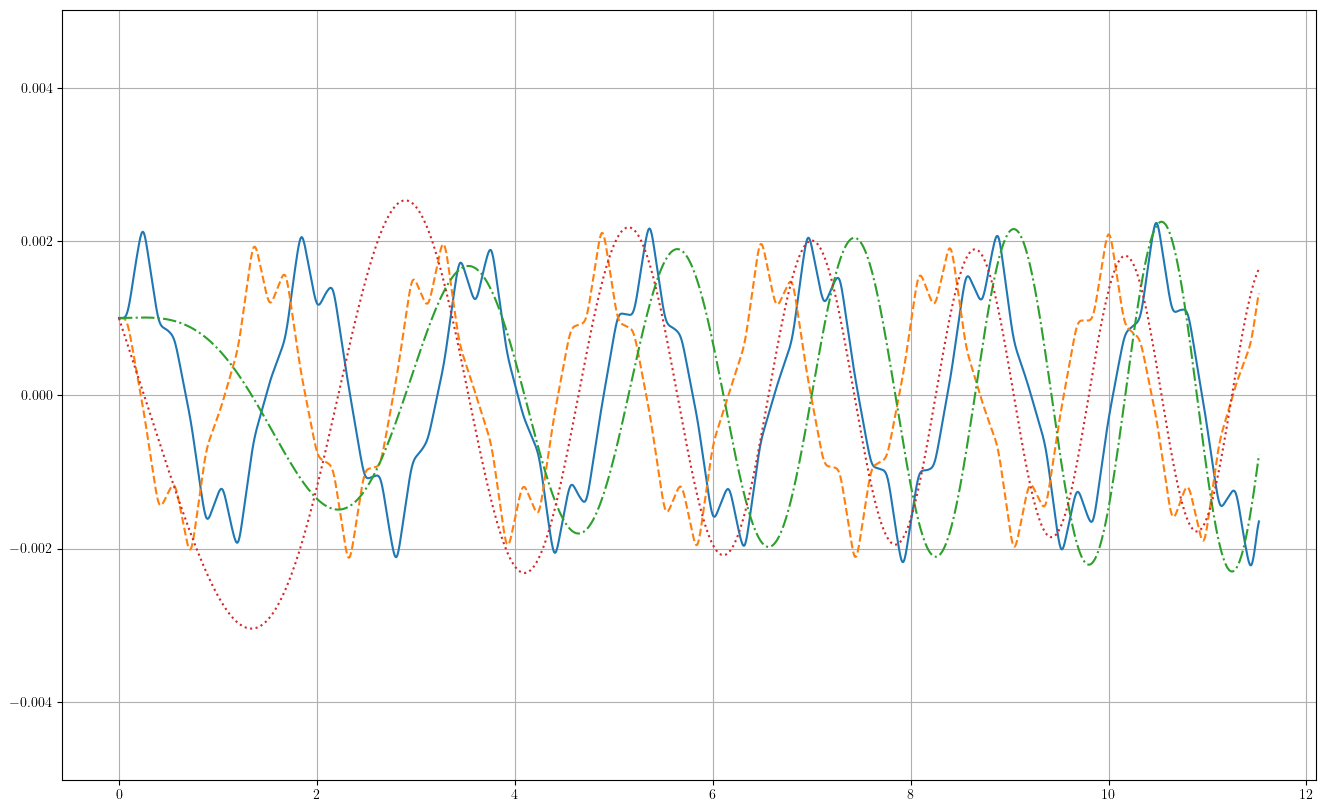

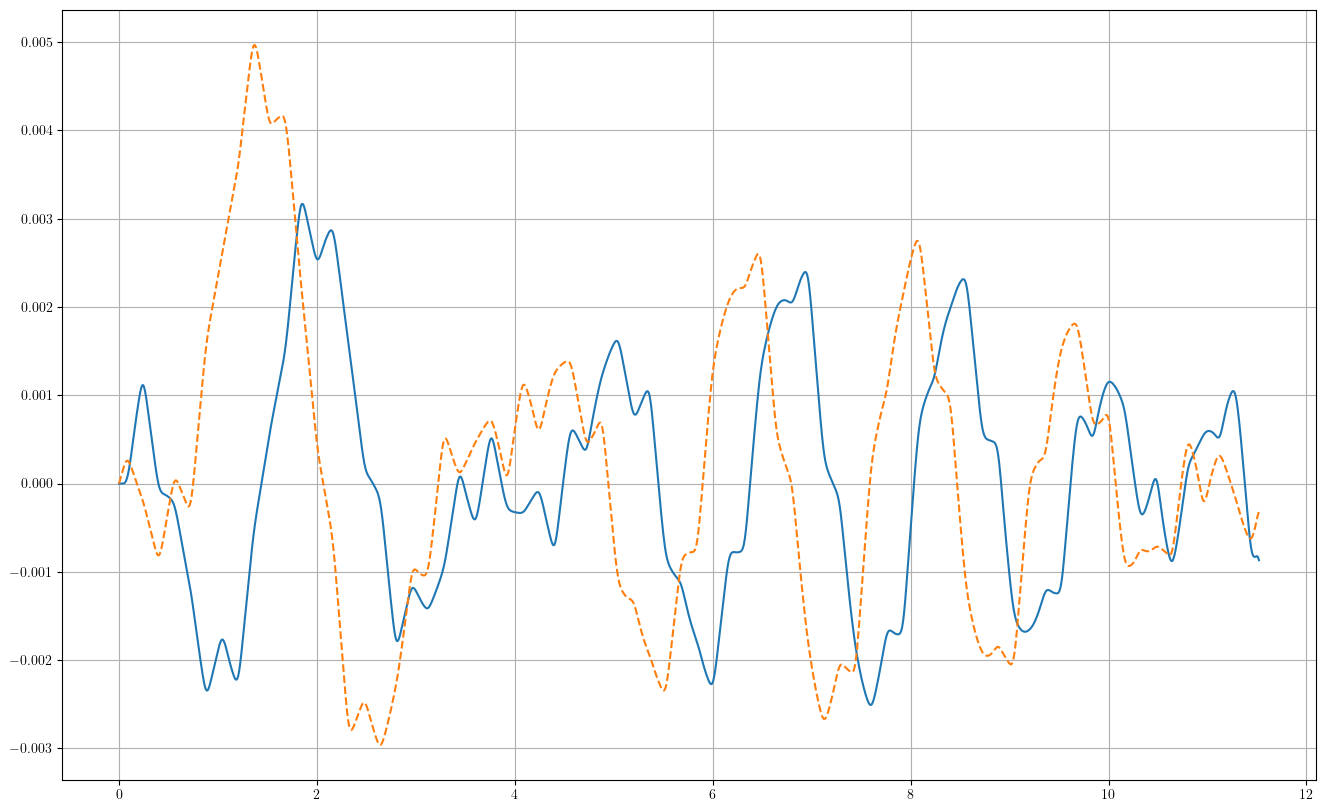

In [39]:
plt.figure(figsize=(10*GR,10))
plt.plot(z,X_W10[:,1],'-')
plt.plot(z,X_W10[:,2],'--')
plt.plot(z,sim[:,1],'-.')
plt.plot(z,sim[:,2],':')
plt.ylim([-5*x0,5*x0])
plt.grid(True)

plt.figure(figsize=(10*GR,10))
plt.plot(z,X_W10[:,1]-sim[:,1],'-')
plt.plot(z,X_W10[:,2]-sim[:,2],'--')
plt.grid(True)

Ok this makes sense, linear model only has excited coefficients. Need to see what other models could be used?

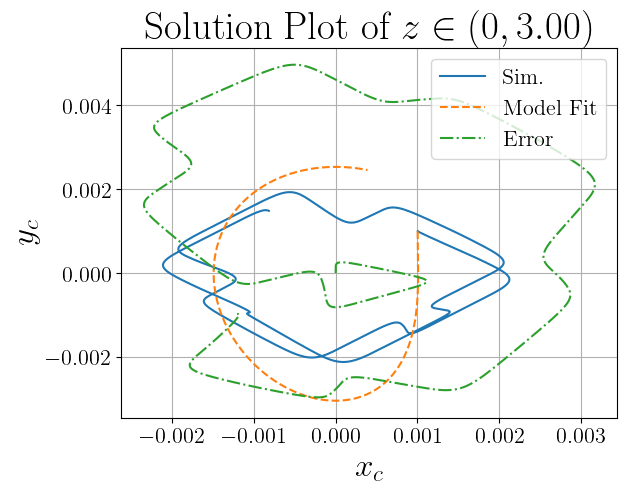

In [40]:
err = X_W10 - sim
zidx = 600

plt.figure()
plt.plot(X_W10[:zidx,1],X_W10[:zidx,2],label=r'Sim.')
plt.plot(sim[:zidx,1],sim[:zidx,2],'--',label=r'Model Fit')
plt.plot(err[:zidx,1],err[:zidx,2],'-.',label=r'Error')
plt.xlabel(r"$x_c$",fontsize=label_size)
plt.ylabel(r"$y_c$",fontsize=label_size)
plt.title(r"Solution Plot of $z\in(0,%.2f)$"%(z[zidx]),fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc='best',fontsize=leg_size)
plt.grid(True)
plt.show()

Ok so from this parametric model we know that the trajectory is not a 2D system. If we add z as a 3rd variable does that change things?

## Fourier Library

In [41]:
# differentiate the signal 
differentiation_method = ps.FiniteDifference(order=2)

# feature library
# just try Polynomial for fun for now
poly_library = ps.PolynomialLibrary(degree=0)
fourier_library = ps.FourierLibrary(n_frequencies=20)

feature_library = fourier_library + poly_library
# optimizer for the PySINDy model

In [42]:
nlibs = 2
ninputs = 3
inputs_temp = np.tile([0, 1, 2], nlibs)
inputs_per_library = np.reshape(inputs_temp, (nlibs, ninputs))

inputs_per_library[0,1] = 0
inputs_per_library[0,2] = 0
inputs_per_library[1,1] = 0
inputs_per_library[1,2] = 0

print(inputs_per_library)

[[0 0 0]
 [0 0 0]]


In [43]:
# create the generalized library
generalized_library = ps.GeneralizedLibrary(
    [poly_library,fourier_library],
    inputs_per_library=inputs_per_library,
)

In [44]:
optimizer = ps.STLSQ(threshold=0.002,alpha=0.05)
# create the PySINDy object of interest
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=generalized_library,
    optimizer=optimizer,
    feature_names=["z","x_c", "y_c"]
)

In [45]:
X_W10 = uniform_filter1d(pos,size=10,axis=0,mode='nearest')# set X equal to the window averaged amount
model.fit(X_W10, t=z)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=<pysindy.feature_library.generalized_library.GeneralizedLibrary object at 0x7fc7d0473e20>,
      feature_names=['z', 'x_c', 'y_c'], optimizer=STLSQ(threshold=0.002))

In [46]:
model.print()

(z)' = 0.999 1 + -0.002 cos(1 z) + -0.002 cos(5 z) + -0.003 cos(6 z) + -0.002 cos(7 z) + -0.002 cos(11 z) + -0.003 cos(12 z) + -0.002 cos(13 z) + -0.002 cos(17 z) + -0.003 cos(18 z) + -0.002 cos(19 z)
(x_c)' = 0.003 sin(4 z) + 0.003 sin(16 z) + -0.004 cos(16 z)
(y_c)' = -0.002 sin(4 z) + 0.003 cos(4 z) + 0.004 sin(16 z)


In [47]:
model.coefficients()

array([[ 0.99852785,  0.        , -0.00233311,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.00235021,  0.        , -0.00293914,  0.        , -0.00230852,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.00235321,  0.        , -0.00292443,
         0.        , -0.00228535,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00232735,
         0.        , -0.00290671,  0.        , -0.00230025,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.00263256,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.     

In [48]:
model.get_feature_names()

['1',
 'sin(1 z)',
 'cos(1 z)',
 'sin(2 z)',
 'cos(2 z)',
 'sin(3 z)',
 'cos(3 z)',
 'sin(4 z)',
 'cos(4 z)',
 'sin(5 z)',
 'cos(5 z)',
 'sin(6 z)',
 'cos(6 z)',
 'sin(7 z)',
 'cos(7 z)',
 'sin(8 z)',
 'cos(8 z)',
 'sin(9 z)',
 'cos(9 z)',
 'sin(10 z)',
 'cos(10 z)',
 'sin(11 z)',
 'cos(11 z)',
 'sin(12 z)',
 'cos(12 z)',
 'sin(13 z)',
 'cos(13 z)',
 'sin(14 z)',
 'cos(14 z)',
 'sin(15 z)',
 'cos(15 z)',
 'sin(16 z)',
 'cos(16 z)',
 'sin(17 z)',
 'cos(17 z)',
 'sin(18 z)',
 'cos(18 z)',
 'sin(19 z)',
 'cos(19 z)',
 'sin(20 z)',
 'cos(20 z)']

In [49]:
model.score(X_W10, t=z[-1]-z[0])

-3619229411.2621593

In [50]:
# plot the result
z0 = X_W10[0,0]
x0 = X_W10[0,1]
y0 = X_W10[0,2]
sim = model.simulate([z0,x0, y0], t=z)

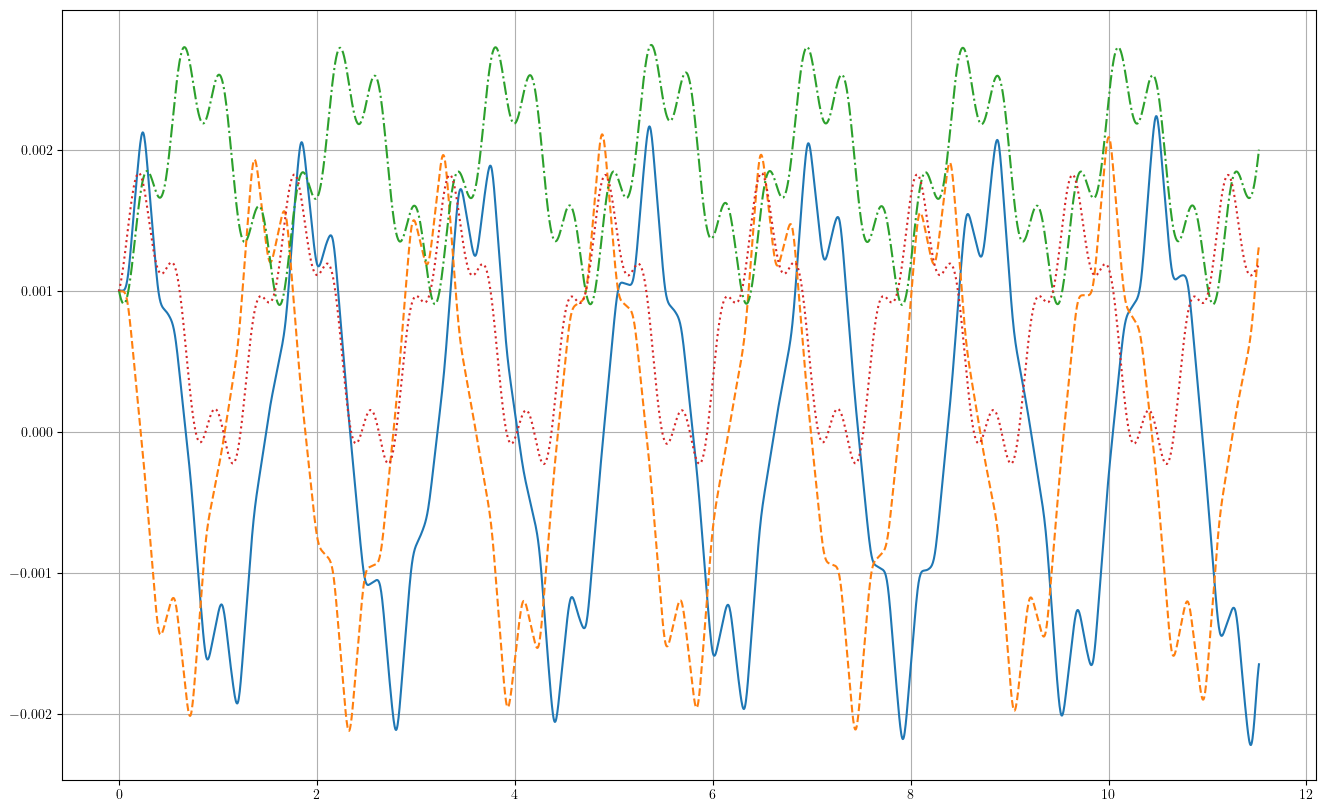

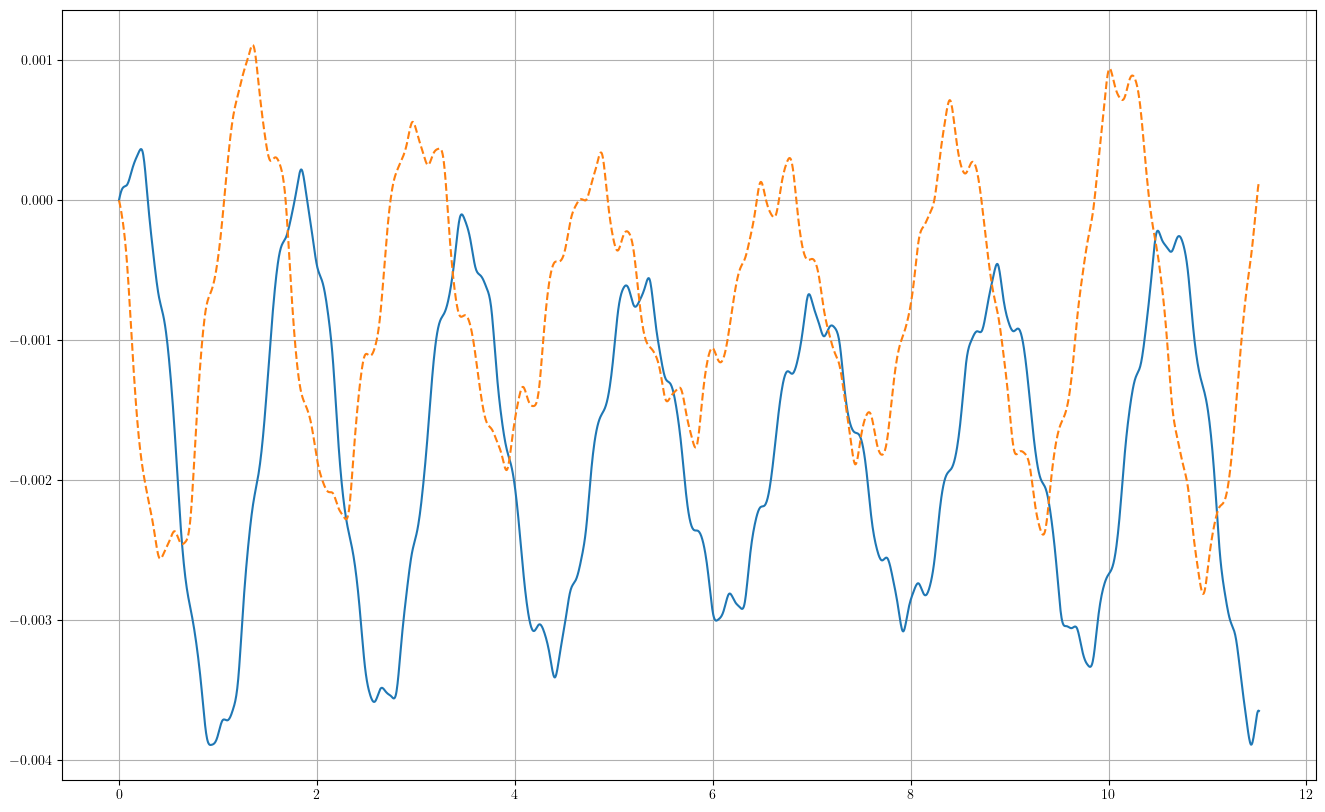

In [51]:
plt.figure(figsize=(10*GR,10))
plt.plot(z,X_W10[:,1],'-')
plt.plot(z,X_W10[:,2],'--')
plt.plot(z,sim[:,1],'-.')
plt.plot(z,sim[:,2],':')
plt.grid(True)

plt.figure(figsize=(10*GR,10))
plt.plot(z,X_W10[:,1]-sim[:,1],'-')
plt.plot(z,X_W10[:,2]-sim[:,2],'--')
plt.grid(True)

Ok this makes sense, linear model only has excited coefficients. Need to see what other models could be used?

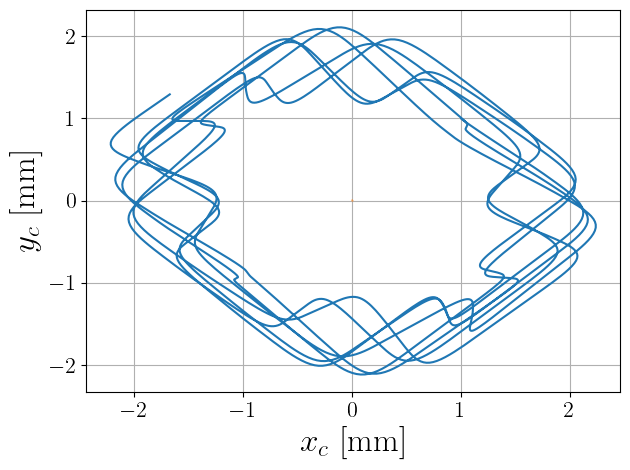

In [52]:
err = X_W10 - sim
zidx = -1

plt.figure()
plt.plot(1000*X_W10[:zidx,1],1000*X_W10[:zidx,2],"-",ms=1.0,label=r'WARP')
plt.plot(sim[:zidx,1],sim[:zidx,2],'--',label=r'SINDy')
# plt.plot(err[:zidx,1],err[:zidx,2],'-.',label=r'Error')
plt.xlabel(r"$x_c$ [mm]",fontsize=label_size)
plt.ylabel(r"$y_c$ [mm]",fontsize=label_size)
# plt.title(r"Sim. Data for $z\in(0,z_1)$",fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.grid(True)
plt.tight_layout()
plt.savefig("./figures/xc_yc_Phase_Space.pdf",dpi=200,transparent=True)
plt.show()

Really should be trying to learn the 4D system nonautonomous $(x,x',y,y')$ as a function of the lattice period $z$

## Custom Library Model

create 5D data set to be used for leanring. At leat 4D system for displacemet of $x_c$ and $y_c$

In [53]:
# z_tr = uniform_filter1d(pos[:,0],size=10,axis=0,mode='nearest')
x_c10 = uniform_filter1d(x_c,size=10,axis=0,mode='nearest')
y_c10 = uniform_filter1d(y_c,size=10,axis=0,mode='nearest')

x_c10p = fd._differentiate(x_c10, z)
y_c10p = fd._differentiate(y_c10, z)

# XY = np.array([z_tr,x_c10,y_c10,x_c10p,y_c10p]).T
XY = np.array([pos[:,0],x_c10,y_c10]).T
XY.shape

(2305, 3)

In [54]:
k_val_z

array([0.60737527, 2.51626898, 3.73101952])

In [55]:
poly_library = ps.PolynomialLibrary(degree=0)

cust_library_functions = [
#     lambda x : 1, # scal function
#     lambda x : x, # identity function for z,x_c,y_c
#     lambda x,y : x*y, # identity function for z,x_c,y_c
    lambda x : np.cos(2*np.pi*k_val_z[0]*x), # oscillatory lowest order
    lambda x : np.cos(2*np.pi*k_val_z[1]*x), # oscillatory 2nd order
    lambda x : np.cos(2*np.pi*k_val_z[2]*x), # oscillatory 3rd order
    lambda x : np.sin(2*np.pi*k_val_z[0]*x), # oscillatory lowest order
    lambda x : np.sin(2*np.pi*k_val_z[1]*x), # oscillatory 2nd order
    lambda x : np.sin(2*np.pi*k_val_z[2]*x), # oscillatory 3rd order
]
# library_function_names = [
#     lambda x : 'exp(' + x + ')',
#     lambda x : '1/' + x,
#     lambda x : x,
#     lambda x,y : 'sin(' + x + ',' + y + ')'
# ]
cust_library_function_names = [
    lambda x : "cos(k_0 " +  x + ")", # oscillatory lowest order
    lambda x : "cos(k_1 " +  x + ")", # oscillatory 2nd order
    lambda x : "cos(k_2 " +  x + ")", # oscillatory 3rd order
    lambda x : "sin(k_0 " +  x + ")", # oscillatory lowest order
    lambda x : "sin(k_1 " +  x + ")", # oscillatory 2nd order
    lambda x : "sin(k_2 " +  x + ")" # oscillatory 3rd order
]

custom_library = ps.CustomLibrary(
    library_functions=cust_library_functions, function_names=cust_library_function_names
)

# feature_library = ps.PolynomialLibrary(degree=0) + custom_library

nlibs = 2
ninputs = 3
inputs_temp = np.tile([0, 1, 2], nlibs)
inputs_per_library = np.reshape(inputs_temp, (nlibs, ninputs))

inputs_per_library[0,1] = 0
inputs_per_library[0,2] = 0
inputs_per_library[1,1] = 0
inputs_per_library[1,2] = 0

# create the generalized library
generalized_library = ps.GeneralizedLibrary(
    [poly_library,custom_library],
    inputs_per_library=inputs_per_library,
)

# model = ps.SINDy(feature_library=custom_library,feature_names=["z","x", "y","xp", "yp"])
opt = ps.STLSQ(threshold=0.000001,alpha=.01)
model = ps.SINDy(feature_library=generalized_library,
                 optimizer=opt,
                 feature_names=["z","x", "y"])
model.fit(XY, t=dz, quiet=True)
# model.print(lhs=["z","dx/dz","dy/dz","dxp/dz", "dyp/dz"])
model.print(lhs=["dz/dz","dx/dz","dy/dz"],precision=5)

dz/dz = 1.00000 1
dx/dz = -0.00023 1 + 0.00532 cos(k_0 z) + 0.00044 cos(k_1 z) + 0.00006 cos(k_2 z) + 0.00038 sin(k_0 z) + 0.00414 sin(k_1 z) + -0.00291 sin(k_2 z)
dy/dz = 0.00003 1 + -0.00056 cos(k_0 z) + 0.00415 cos(k_1 z) + 0.00276 cos(k_2 z) + -0.00562 sin(k_0 z) + 0.00038 sin(k_1 z) + -0.00036 sin(k_2 z)


In [56]:
model.coefficients()

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.28728477e-04,  5.32232945e-03,  4.41142220e-04,
         5.79993389e-05,  3.79220324e-04,  4.13530307e-03,
        -2.91382571e-03],
       [ 2.89818008e-05, -5.58830942e-04,  4.14648369e-03,
         2.76095409e-03, -5.61817685e-03,  3.75269713e-04,
        -3.58919790e-04]])

In [57]:
model.get_feature_names()

['1',
 'cos(k_0 z)',
 'cos(k_1 z)',
 'cos(k_2 z)',
 'sin(k_0 z)',
 'sin(k_1 z)',
 'sin(k_2 z)']

In [58]:
model.score(XY, t=z[-1]-z[0])

-7.326449572360777e+25

In [59]:
# plot the result
zo = XY[0,0]
x0 = XY[0,1]
y0 = XY[0,2]
sim = model.simulate([z0,x0, y0], t=z)
np.savetxt("fourier.txt",sim,delimiter=',')

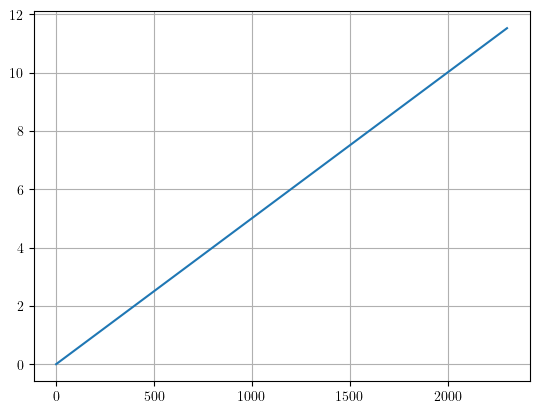

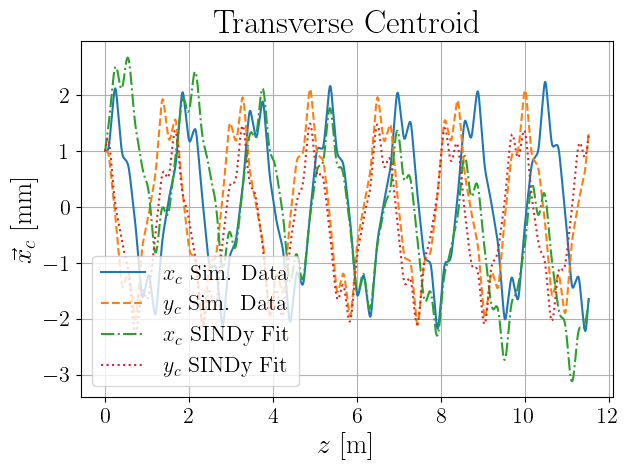

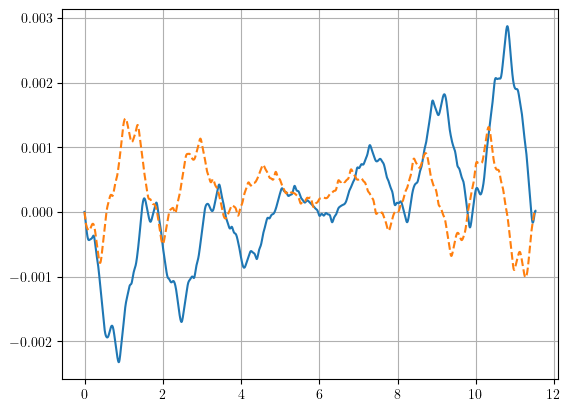

In [60]:
plt.figure()
plt.plot(sim[:,0])
plt.grid(True)

plt.figure()
xidx = 1
yidx = 2
plt.plot(z,1000*XY[:,xidx],'-',label=r"$x_c$ Sim. Data")
plt.plot(z,1000*XY[:,yidx],'--',label=r"$y_c$ Sim. Data")
plt.plot(z,1000*sim[:,xidx],'-.',label=r"$x_c$ SINDy Fit")
plt.plot(z,1000*sim[:,yidx],':',label=r"$y_c$ SINDy Fit")
plt.grid(True)
plt.xlabel(r'$z$ [m]',fontsize=20)
plt.ylabel(r'$\vec{x}_c$ [mm]',fontsize=20)
plt.title(r'Transverse Centroid',fontsize=24)
plt.legend(loc='best',fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.tight_layout()
plt.savefig("./figures/xc_yc_Fourier_mode.pdf",dpi=1000,transparent=True)

plt.figure()
plt.plot(z,XY[:,xidx]-sim[:,xidx],'-')
plt.plot(z,XY[:,yidx]-sim[:,yidx],'--')
plt.grid(True)

plt.show()

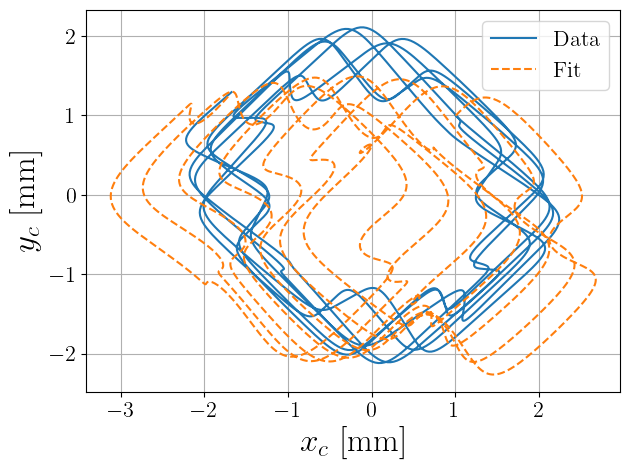

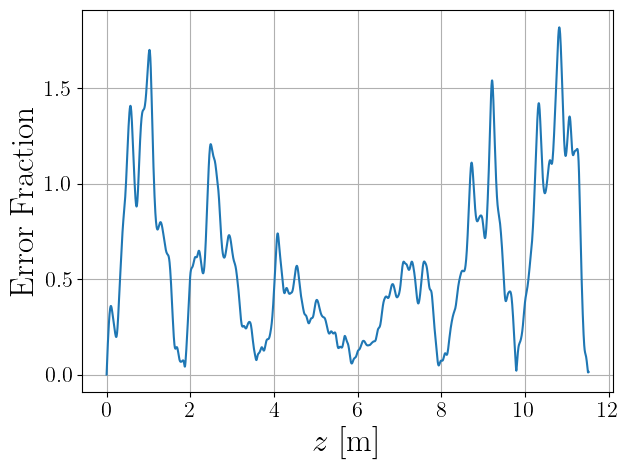

In [61]:
##### err = XY - sim
zidx = -1

plt.figure()
plt.plot(1000*XY[:zidx,xidx],1000*XY[:zidx,yidx],label=r'Data')
plt.plot(1000*sim[:zidx,xidx],1000*sim[:zidx,yidx],'--',label=r'Fit')
# plt.plot(err[:zidx,xidx],err[:zidx,yidx],'-.',label=r'Error')
plt.xlabel(r"$x_c$ [mm]",fontsize=label_size)
plt.ylabel(r"$y_c$ [mm]",fontsize=label_size)
# plt.title(r"Solution Plot of $z\in(0,z_1)$",fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc='best',fontsize=leg_size)
plt.grid(True)
plt.tight_layout()
plt.savefig("./figures/xc_yc_Fourier_mode_Phase_Space.pdf",dpi=200,transparent=True)
plt.show()

# plot the error
err = XY - sim

xperp_err = np.sqrt( err[:,1]**2 + err[:,2]**2)/np.sqrt( XY[:,1]**2 + XY[:,2]**2)

plt.figure()
plt.plot(pos[:zidx,0],xperp_err[:zidx],label=r'Error')
plt.xlabel(r"$z$ [m]",fontsize=label_size)
plt.ylabel(r"Error Fraction",fontsize=label_size)
# plt.title(r"Solution Plot of $z\in(0,%.2f)$"%(pos[:,0][zidx]),fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.grid(True)
# plt.savefig("./3D_SINDy_Error.pdf",dpi=1000,transparent=True)
plt.tight_layout()
plt.savefig("./figures/xc_yc_Fourier_mode_Error.pdf",dpi=200,transparent=True)
plt.show()

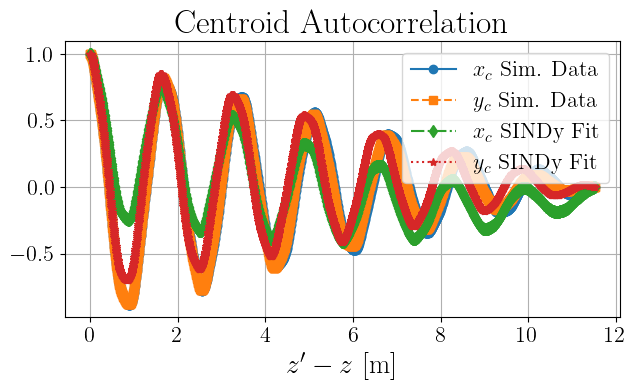

In [62]:
corr_x = np.correlate(XY[:,1], XY[:,1],mode='full')
corr_x = corr_x/(np.sum((XY[:,1])**2))

corr_y = np.correlate(XY[:,2], XY[:,2],mode='full')
corr_y = corr_y/(np.sum((XY[:,2])**2))

corr_x_s = np.correlate(sim[:,1], sim[:,1],mode='full')
corr_x_s = corr_x_s/(np.sum((sim[:,1])**2))

corr_y_s = np.correlate(sim[:,2], sim[:,2],mode='full')
corr_y_s = corr_y_s/(np.sum((sim[:,2])**2))

plt.figure(figsize=(GR*4,4))
plt.plot(z,corr_x[int(len(corr_x)/2):],'-o',color=colors[0],label=r"$x_c$ Sim. Data")
plt.plot(z,corr_y[int(len(corr_y)/2):],'--s',color=colors[1],label=r"$y_c$ Sim. Data")
plt.plot(z,corr_x_s[int(len(corr_y)/2):],'-.d',color=colors[2],label=r"$x_c$ SINDy Fit")
plt.plot(z,corr_y_s[int(len(corr_y)/2):],':*',color=colors[3],label=r"$y_c$ SINDy Fit")
plt.grid(True)
plt.xlabel(r"$z'-z$ [m]",fontsize=20)
plt.title(r'Centroid Autocorrelation',fontsize=24)
plt.legend(loc='best',fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.tight_layout()
plt.savefig("./figures/xc_yc_Fourier_mode_Autocorr.pdf",dpi=200,transparent=True)
plt.show()

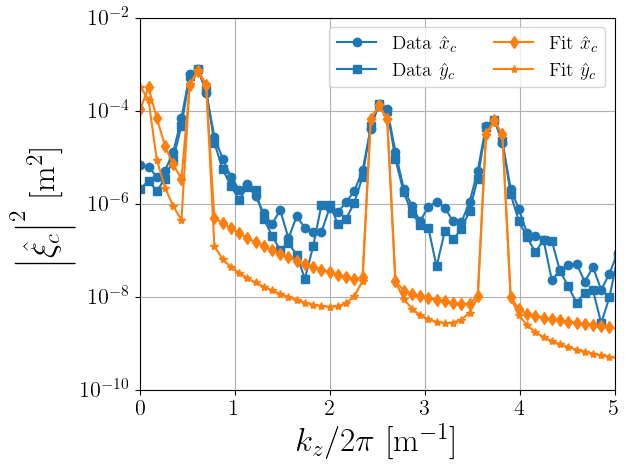

/var/folders/33/jztbzbp12xq9cj11tzlsrdm80000gn/T/ipykernel_21364/2492354301.py:25: RuntimeWarning: divide by zero encountered in power
  plt.plot(wn_z[:int(dat_f.shape[0]/2)],wn_z[:int(dat_f.shape[0]/2)]**(-2)/1000000,'k')


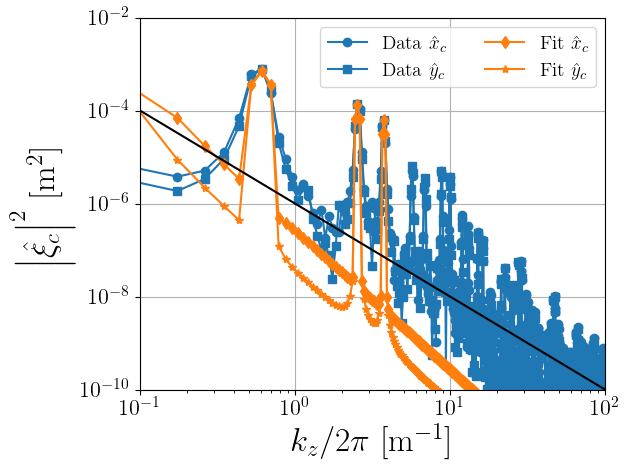

In [63]:
plt.figure()
plt.grid(True)
plt.magnitude_spectrum(XY[:,1], Fs=1.0/dz, color=colors[0],marker="o",label=r"Data $\hat{x}_c$")
plt.magnitude_spectrum(XY[:,2], Fs=1.0/dz, color=colors[0],marker="s",label=r"Data $\hat{y}_c$")
plt.magnitude_spectrum(sim[:,1], Fs=1.0/dz, color=colors[1],marker="d",label=r"Fit $\hat{x}_c$")
plt.magnitude_spectrum(sim[:,2], Fs=1.0/dz, color=colors[1],marker="*",label=r"Fit $\hat{y}_c$")
plt.yscale("log")
plt.xlabel(r"$k_z / 2 \pi$ [m$^{-1}$]",fontsize=label_size)
plt.ylabel(r"$\left| \hat{\xi}_c \right|^2$ [m$^2$]",fontsize=label_size)
# plt.title(r"Fourier Transform",fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc='best',fontsize=14,ncol=2)
plt.xlim([0,5])
plt.ylim([1e-10,1e-2])
plt.tight_layout()
plt.savefig("./figures/xc_yc_Fourier_mode_Fourier_Trans.pdf",dpi=200,transparent=True)
plt.show()

plt.figure()
plt.grid(True)
plt.magnitude_spectrum(XY[:,1], Fs=1.0/dz, color=colors[0],marker="o",label=r"Data $\hat{x}_c$")
plt.magnitude_spectrum(XY[:,2], Fs=1.0/dz, color=colors[0],marker="s",label=r"Data $\hat{y}_c$")
plt.magnitude_spectrum(sim[:,1], Fs=1.0/dz, color=colors[1],marker="d",label=r"Fit $\hat{x}_c$")
plt.magnitude_spectrum(sim[:,2], Fs=1.0/dz, color=colors[1],marker="*",label=r"Fit $\hat{y}_c$")
plt.plot(wn_z[:int(dat_f.shape[0]/2)],wn_z[:int(dat_f.shape[0]/2)]**(-2)/1000000,'k')
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k_z / 2 \pi$ [m$^{-1}$]",fontsize=label_size)
plt.ylabel(r"$\left| \hat{\xi}_c \right|^2$ [m$^2$]",fontsize=label_size)
# plt.title(r"Fourier Transform",fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc='best',fontsize=14,ncol=2)
plt.xlim([.1,100])
plt.ylim([1e-10,1e-2])
plt.tight_layout()
# plt.savefig("./figures/xc_yc_Fourier_mode_Fourier_Trans.pdf",dpi=200,transparent=True)
plt.show()
del()

## Another Custom Library Model

In [64]:
# plot plot
z = pos[:,0]
x_c = pos[:,1]
y_c = pos[:,2]

x_c10 = uniform_filter1d(x_c,size=10,axis=0,mode='nearest')
y_c10 = uniform_filter1d(y_c,size=10,axis=0,mode='nearest')

x_c10p = fd._differentiate(x_c10, z)
y_c10p = fd._differentiate(y_c10, z)

XY = np.array([x_c10,y_c10,x_c10p,y_c10p]).T
XY.shape

(2305, 4)

### 3D $(z,x_c,y_c)$ with no Sinusoid-Polynomial Coupling

In [65]:
XY = np.array([pos[:,0],x_c10,y_c10]).T
XY.shape

(2305, 3)

In [66]:
nlibs = 2
inputs_temp = np.tile([0, 1, 2], nlibs)
inputs_per_library = np.reshape(inputs_temp, (nlibs, 3))

# library one is gonna be the polynomial library
poly_library = ps.PolynomialLibrary(degree=1)

cust_library_1_functions = [
#     lambda x : 1, # scal function
#     lambda x : x, # identity function for z,x_c,y_c
#     lambda x,y : x*y, # identity function for z,x_c,y_c
    lambda x : np.cos(2*np.pi*k_val_z[0]*x), # oscillatory lowest order
    lambda x : np.cos(2*np.pi*k_val_z[1]*x), # oscillatory 2nd order
    lambda x : np.cos(2*np.pi*k_val_z[2]*x), # oscillatory 3rd order
    lambda x : np.sin(2*np.pi*k_val_z[0]*x), # oscillatory lowest order
    lambda x : np.sin(2*np.pi*k_val_z[1]*x), # oscillatory 2nd order
    lambda x : np.sin(2*np.pi*k_val_z[2]*x), # oscillatory 3rd order
]

cust_library_1_function_names = [
    lambda x : "cos(2 pi k_0 " +  x + ")", # oscillatory lowest order
    lambda x : "cos(2 pi k_1 " +  x + ")", # oscillatory 2nd order
    lambda x : "cos(2 pi k_2 " +  x + ")", # oscillatory 3rd order
    lambda x : "sin(2 pi k_0 " +  x + ")", # oscillatory lowest order
    lambda x : "sin(2 pi k_1 " +  x + ")", # oscillatory 2nd order
    lambda x : "sin(2 pi k_2 " +  x + ")" # oscillatory 3rd order
]

# modify the the custom library 1 with only z
inputs_per_library[1, 1] = 0
inputs_per_library[1, 2] = 0

# modify inputs of the custom library 2 with only radial stuff
# inputs_per_library[2, 0] = 1

# # modify inputs of the custom library 1 with fourier components
# inputs_per_library[3, 1] = 0
# inputs_per_library[3, 2] = 0

print(inputs_per_library)

[[0 1 2]
 [0 0 0]]


In [67]:
# tensor_array = [[1, 1, 0,0], [0, 1, 1,0],[0, 1, 0,1]]

# tensor_array = [[1, 1]]

# create the generalized library
# generalized_library = ps.GeneralizedLibrary(
#     [poly_library, custom_library_1],
#     tensor_array=tensor_array,
#     inputs_per_library=inputs_per_library,
# )

# non tensored library
generalized_library = ps.GeneralizedLibrary(
    [poly_library, custom_library],
    inputs_per_library=inputs_per_library,
)

values of threshold = 0.001 and $\alpha$ = 0.05 get nice results for the overall centroid plot with the old library for the sin and cosine vlaues arguement of $k_i z$

for the sine and cosine values with $2 \pi k_i z$ in the arugment we get very interseting results with threshold = 0.0001 and $\alpha =0.1$ 

In [68]:
opt = ps.STLSQ(threshold=0.001,alpha=0.1)
# fit and train the model
model = ps.SINDy(feature_library=generalized_library,
                 optimizer=opt,
                 feature_names=["z","x_c", "y_c"])
model.fit(XY, t=dz,quiet=True)
model.print(precision=8)

(z)' = 1.00000000 1
(x_c)' = 4.45575865 y_c + -0.00123704 cos(k_0 z) + 0.00298181 sin(k_1 z) + -0.00342880 sin(k_2 z)
(y_c)' = -2.93963747 x_c + 0.00338014 cos(k_1 z) + 0.00313052 cos(k_2 z) + -0.00116580 sin(k_0 z)


In [69]:
model.coefficients()[1,:]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.45575865e+00,
       -1.23704256e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.98181472e-03, -3.42880139e-03])

In [70]:
model.coefficients()[2,:]

array([ 0.00000000e+00,  0.00000000e+00, -2.93963747e+00,  0.00000000e+00,
        0.00000000e+00,  3.38013867e-03,  3.13052278e-03, -1.16580089e-03,
        0.00000000e+00,  0.00000000e+00])

In [71]:
model.get_feature_names()

['1',
 'z',
 'x_c',
 'y_c',
 'cos(k_0 z)',
 'cos(k_1 z)',
 'cos(k_2 z)',
 'sin(k_0 z)',
 'sin(k_1 z)',
 'sin(k_2 z)']

In [72]:
[z0,x0,y0] = XY[0,:]

sim = model.simulate([z0,x0, y0], t=XY[:,0])
np.savetxt("fourier_SHO.txt",sim,delimiter=',')

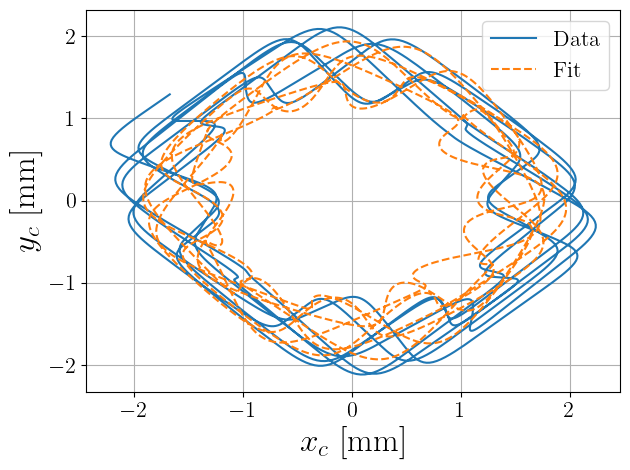

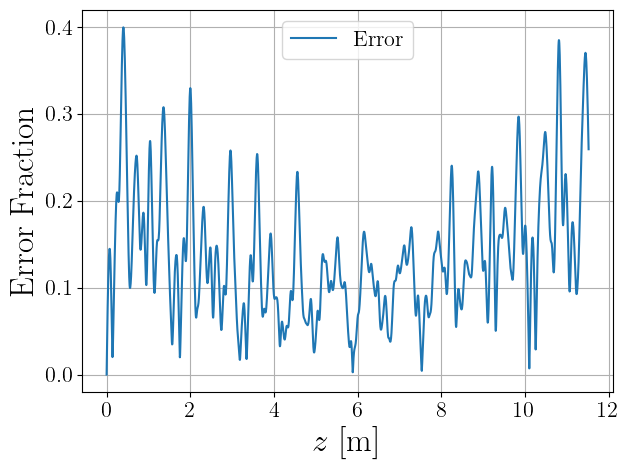

In [73]:
xidx = 1
yidx = 2
zidx = -1
ms_size = 0.5

plt.figure()
plt.plot(XY[:zidx,xidx]*1000,XY[:zidx,yidx]*1000,'-',ms=ms_size,label=r'Data')
plt.plot(sim[:zidx,xidx]*1000,sim[:zidx,yidx]*1000,'--',ms=ms_size,label=r'Fit')
# plt.plot(err[:zidx,xidx],err[:zidx,yidx],'-.',label=r'Error')
plt.xlabel(r"$x_c$ [mm]",fontsize=label_size)
plt.ylabel(r"$y_c$ [mm]",fontsize=label_size)
# plt.title(r"Solution Plot of $z\in(0,z_1)$",fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc='best',fontsize=leg_size)
plt.tight_layout()
plt.grid(True)
plt.savefig("./figures/xc_yc_MonFourierCoupling_Phase_Space.pdf",dpi=200,transparent=True)
plt.show()

# plot the error
err = XY - sim

xperp_err = np.sqrt( err[:,1]**2 + err[:,2]**2)/np.sqrt( XY[:,1]**2 + XY[:,2]**2)

plt.figure()
plt.plot(pos[:zidx,0],xperp_err[:zidx],label=r'Error')
plt.xlabel(r"$z$ [m]",fontsize=label_size)
plt.ylabel(r"Error Fraction",fontsize=label_size)
# plt.title(r"Solution Plot of $z\in(0,%.2f)$"%(pos[:,0][zidx]),fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc='best',fontsize=leg_size)
plt.grid(True)
plt.tight_layout()
plt.savefig("./figures/xc_yc_MonFourierCoupling_Error.pdf",dpi=200,transparent=True)
plt.show()

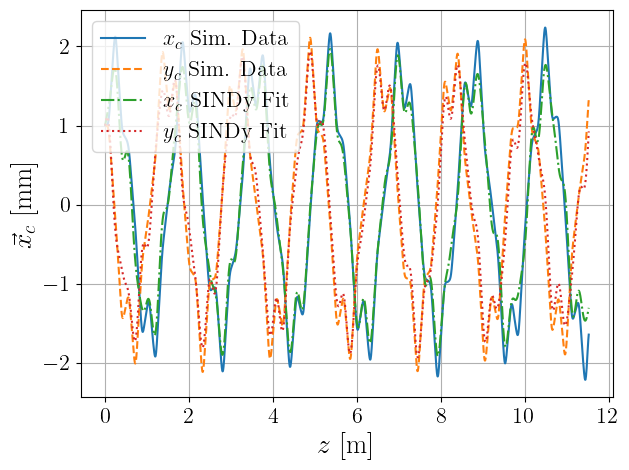

In [74]:
plt.figure()
xidx = 1
yidx = 2
plt.plot(z,1000*XY[:,xidx],'-',label=r"$x_c$ Sim. Data")
plt.plot(z,1000*XY[:,yidx],'--',label=r"$y_c$ Sim. Data")
plt.plot(z,1000*sim[:,xidx],'-.',label=r"$x_c$ SINDy Fit")
plt.plot(z,1000*sim[:,yidx],':',label=r"$y_c$ SINDy Fit")
plt.grid(True)
plt.xlabel(r'$z$ [m]',fontsize=20)
plt.ylabel(r'$\vec{x}_{c}$ [mm]',fontsize=20)
# plt.title(r'WARP Transverse Centroid',fontsize=24)
plt.legend(loc='best',fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.tight_layout()
plt.savefig("./figures/xc_yc_MonFourierCoupling.pdf",dpi=1000,transparent=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


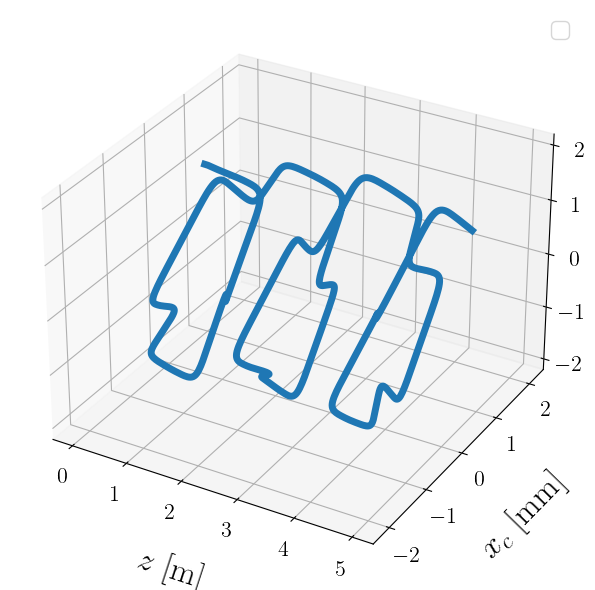

In [75]:
# get azimuthal thing to make movie from images from the LANL laptop
import matplotlib as mpl
COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
fig = plt.figure(figsize=(GR*6,6))
ax = fig.add_subplot(projection='3d')
zidx = 1000

sc = ax.plot(XY[:zidx,0], 1000*XY[:zidx,1], 1000* XY[:zidx,2],color=colors[0],linewidth=5.0)
# sc2 = ax.scatter(sim[:zidx,0], sim[:zidx,1], sim[:zidx,2],'-o',alpha=0.5,label='SINDy')

ax.set_xlabel(r'$z$ [m]',fontsize=label_size,labelpad=20)
ax.set_ylabel(r'$x_c$ [mm]',fontsize=label_size,labelpad=20)
ax.set_zlabel(r'$y_c$ [mm]',fontsize=label_size,labelpad=20)
ax.tick_params(axis='x', labelsize=tick_size) 
ax.tick_params(axis='y', labelsize=tick_size) 
ax.tick_params(axis='z', labelsize=tick_size) 
ax.legend(fontsize=leg_size)
plt.tight_layout()
# ax.view_init(elev=30., azim=90)
elev = 30
plt.savefig("./figures/movie_test.png",dpi=200,transparent=True)
# for ii in range(0,360,1):
#         ax.view_init(elev=elev, azim=ii)
#         plt.savefig("./movie/movie%d.png" % ii,dpi=200,transparent=True)
plt.show()

Compare scalar metric

In [76]:
# autocorrelation and fourier Transform

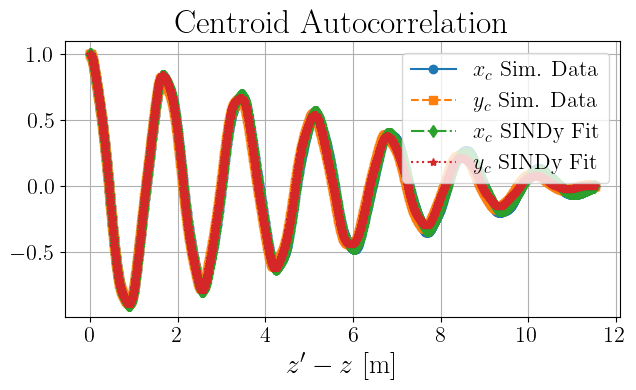

In [77]:
corr_x = np.correlate(XY[:,1], XY[:,1],mode='full')
corr_x = corr_x/(np.sum((XY[:,1])**2))

corr_y = np.correlate(XY[:,2], XY[:,2],mode='full')
corr_y = corr_y/(np.sum((XY[:,2])**2))

corr_x_s = np.correlate(sim[:,1], sim[:,1],mode='full')
corr_x_s = corr_x_s/(np.sum((sim[:,1])**2))

corr_y_s = np.correlate(sim[:,2], sim[:,2],mode='full')
corr_y_s = corr_y_s/(np.sum((sim[:,2])**2))

plt.figure(figsize=(GR*4,4))
plt.plot(z,corr_x[int(len(corr_x)/2):],'-o',color=colors[0],label=r"$x_c$ Sim. Data")
plt.plot(z,corr_y[int(len(corr_y)/2):],'--s',color=colors[1],label=r"$y_c$ Sim. Data")
plt.plot(z,corr_x_s[int(len(corr_y)/2):],'-.d',color=colors[2],label=r"$x_c$ SINDy Fit")
plt.plot(z,corr_y_s[int(len(corr_y)/2):],':*',color=colors[3],label=r"$y_c$ SINDy Fit")
plt.grid(True)
plt.xlabel(r"$z'-z$ [m]",fontsize=20)
plt.title(r'Centroid Autocorrelation',fontsize=24)
plt.legend(loc='best',fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.tight_layout()
plt.savefig("./figures/xc_yc_MonFourierCoupling_Autocorr.pdf",dpi=1000,transparent=True)
plt.show()

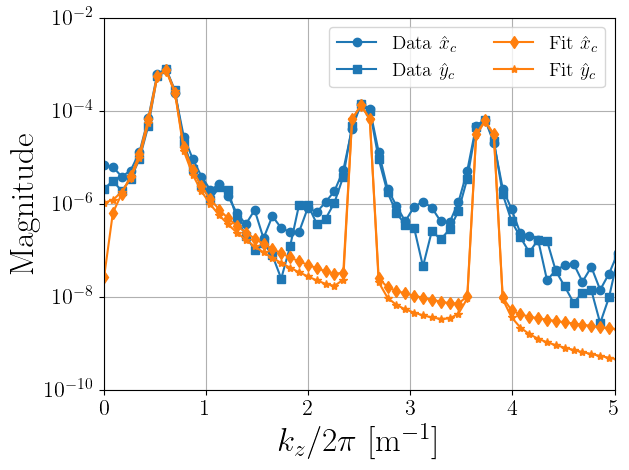

In [78]:
plt.figure()
plt.grid(True)
plt.magnitude_spectrum(XY[:,1], Fs=1.0/dz, color=colors[0],marker="o",label=r"Data $\hat{x}_c$")
plt.magnitude_spectrum(XY[:,2], Fs=1.0/dz, color=colors[0],marker="s",label=r"Data $\hat{y}_c$")
plt.magnitude_spectrum(sim[:,1], Fs=1.0/dz, color=colors[1],marker="d",label=r"Fit $\hat{x}_c$")
plt.magnitude_spectrum(sim[:,2], Fs=1.0/dz, color=colors[1],marker="*",label=r"Fit $\hat{y}_c$")
plt.yscale("log")
plt.xlabel(r"$k_z/2\pi$ [m$^{-1}$]",fontsize=label_size)
plt.ylabel(r"Magnitude",fontsize=label_size)
# plt.title(r"Fourier Transform",fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc='best',fontsize=14,ncol=2)
plt.xlim([0,5])
plt.ylim([1e-10,1e-2])
plt.tight_layout()
plt.savefig("./figures/xc_yc_MonFourierCoupling_Fourier_Trans.pdf",dpi=200,transparent=True)
plt.show()

In [79]:
# load and moving average the dataset
pos_turns = np.loadtxt("pos_turns.txt")

turn1 = pos.shape[0]
turn2 = int(pos_turns.shape[0]*0.4)
turn3 = int(pos_turns.shape[0]*0.6)

x_c10_turns = uniform_filter1d(pos_turns[:,1],size=10,axis=0,mode='nearest')
y_c10_turns = uniform_filter1d(pos_turns[:,2],size=10,axis=0,mode='nearest')

XY_turns = np.array([pos_turns[:,0],x_c10_turns,y_c10_turns]).T

zlen = pos.shape[0]

last_idx = -4
[z0,x0,y0] = XY_turns[0,:]
[z01,x01,y01] = XY_turns[zlen,:]
[z02,x02,y02] = XY_turns[2*zlen,:]
[z03,x03,y03] = XY_turns[3*zlen,:]
[z04,x04,y04] = XY_turns[4*zlen,:]

In [80]:
sim_turns_all = model.simulate([z0,x0, y0], t=pos_turns[:last_idx,0])
sim_turns_10 = model.simulate([z0,x0, y0], t=np.linspace(0.0,10*z01,int(10*z01/dz)))
sim_turns_100 = model.simulate([z0,x0, y0], t=np.linspace(0.0,100*z01,int(100*z01/dz)))
#sim_turns_1000 = model.simulate([z0,x0, y0], t=np.linspace(0.0,1000*z01,int(1000*z01/dz)))

In [81]:
np.savetxt("sim_turns_1000.txt",sim_turns_100,delimiter=',')

Turn 1 <x> Data [ 7.51493537e-06 -5.44780783e-05]
Turn 1 <x> Sim [ 1.10560314e-06 -4.46648598e-05]
Turn 1 <x> # Diff:  [-0.85287922 -0.18013151]
Turn 2 <x> Data [ 4.03841166e-05 -3.54239047e-05]
Turn 2 <x> Sim [ 2.12133427e-05 -7.59050950e-06]
Turn 2 <x> # Diff:  [-0.47471074 -0.78572352]
Turn 3 <x> Data [ 2.09076373e-05 -1.10008078e-05]
Turn 3 <x> Sim [-3.98731684e-06 -2.84507104e-06]
Turn 3 <x> # Diff:  [-1.19071102 -0.74137617]
Turn 1 <x^2> Data [1.53725842e-06 1.36466123e-06]
Turn 1 <x^2> Sim [1.24392387e-06 1.15409664e-06]
Turn 1 <x^2> # Diff:  [-0.19081668 -0.15429807]
Turn 2 <x^2> Data [1.55105224e-06 1.39499393e-06]
Turn 2 <x^2> Sim [9.58828172e-07 7.98413600e-07]
Turn 2 <x^2> # Diff:  [-0.38182084 -0.42765801]
Turn 3 <x^2> Data [1.55505288e-06 1.38934880e-06]
Turn 3 <x^2> Sim [9.14919930e-07 7.50523217e-07]
Turn 3 <x^2> # Diff:  [-0.41164706 -0.45980216]


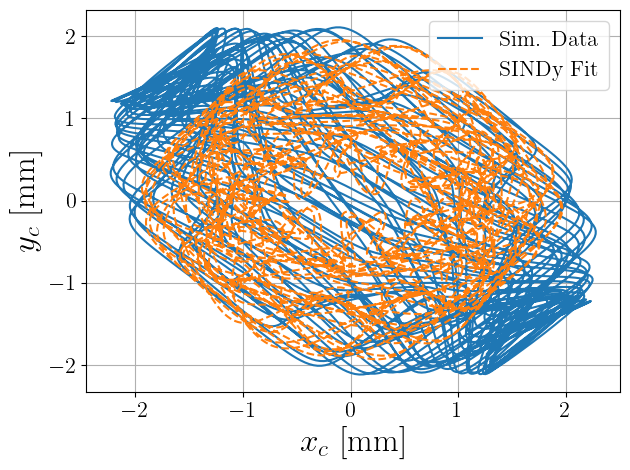

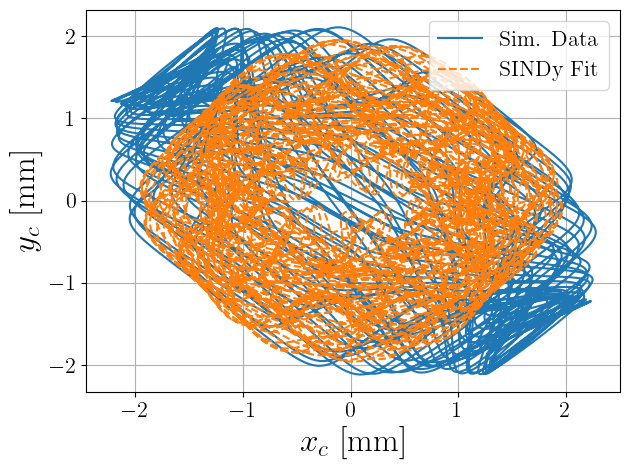

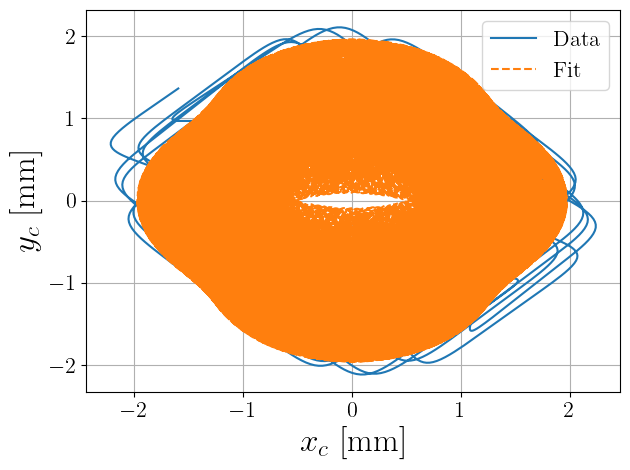

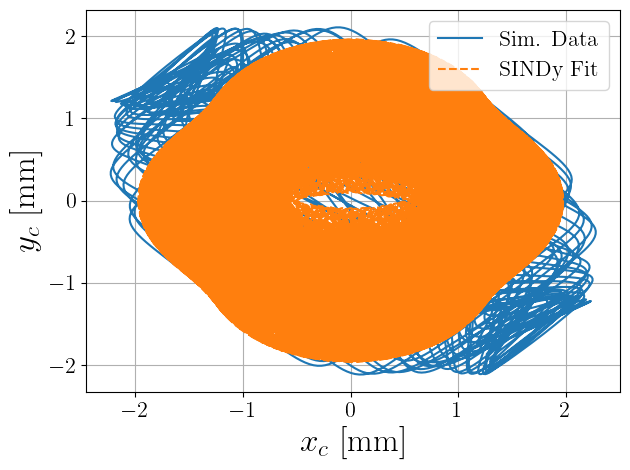

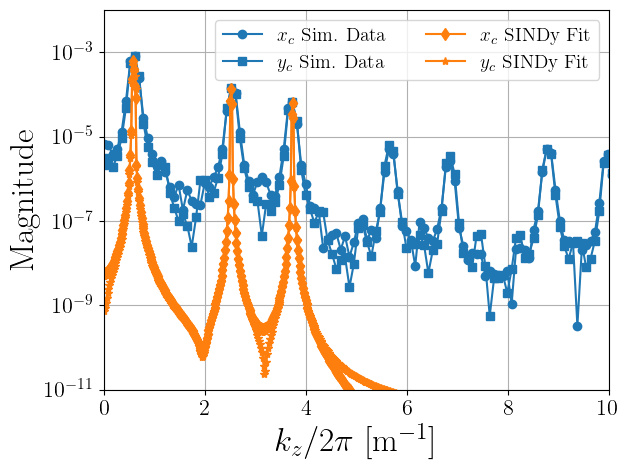

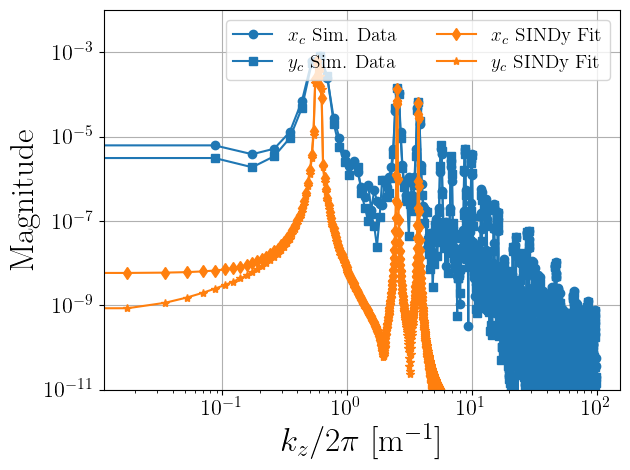

In [82]:
print("Turn 1 <x> Data",np.mean(XY_turns[:turn1,1:],axis=0))
print("Turn 1 <x> Sim",np.mean(sim_turns_all[:turn1,1:],axis=0))
print("Turn 1 <x> # Diff: ",(np.mean(sim_turns_all[:turn1,1:],axis=0)-np.mean(XY_turns[:turn1,1:],axis=0))/np.mean(XY_turns[:turn1,1:],axis=0))

print("Turn 2 <x> Data",np.mean(XY_turns[:turn2,1:],axis=0))
print("Turn 2 <x> Sim",np.mean(sim_turns_all[:turn2,1:],axis=0))
print("Turn 2 <x> # Diff: ",(np.mean(sim_turns_all[:turn2,1:],axis=0)-np.mean(XY_turns[:turn2,1:],axis=0))/np.mean(XY_turns[:turn2,1:],axis=0))

print("Turn 3 <x> Data",np.mean(XY_turns[:turn3,1:],axis=0))
print("Turn 3 <x> Sim",np.mean(sim_turns_all[:turn3,1:],axis=0))
print("Turn 3 <x> # Diff: ",(np.mean(sim_turns_all[:turn3,1:],axis=0)-np.mean(XY_turns[:turn3,1:],axis=0))/np.mean(XY_turns[:turn3,1:],axis=0))

print("Turn 1 <x^2> Data",np.var(XY_turns[:turn1,1:],axis=0))
print("Turn 1 <x^2> Sim",np.var(sim_turns_all[:turn1,1:],axis=0))
print("Turn 1 <x^2> # Diff: ",(np.var(sim_turns_all[:turn1,1:],axis=0)-np.var(XY_turns[:turn1,1:],axis=0))/np.var(XY_turns[:turn1,1:],axis=0))

print("Turn 2 <x^2> Data",np.var(XY_turns[:turn2,1:],axis=0))
print("Turn 2 <x^2> Sim",np.var(sim_turns_all[:turn2,1:],axis=0))
print("Turn 2 <x^2> # Diff: ",(np.var(sim_turns_all[:turn2,1:],axis=0)-np.var(XY_turns[:turn2,1:],axis=0))/np.var(XY_turns[:turn2,1:],axis=0))

print("Turn 3 <x^2> Data",np.var(XY_turns[:turn3,1:],axis=0))
print("Turn 3 <x^2> Sim",np.var(sim_turns_all[:turn3,1:],axis=0))
print("Turn 3 <x^2> # Diff: ",(np.var(sim_turns_all[:turn3,1:],axis=0)-np.var(XY_turns[:turn3,1:],axis=0))/np.var(XY_turns[:turn3,1:],axis=0))

# print("Turn 1 <x> Data",np.mean(XY_turns[:turn1,1:],axis=0))
# print("Turn 1 <x> Sim",np.mean(sim_turns_100[:turn1,1:],axis=0))
# print("Turn 1 <x> # Diff: ",(np.mean(sim_turns_100[:turn1,1:],axis=0)-np.mean(XY_turns[:turn1,1:],axis=0))/np.mean(XY_turns[:turn1,1:],axis=0))

# print("Turn 2 <x> Data",np.mean(XY_turns[:turn2,1:],axis=0))
# print("Turn 2 <x> Sim",np.mean(sim_turns_100[:turn2,1:],axis=0))
# print("Turn 2 <x> # Diff: ",(np.mean(sim_turns_100[:turn2,1:],axis=0)-np.mean(XY_turns[:turn2,1:],axis=0))/np.mean(XY_turns[:turn2,1:],axis=0))

# print("Turn 3 <x> Data",np.mean(XY_turns[:turn3,1:],axis=0))
# print("Turn 3 <x> Sim",np.mean(sim_turns_100[:turn3,1:],axis=0))
# print("Turn 3 <x> # Diff: ",(np.mean(sim_turns_100[:turn3,1:],axis=0)-np.mean(XY_turns[:turn3,1:],axis=0))/np.mean(XY_turns[:turn3,1:],axis=0))

# print("Turn 1 <x^2> Data",np.var(XY_turns[:turn1,1:],axis=0))
# print("Turn 1 <x^2> Sim",np.var(sim_turns_100[:turn1,1:],axis=0))
# print("Turn 1 <x^2> # Diff: ",(np.var(sim_turns_100[:turn1,1:],axis=0)-np.var(XY_turns[:turn1,1:],axis=0))/np.var(XY_turns[:turn1,1:],axis=0))

# print("Turn 2 <x^2> Data",np.var(XY_turns[:turn2,1:],axis=0))
# print("Turn 2 <x^2> Sim",np.var(sim_turns_100[:turn2,1:],axis=0))
# print("Turn 2 <x^2> # Diff: ",(np.var(sim_turns_100[:turn2,1:],axis=0)-np.var(XY_turns[:turn2,1:],axis=0))/np.var(XY_turns[:turn2,1:],axis=0))

# print("Turn 3 <x^2> Data",np.var(XY_turns[:turn3,1:],axis=0))
# print("Turn 3 <x^2> Sim",np.var(sim_turns_100[:turn3,1:],axis=0))
# print("Turn 3 <x^2> # Diff: ",(np.var(sim_turns_100[:turn3,1:],axis=0)-np.var(XY_turns[:turn3,1:],axis=0))/np.var(XY_turns[:turn3,1:],axis=0))



plt.figure()
plt.plot(XY_turns[:,1]*1000,XY_turns[:,2]*1000,color=colors[0],linestyle='-',label=r'Sim. Data')
plt.plot(sim_turns_all[:,1]*1000,sim_turns_all[:,2]*1000,color=colors[1],linestyle='--',label=r'SINDy Fit')
plt.xlabel(r"$x_c$ [mm]",fontsize=label_size)
plt.ylabel(r"$y_c$ [mm]",fontsize=label_size)
# plt.title(r"Solution Plot of $z\in(0,z_1)$",fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc='best',fontsize=leg_size)
plt.tight_layout()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(XY_turns[:,1]*1000,XY_turns[:,2]*1000,color=colors[0],linestyle='-',label=r'Sim. Data')
plt.plot(sim_turns_10[:,1]*1000,sim_turns_10[:,2]*1000,color=colors[1],linestyle='--',label=r'SINDy Fit')
plt.xlabel(r"$x_c$ [mm]",fontsize=label_size)
plt.ylabel(r"$y_c$ [mm]",fontsize=label_size)
# plt.title(r"Solution Plot of $z\in(0,z_1)$",fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc='best',fontsize=leg_size)
plt.tight_layout()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(XY_turns[:turn1,1]*1000,XY_turns[:turn1,2]*1000,color=colors[0],linestyle='-',label=r'Data')
plt.plot(sim_turns_100[:,1]*1000,sim_turns_100[:,2]*1000,color=colors[1],linestyle='--',label=r'Fit')
plt.xlabel(r"$x_c$ [mm]",fontsize=label_size)
plt.ylabel(r"$y_c$ [mm]",fontsize=label_size)
# plt.title(r"Solution Plot of $z\in(0,z_1)$",fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc='best',fontsize=leg_size)
plt.tight_layout()
plt.grid(True)
plt.savefig("./figures/xc_yc_MonFourierCoupling_100Turns.pdf",dpi=1000,transparent=True)
plt.show()

plt.figure()
plt.plot(XY_turns[:,1]*1000,XY_turns[:,2]*1000,color=colors[0],linestyle='-',label=r'Sim. Data')
plt.plot(sim_turns_100[:,1]*1000,sim_turns_100[:,2]*1000,color=colors[1],linestyle='--',label=r'SINDy Fit')
plt.xlabel(r"$x_c$ [mm]",fontsize=label_size)
plt.ylabel(r"$y_c$ [mm]",fontsize=label_size)
# plt.title(r"Solution Plot of $z\in(0,z_1)$",fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc='best',fontsize=leg_size)
plt.tight_layout()
plt.grid(True)
plt.show()


plt.figure()
plt.grid(True)
# plt.plot(XY_turns[:,1],XY_turns[:,2],color=colors[0],linestyle='-')
# plt.plot(sim_turns_all[:,1],sim_turns_all[:,2],color=colors[1],linestyle='--')
plt.magnitude_spectrum(XY[:,1], Fs=1.0/dz, color=colors[0],marker="o",label=r"$x_c$ Sim. Data")
plt.magnitude_spectrum(XY[:,2], Fs=1.0/dz, color=colors[0],marker="s",label=r"$y_c$ Sim. Data")
plt.magnitude_spectrum(sim_turns_all[:,1], Fs=1.0/dz, color=colors[1],marker="d",label=r"$x_c$ SINDy Fit")
plt.magnitude_spectrum(sim_turns_all[:,2], Fs=1.0/dz, color=colors[1],marker="*",label=r"$y_c$ SINDy Fit")
plt.yscale("log")
plt.xlabel(r"$k_z/2\pi$ [m$^{-1}$]",fontsize=label_size)
plt.ylabel(r"Magnitude",fontsize=label_size)
# plt.title(r"Fourier Transform",fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc='best',fontsize=14,ncol=2)
plt.xlim([0,10])
plt.ylim([1e-11,1e-2])
plt.tight_layout()
plt.show()

plt.figure()
plt.grid(True)
# plt.plot(XY_turns[:,1],XY_turns[:,2],color=colors[0],linestyle='-')
# plt.plot(sim_turns_all[:,1],sim_turns_all[:,2],color=colors[1],linestyle='--')
plt.magnitude_spectrum(XY[:,1], Fs=1.0/dz, color=colors[0],marker="o",label=r"$x_c$ Sim. Data")
plt.magnitude_spectrum(XY[:,2], Fs=1.0/dz, color=colors[0],marker="s",label=r"$y_c$ Sim. Data")
plt.magnitude_spectrum(sim_turns_all[:,1], Fs=1.0/dz, color=colors[1],marker="d",label=r"$x_c$ SINDy Fit")
plt.magnitude_spectrum(sim_turns_all[:,2], Fs=1.0/dz, color=colors[1],marker="*",label=r"$y_c$ SINDy Fit")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k_z/2\pi$ [m$^{-1}$]",fontsize=label_size)
plt.ylabel(r"Magnitude",fontsize=label_size)
# plt.title(r"Fourier Transform",fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc='best',fontsize=14,ncol=2)
plt.ylim([1e-11,1e-2])
plt.tight_layout()
plt.show()

### 3D $(z, x_c, y_c)$ with nonlinear coupling

In [83]:
XY = np.array([pos[:,0],x_c10,y_c10]).T
XY.shape

(2305, 3)

In [84]:
nlibs = 2
inputs_temp = np.tile([0, 1, 2], nlibs)
inputs_per_library = np.reshape(inputs_temp, (nlibs, 3))

# library one is gonna be the polynomial library
poly_library = ps.PolynomialLibrary(degree=1)

cust_library_1_functions = [
#     lambda x : 1, # scal function
#     lambda x : x, # identity function for z,x_c,y_c
#     lambda x,y : x*y, # identity function for z,x_c,y_c
    lambda x : np.cos(2*np.pi*k_val_z[0]*x), # oscillatory lowest order
    lambda x : np.cos(2*np.pi*k_val_z[1]*x), # oscillatory 2nd order
    lambda x : np.cos(2*np.pi*k_val_z[2]*x), # oscillatory 3rd order
    lambda x : np.sin(2*np.pi*k_val_z[0]*x), # oscillatory lowest order
    lambda x : np.sin(2*np.pi*k_val_z[1]*x), # oscillatory 2nd order
    lambda x : np.sin(2*np.pi*k_val_z[2]*x), # oscillatory 3rd order
    # lambda x : np.cos(k_val_z[0]*x), # oscillatory lowest order
    # lambda x : np.cos(k_val_z[1]*x), # oscillatory 2nd order
    # lambda x : np.cos(k_val_z[2]*x), # oscillatory 3rd order
    # lambda x : np.sin(k_val_z[0]*x), # oscillatory lowest order
    # lambda x : np.sin(k_val_z[1]*x), # oscillatory 2nd order
    # lambda x : np.sin(k_val_z[2]*x), # oscillatory 3rd order
]

cust_library_1_function_names = [
    lambda x : "cos(2 pi k_0 " +  x + ")", # oscillatory lowest order
    lambda x : "cos(2 pi k_1 " +  x + ")", # oscillatory 2nd order
    lambda x : "cos(2 pi k_2 " +  x + ")", # oscillatory 3rd order
    lambda x : "sin(2 pi k_0 " +  x + ")", # oscillatory lowest order
    lambda x : "sin(2 pi k_1 " +  x + ")", # oscillatory 2nd order
    lambda x : "sin(2 pi k_2 " +  x + ")" # oscillatory 3rd order
]

# modify the the custom library 1 with only z
inputs_per_library[1, 1] = 0
inputs_per_library[1, 2] = 0

# modify inputs of the custom library 2 with only radial stuff
# inputs_per_library[2, 0] = 1

# # modify inputs of the custom library 1 with fourier components
# inputs_per_library[3, 1] = 0
# inputs_per_library[3, 2] = 0

print(inputs_per_library)

[[0 1 2]
 [0 0 0]]


In [85]:
# tensor_array = [[1, 1, 0,0], [0, 1, 1,0],[0, 1, 0,1]]

tensor_array = [[1, 1]]

# create the generalized library
generalized_library = ps.GeneralizedLibrary(
    [poly_library, custom_library],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library,
)

# non tensored library
# generalized_library = ps.GeneralizedLibrary(
#     [poly_library, custom_library_1],
#     inputs_per_library=inputs_per_library,
# )

model.get_feature_names()

['1',
 'z',
 'x_c',
 'y_c',
 'cos(k_0 z)',
 'cos(k_1 z)',
 'cos(k_2 z)',
 'sin(k_0 z)',
 'sin(k_1 z)',
 'sin(k_2 z)']

values of threshold = 0.001 and $\alpha$ = 0.05 get nice results for the overall centroid plot with the old library for the sin and cosine vlaues arguement of $\frac{z}{\lambda_i}$

for the sine and cosine values with $2 \pi \frac{z}{\lambda_i} $ in the arugment we get very interseting results with threshold = 0.0001 and $\alpha =0.1$ 

for the final implementation of the model the threshold is 0.0 and $\alpha = 0.1$

In [86]:
opt = ps.STLSQ(threshold=0.000,alpha=0.1)
# fit and train the model
model = ps.SINDy(feature_library=generalized_library,
                 optimizer=opt,
                 feature_names=["z","x_c", "y_c"])
model.fit(XY, t=dz,quiet=True)
model.print(precision=8)

(z)' = 1.00000000 1 + -0.00000001 y_c
(x_c)' = 0.00006301 1 + 0.00001545 z + -0.48990961 x_c + 5.90762069 y_c + -0.00091998 cos(k_0 z) + -0.00114674 cos(k_1 z) + -0.00142034 cos(k_2 z) + 0.00175378 sin(k_0 z) + 0.00148696 sin(k_1 z) + -0.00177711 sin(k_2 z) + -0.00091998 1 cos(k_0 z) + -0.00114674 1 cos(k_1 z) + -0.00142034 1 cos(k_2 z) + 0.00175378 1 sin(k_0 z) + 0.00148696 1 sin(k_1 z) + -0.00177711 1 sin(k_2 z) + -0.00028155 z cos(k_0 z) + 0.00047862 z cos(k_1 z) + 0.00050063 z cos(k_2 z) + -0.00025790 z sin(k_0 z) + -0.00007070 z sin(k_1 z) + 0.00000324 z sin(k_2 z) + 0.07785089 x_c cos(k_0 z) + 0.06057961 x_c cos(k_1 z) + 0.08752528 x_c cos(k_2 z) + -0.10520021 x_c sin(k_0 z) + 0.04604029 x_c sin(k_1 z) + -0.01397233 x_c sin(k_2 z) + -0.07271342 y_c cos(k_0 z) + 0.00546940 y_c cos(k_1 z) + -0.01876601 y_c cos(k_2 z) + -0.04039574 y_c sin(k_0 z) + 0.12096999 y_c sin(k_1 z) + -0.09709089 y_c sin(k_2 z)
(y_c)' = -0.00034406 1 + 0.00003406 z + -2.62213848 x_c + 0.82586473 y_c + -0.001

In [87]:
DAT = np.column_stack(
        (np.array(model.get_feature_names())
    ,model.coefficients()[1]) )
np.savetxt("Case1_xc.txt",DAT,delimiter=" ", fmt="%s")

DAT = np.column_stack(
        (np.array(model.get_feature_names())
    ,model.coefficients()[2]) )
np.savetxt("Case1_yc.txt",DAT,delimiter=" ", fmt="%s")

In [88]:
[z0,x0,y0] = XY[0,:]
start = time.time()
sim = model.simulate([z0,x0, y0], t=XY[:,0])
end = time.time()
print(end-start)
np.savetxt("sim_try3.txt",sim,delimiter=',')

1.0613000392913818


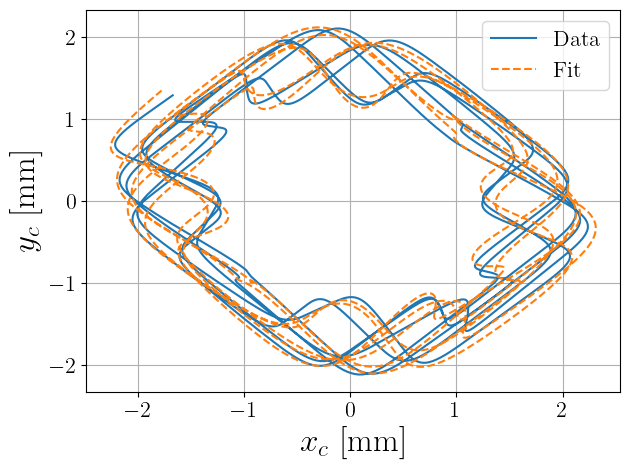

[0.99415741 0.99725462]


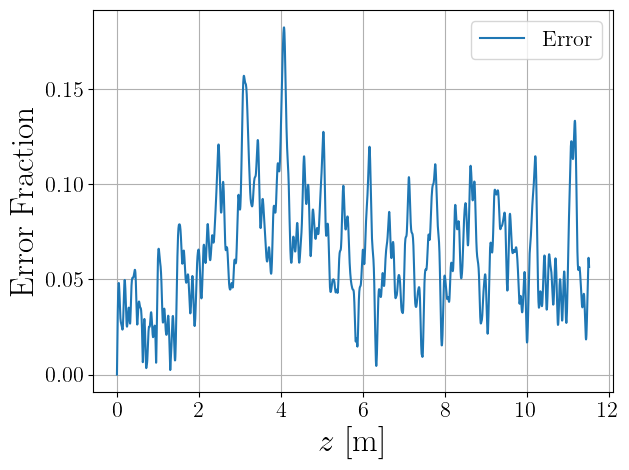

In [89]:
xidx = 1
yidx = 2
zidx = -1
ms_size = 0.5

plt.figure()
plt.plot(XY[:zidx,xidx]*1000,XY[:zidx,yidx]*1000,'-',ms=ms_size,label=r'Data')
plt.plot(sim[:zidx,xidx]*1000,sim[:zidx,yidx]*1000,'--',ms=ms_size,label=r'Fit')
# plt.plot(err[:zidx,xidx],err[:zidx,yidx],'-.',label=r'Error')
plt.xlabel(r"$x_c$ [mm]",fontsize=label_size)
plt.ylabel(r"$y_c$ [mm]",fontsize=label_size)
# plt.title(r"Solution Plot of $z\in(0,z_1)$",fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc='best',fontsize=leg_size)
plt.tight_layout()
plt.grid(True)
plt.savefig("./figures/xc_yc_NonlinearFourier_Phase_Space.pdf",dpi=200,transparent=True)
plt.show()

# plot the error
err = XY - sim

r2 = 1 - np.sum(err[:,1:]**2,axis=0)/np.sum((XY[:,1:] - np.mean(XY[:,1:],axis=0))**2,axis=0)

print(r2)

xperp_err = np.sqrt( err[:,1]**2 + err[:,2]**2)/np.sqrt( XY[:,1]**2 + XY[:,2]**2)

plt.figure()
plt.plot(pos[:zidx,0],xperp_err[:zidx],label=r'Error')
plt.xlabel(r"$z$ [m]",fontsize=label_size)
plt.ylabel(r"Error Fraction",fontsize=label_size)
# plt.title(r"Solution Plot of $z\in(0,%.2f)$"%(pos[:,0][zidx]),fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc='best',fontsize=leg_size)
plt.grid(True)
plt.tight_layout()
plt.savefig("./figures/xc_yc_NonlinearFourier_Error.pdf",dpi=200,transparent=True)
plt.show()

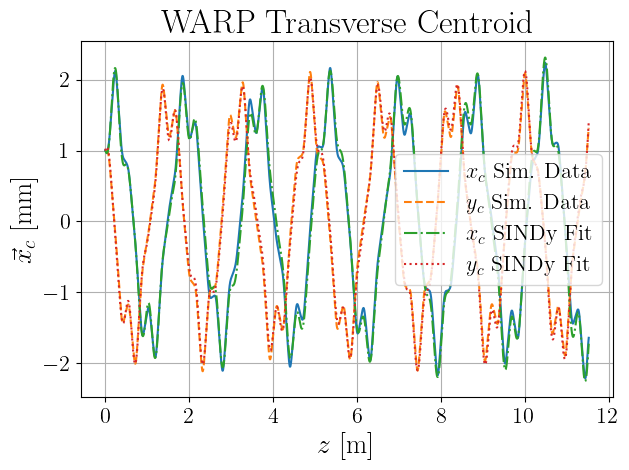

In [90]:
plt.figure()
xidx = 1
yidx = 2
plt.plot(z,1000*XY[:,xidx],'-',label=r"$x_c$ Sim. Data")
plt.plot(z,1000*XY[:,yidx],'--',label=r"$y_c$ Sim. Data")
plt.plot(z,1000*sim[:,xidx],'-.',label=r"$x_c$ SINDy Fit")
plt.plot(z,1000*sim[:,yidx],':',label=r"$y_c$ SINDy Fit")
plt.grid(True)
plt.xlabel(r'$z$ [m]',fontsize=20)
plt.ylabel(r'$\vec{x}_c$ [mm]',fontsize=20)
plt.title(r'WARP Transverse Centroid',fontsize=24)
plt.legend(loc='best',fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.tight_layout()
plt.savefig("./figures/xc_yc_NonlinearFourier.png",dpi=200,transparent=True)

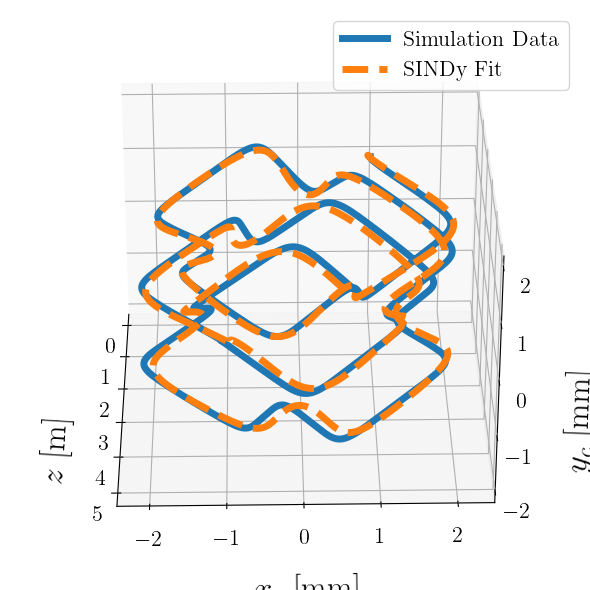

In [91]:
# get azimuthal thing to make movie from images from the LANL laptop
import matplotlib as mpl
COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
fig = plt.figure(figsize=(GR*6,6))
ax = fig.add_subplot(projection='3d')
zidx = 1000

sc = ax.plot(XY[:zidx,0], 1000* XY[:zidx,1], 1000*XY[:zidx,2],color=colors[0],linewidth=5.0,label="Simulation Data")
sc2 = ax.plot(sim[:zidx,0], 1000*sim[:zidx,1], 1000*sim[:zidx,2],color=colors[1],linewidth=5.0,linestyle='--',label='SINDy Fit')

ax.set_xlabel(r'$z$ [m]',fontsize=label_size,labelpad=20)
ax.set_ylabel(r'$x_c$ [mm]',fontsize=label_size,labelpad=20)
ax.set_zlabel(r'$y_c$ [mm]',fontsize=label_size,labelpad=20)
ax.tick_params(axis='x', labelsize=tick_size) 
ax.tick_params(axis='y', labelsize=tick_size) 
ax.tick_params(axis='z', labelsize=tick_size) 
ax.legend(fontsize=leg_size)
plt.tight_layout()
# ax.view_init(elev=30., azim=90)
elev = 30
plt.savefig("./figures/3D_scatter_plot_result.png",dpi=200,transparent=True)
for ii in range(0,360,1):
        ax.view_init(elev=elev, azim=ii)
        plt.savefig("./movie/movie%d.png" % ii,dpi=200,transparent=False)
plt.show()

### Autocorrelation and Fourier Transform magnitude

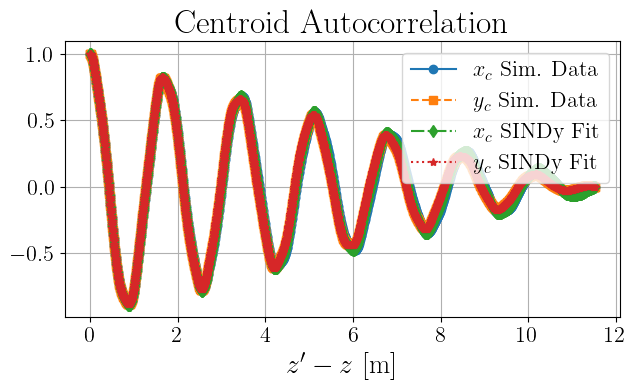

In [92]:
corr_x = np.correlate(XY[:,1], XY[:,1],mode='full')
corr_x = corr_x/(np.sum((XY[:,1])**2))

corr_y = np.correlate(XY[:,2], XY[:,2],mode='full')
corr_y = corr_y/(np.sum((XY[:,2])**2))

corr_x_s = np.correlate(sim[:,1], sim[:,1],mode='full')
corr_x_s = corr_x_s/(np.sum((sim[:,1])**2))

corr_y_s = np.correlate(sim[:,2], sim[:,2],mode='full')
corr_y_s = corr_y_s/(np.sum((sim[:,2])**2))

plt.figure(figsize=(GR*4,4))
plt.plot(z,corr_x[int(len(corr_x)/2):],'-o',color=colors[0],label=r"$x_c$ Sim. Data")
plt.plot(z,corr_y[int(len(corr_y)/2):],'--s',color=colors[1],label=r"$y_c$ Sim. Data")
plt.plot(z,corr_x_s[int(len(corr_y)/2):],'-.d',color=colors[2],label=r"$x_c$ SINDy Fit")
plt.plot(z,corr_y_s[int(len(corr_y)/2):],':*',color=colors[3],label=r"$y_c$ SINDy Fit")
plt.grid(True)
plt.xlabel(r"$z'-z$ [m]",fontsize=20)
plt.title(r'Centroid Autocorrelation',fontsize=24)
plt.legend(loc='best',fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.tight_layout()
plt.savefig("./figures/xc_yc_NonlinearFourier_Autocorr.png",dpi=200,transparent=True)
plt.show()

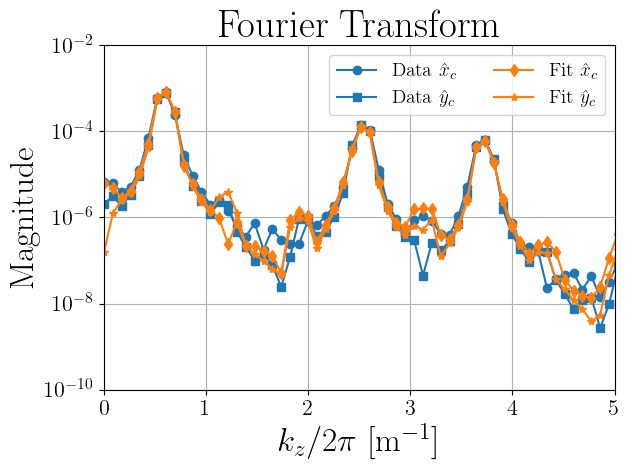

In [93]:
plt.figure()
plt.grid(True)
plt.magnitude_spectrum(XY[:,1], Fs=1.0/dz, color=colors[0],marker="o",label=r"Data $\hat{x}_c$")
plt.magnitude_spectrum(XY[:,2], Fs=1.0/dz, color=colors[0],marker="s",label=r"Data $\hat{y}_c$")
plt.magnitude_spectrum(sim[:,1], Fs=1.0/dz, color=colors[1],marker="d",label=r"Fit $\hat{x}_c$")
plt.magnitude_spectrum(sim[:,2], Fs=1.0/dz, color=colors[1],marker="*",label=r"Fit $\hat{y}_c$")
plt.yscale("log")
plt.xlabel(r"$k_z/2 \pi$ [m$^{-1}$]",fontsize=label_size)
plt.ylabel(r"Magnitude",fontsize=label_size)
plt.title(r"Fourier Transform",fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc='best',fontsize=14,ncol=2)
plt.xlim([0,5])
plt.ylim([1e-10,1e-2])
plt.tight_layout()
plt.savefig("./figures/xc_yc_NonlinearFourier_Fourier_Trans.pdf",dpi=200,transparent=True)
plt.show()

### Now predict things!

In [94]:
# load and moving average the dataset
pos_turns = np.loadtxt("pos_turns.txt")

x_c10_turns = uniform_filter1d(pos_turns[:,1],size=10,axis=0,mode='nearest')
y_c10_turns = uniform_filter1d(pos_turns[:,2],size=10,axis=0,mode='nearest')

XY_turns = np.array([pos_turns[:,0],x_c10_turns,y_c10_turns]).T

zlen = pos.shape[0]

last_idx = -4
[z0,x0,y0] = XY_turns[0,:]
[z01,x01,y01] = XY_turns[zlen,:]
[z02,x02,y02] = XY_turns[2*zlen,:]
[z03,x03,y03] = XY_turns[3*zlen,:]
[z04,x04,y04] = XY_turns[4*zlen,:]

In [95]:
sim_turns0 = model.simulate([z0,x0, y0], t=pos_turns[:zlen,0])
sim_turns1 = model.simulate([z01,x01, y01], t=pos_turns[zlen:2*zlen,0])
sim_turns2 = model.simulate([z02,x02, y02], t=pos_turns[2*zlen:3*zlen,0])
sim_turns3 = model.simulate([z03,x03, y03], t=pos_turns[3*zlen:4*zlen,0])
sim_turns4 = model.simulate([z04,x04, y04], t=pos_turns[4*zlen:last_idx,0])

sim_turns_all = model.simulate([z0,x0, y0], t=pos_turns[:last_idx,0])

In [96]:
sim_turns = np.append(sim_turns0,sim_turns1,axis=0)
sim_turns = np.append(sim_turns,sim_turns2,axis=0)
sim_turns = np.append(sim_turns,sim_turns3,axis=0)
sim_turns = np.append(sim_turns,sim_turns4,axis=0)

sim_turns.shape

(11521, 3)

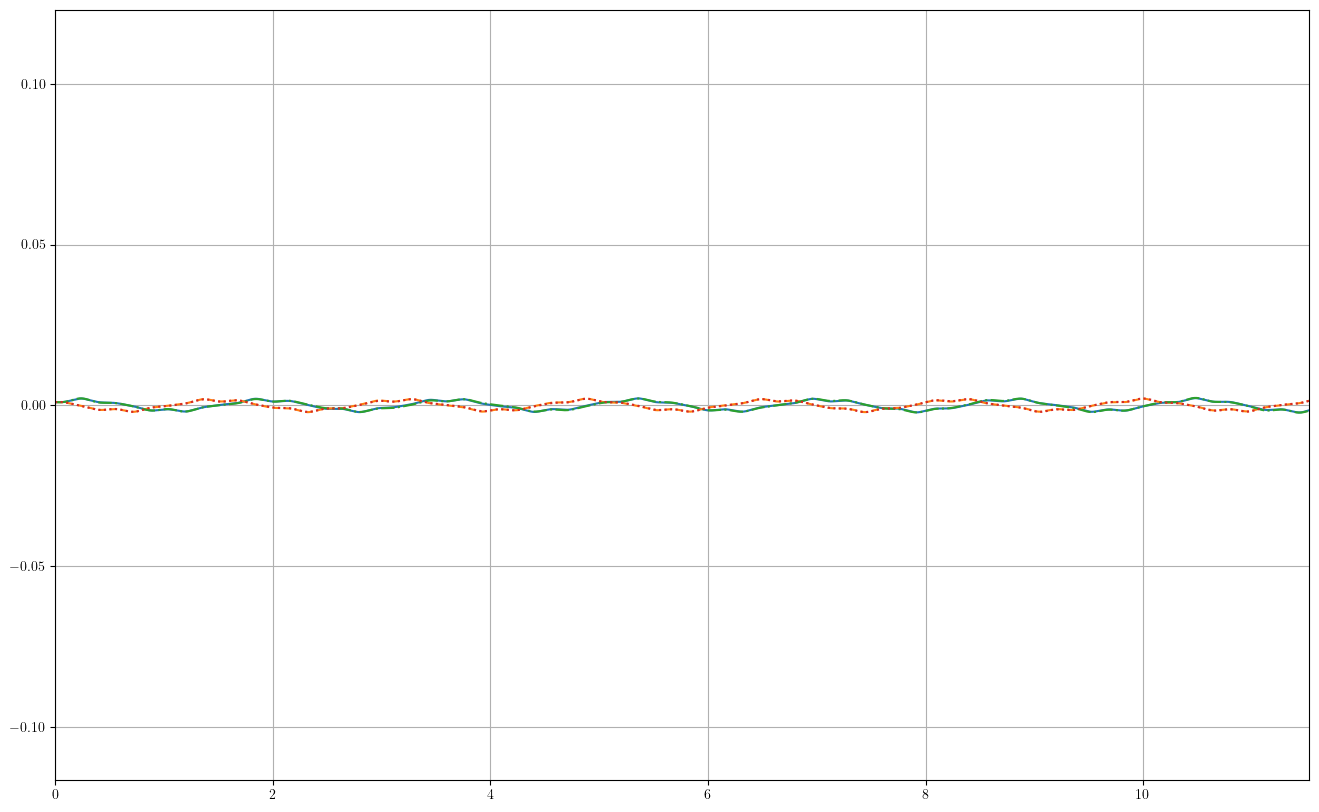

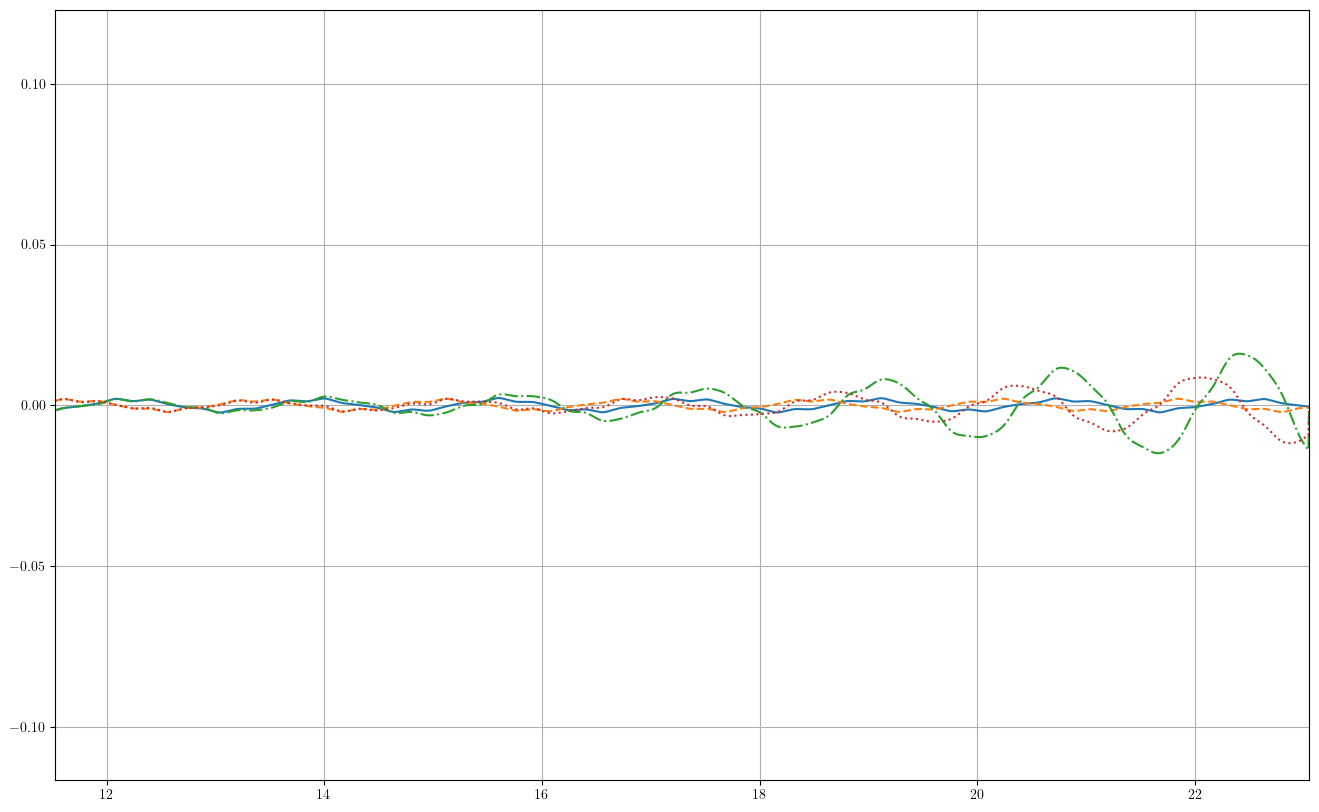

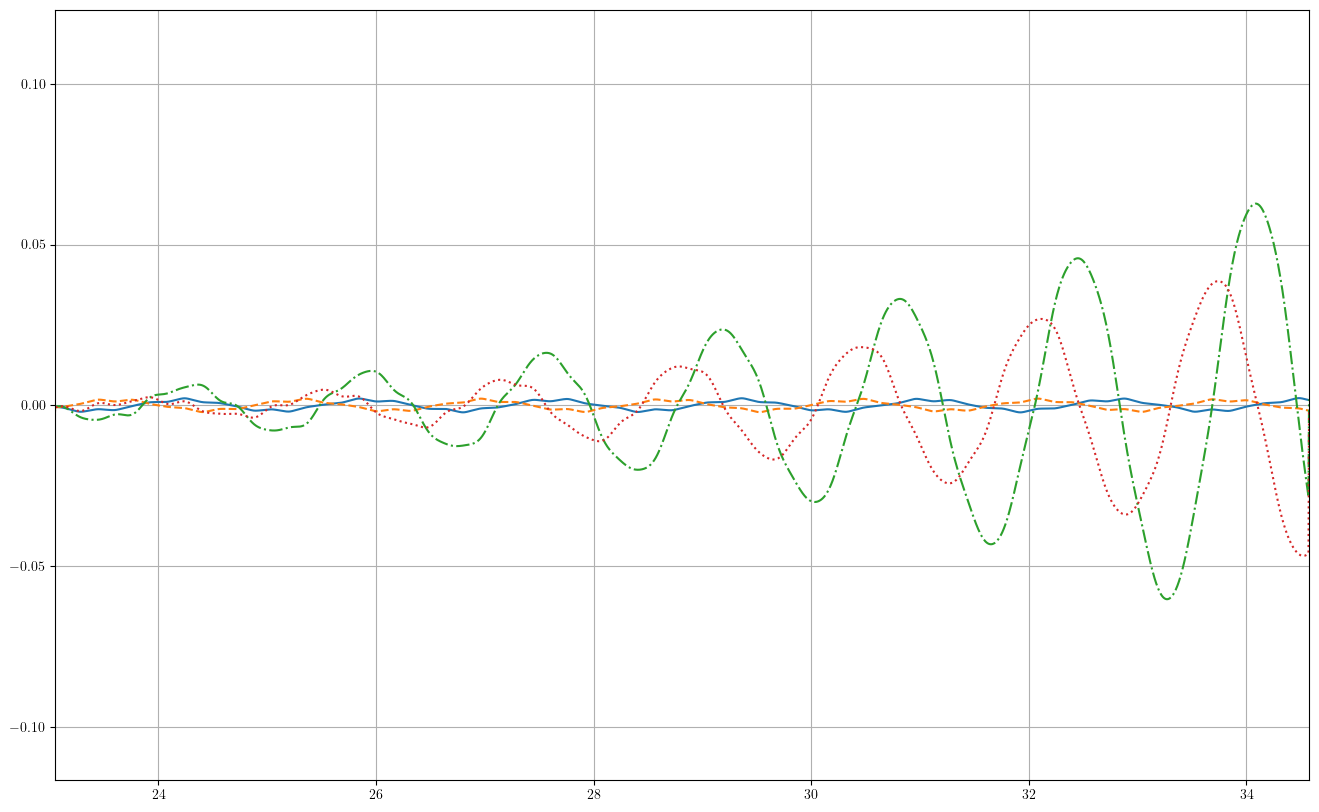

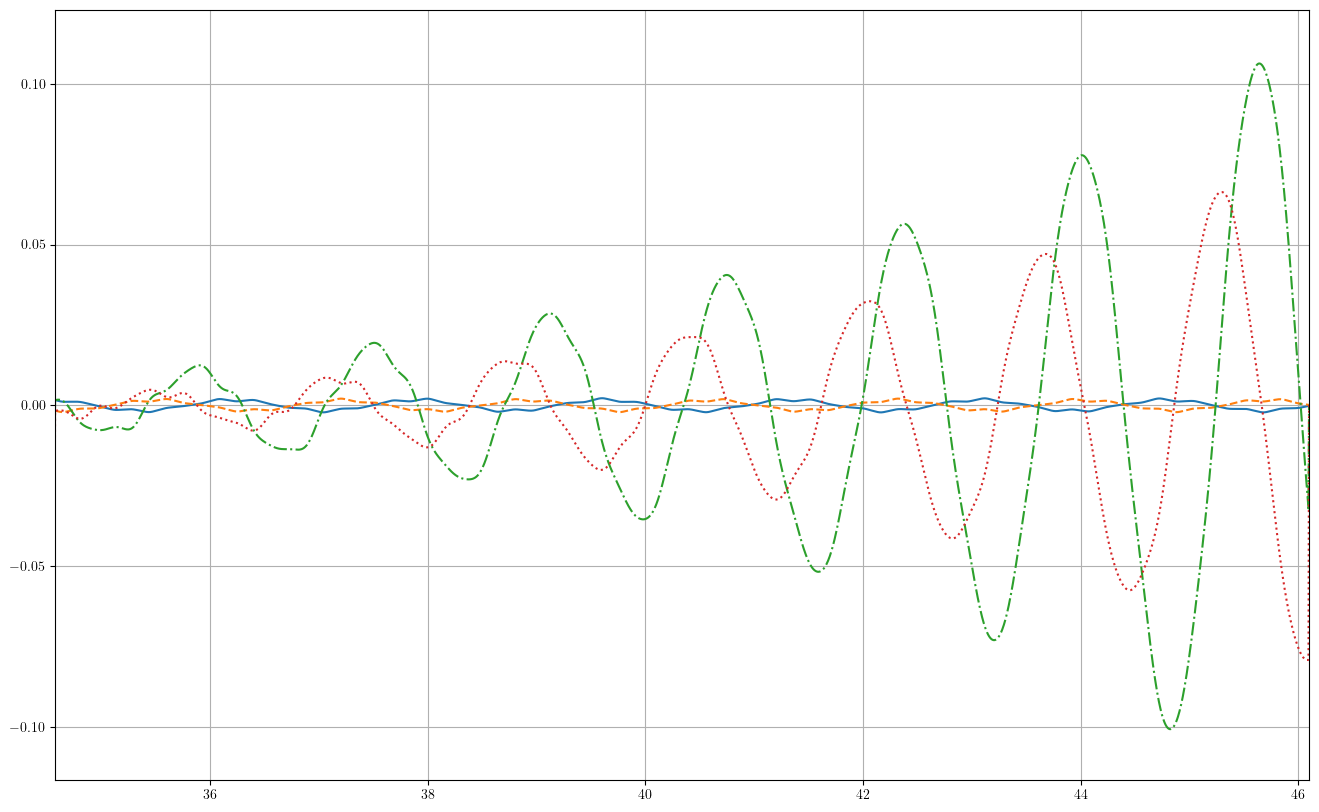

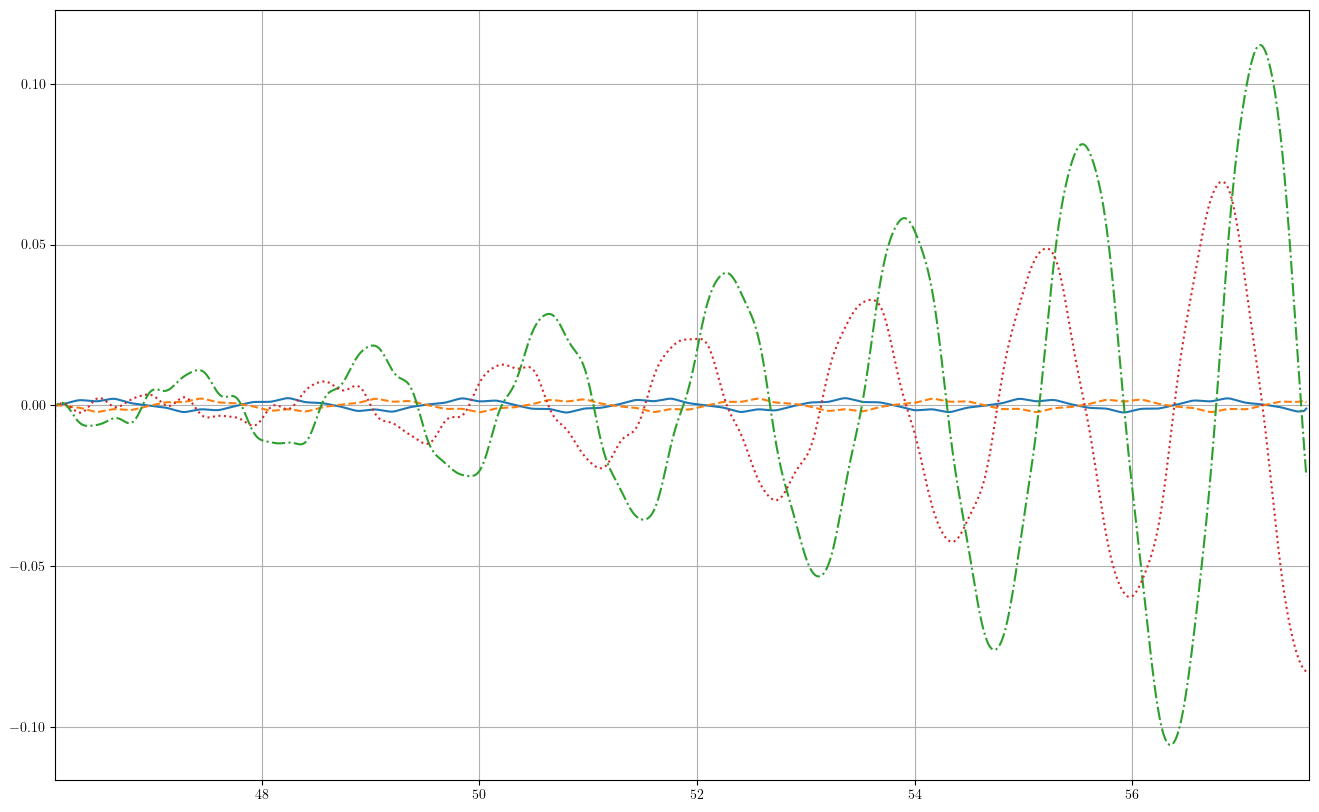

In [97]:
xidx = 1
yidx = 2

plt.figure(figsize=(10*GR,10))
plt.plot(XY_turns[:last_idx,0],XY_turns[:last_idx,xidx],'-')
plt.plot(XY_turns[:last_idx,0],XY_turns[:last_idx,yidx],'--')
plt.plot(sim_turns[:,0],sim_turns[:,xidx],'-.')
plt.plot(sim_turns[:,0],sim_turns[:,yidx],':')
plt.xlim([0, z01])
plt.grid(True)
plt.show()

plt.figure(figsize=(10*GR,10))
plt.plot(XY_turns[:last_idx,0],XY_turns[:last_idx,xidx],'-')
plt.plot(XY_turns[:last_idx,0],XY_turns[:last_idx,yidx],'--')
plt.plot(sim_turns[:,0],sim_turns[:,xidx],'-.')
plt.plot(sim_turns[:,0],sim_turns[:,yidx],':')
plt.xlim([z01, z02])
plt.grid(True)
plt.show()

plt.figure(figsize=(10*GR,10))
plt.plot(XY_turns[:last_idx,0],XY_turns[:last_idx,xidx],'-')
plt.plot(XY_turns[:last_idx,0],XY_turns[:last_idx,yidx],'--')
plt.plot(sim_turns[:,0],sim_turns[:,xidx],'-.')
plt.plot(sim_turns[:,0],sim_turns[:,yidx],':')
plt.xlim([z02, z03])
plt.grid(True)
plt.show()

plt.figure(figsize=(10*GR,10))
plt.plot(XY_turns[:last_idx,0],XY_turns[:last_idx,xidx],'-')
plt.plot(XY_turns[:last_idx,0],XY_turns[:last_idx,yidx],'--')
plt.plot(sim_turns[:,0],sim_turns[:,xidx],'-.')
plt.plot(sim_turns[:,0],sim_turns[:,yidx],':')
plt.xlim([z03, z04])
plt.grid(True)
plt.show()

plt.figure(figsize=(10*GR,10))
plt.plot(XY_turns[:last_idx,0],XY_turns[:last_idx,xidx],'-')
plt.plot(XY_turns[:last_idx,0],XY_turns[:last_idx,yidx],'--')
plt.plot(sim_turns[:,0],sim_turns[:,xidx],'-.')
plt.plot(sim_turns[:,0],sim_turns[:,yidx],':')
plt.xlim([z04, z04+z01])
plt.grid(True)
plt.show()

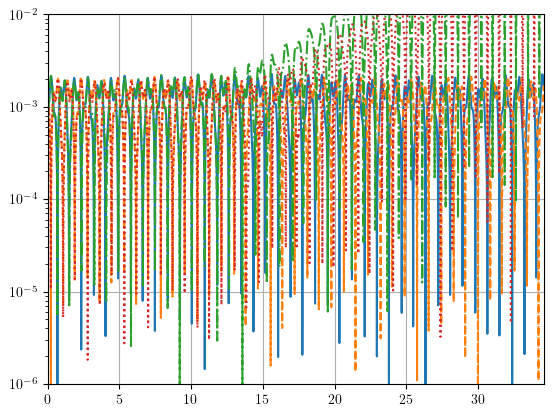

In [98]:
plt.figure()
plt.plot(XY_turns[:last_idx,0],np.abs(XY_turns[:last_idx,xidx]),'-')
plt.plot(XY_turns[:last_idx,0],np.abs(XY_turns[:last_idx,yidx]),'--')
plt.plot(sim_turns_all[:,0],np.abs(sim_turns_all[:,xidx]),'-.')
plt.plot(sim_turns_all[:,0],np.abs(sim_turns_all[:,yidx]),':')
plt.xlim([0.0,z03])
plt.ylim([1e-6,1e-2])
plt.yscale("log")
plt.grid(True)
plt.show()

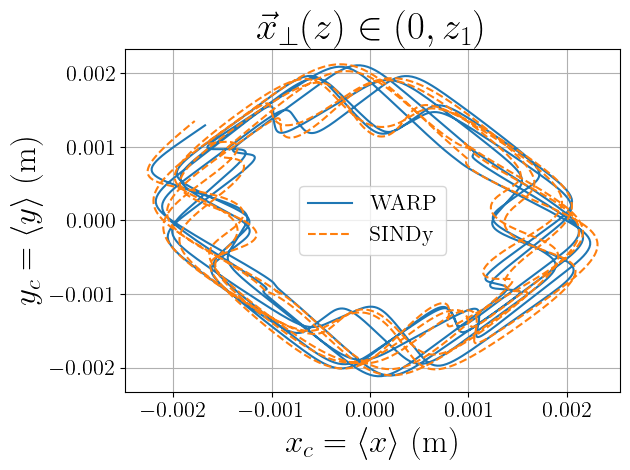

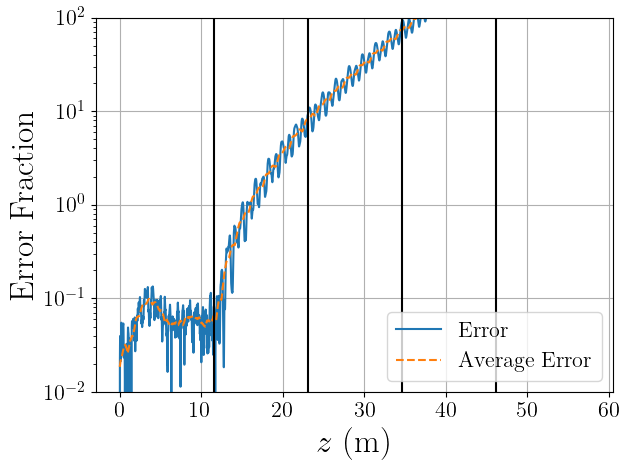

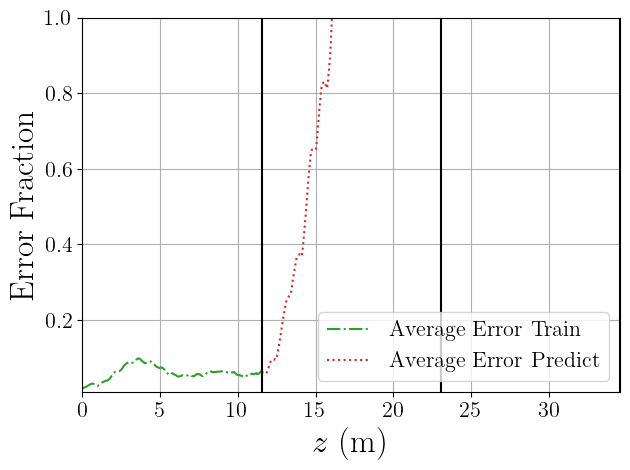

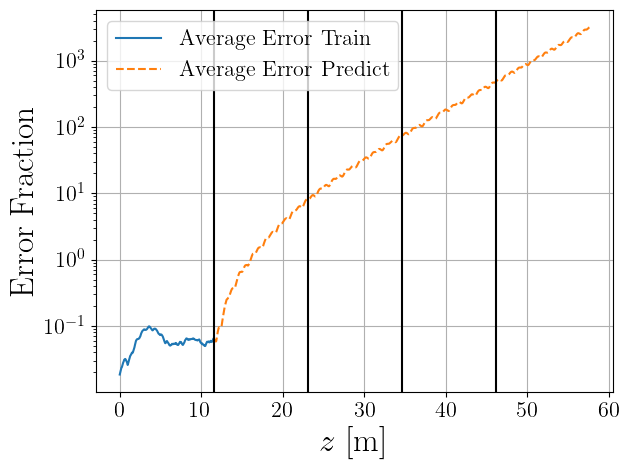

In [99]:
zidx = -1
ms_size = 0.5
t1idx = pos.shape[0]

plt.figure()
plt.plot(XY[:zidx,xidx],XY[:zidx,yidx],'-',ms=ms_size,label=r'WARP')
plt.plot(sim[:zidx,xidx],sim[:zidx,yidx],'--',ms=ms_size,label=r'SINDy')
# plt.plot(err[:zidx,xidx],err[:zidx,yidx],'-.',label=r'Error')
plt.xlabel(r"$x_c = \langle x \rangle$ (m)",fontsize=label_size)
plt.ylabel(r"$y_c = \langle y \rangle$ (m)",fontsize=label_size)
plt.title(r"$\vec{x}_{\perp}(z)\in(0,z_1)$",fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc='best',fontsize=leg_size)
plt.tight_layout()
plt.grid(True)
plt.tight_layout()
plt.savefig("./figures/3D_SINDy_Trace_Space_Physics_Reproduce.pdf",dpi=1000,transparent=True)
plt.show()

# plot the error
err = XY_turns[:last_idx,:] - sim_turns_all
xperp_err = np.sqrt( err[:,xidx]**2 + err[:,yidx]**2)/np.sqrt( np.var(XY_turns[:last_idx,xidx]) + np.var(XY_turns[:last_idx,yidx]))

# moving average of bouncy error
xperp_err_ave = uniform_filter1d(xperp_err,size=200,axis=0,mode='nearest')

plt.figure()
plt.plot(sim_turns[:zidx,0],xperp_err[:zidx],label=r'Error')
plt.plot(sim_turns[:zidx,0],xperp_err_ave[:zidx],'--',label=r'Average Error')
plt.axvline(z01,color="black")
plt.axvline(z02,color="black")
plt.axvline(z03,color="black")
plt.axvline(z04,color="black")
plt.xlabel(r"$z$ (m)",fontsize=label_size)
plt.ylabel(r"Error Fraction",fontsize=label_size)
# plt.title(r"Solution Plot of $z\in(0,%.2f)$"%(pos[:,0][zidx]),fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc='best',fontsize=leg_size)
# plt.xlim([0,z03])
plt.ylim([0.01,100])
plt.yscale("log")
plt.grid(True)
plt.tight_layout()
plt.savefig("./figures/3D_SINDy_Error_5Turns_Physics_Reproduce.pdf",dpi=1000,transparent=True)
plt.show()

plt.figure()
plt.plot(sim_turns[:t1idx,0],xperp_err_ave[:t1idx],color=colors[2],linestyle='-.',label=r'Average Error Train')
plt.plot(sim_turns[t1idx:zidx,0],xperp_err_ave[t1idx:zidx],color=colors[3],linestyle=':',label=r'Average Error Predict')
plt.axvline(z01,color="black")
plt.axvline(z02,color="black")
plt.axvline(z03,color="black")
plt.axvline(z04,color="black")
plt.xlim([0,z03])
plt.ylim([0.01,1])
# plt.yscale("log")
plt.xlabel(r"$z$ (m)",fontsize=label_size)
plt.ylabel(r"Error Fraction",fontsize=label_size)
# plt.title(r"Solution Plot of $z\in(0,%.2f)$"%(pos[:,0][zidx]),fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc='best',fontsize=leg_size)
plt.grid(True)
plt.tight_layout()
plt.savefig("./figures/3D_SINDy_Error_3Turns_Physics_Reproduce.png",dpi=200,transparent=True)
plt.show()

plt.figure()
plt.plot(sim_turns[:t1idx,0],xperp_err_ave[:t1idx],color=colors[0],linestyle='-',label=r'Average Error Train')
plt.plot(sim_turns[t1idx:zidx,0],xperp_err_ave[t1idx:zidx],color=colors[1],linestyle='--',label=r'Average Error Predict')
plt.axvline(z01,color="black")
plt.axvline(z02,color="black")
plt.axvline(z03,color="black")
plt.axvline(z04,color="black")
# plt.xlim([0,z03])
# plt.ylim([0.01,1])
plt.yscale("log")
plt.xlabel(r"$z$ [m]",fontsize=label_size)
plt.ylabel(r"Error Fraction",fontsize=label_size)
# plt.title(r"Solution Plot of $z\in(0,%.2f)$"%(pos[:,0][zidx]),fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc='best',fontsize=leg_size)
plt.grid(True)
plt.tight_layout()
# plt.savefig("./figures/3D_SINDy_Error_3Turns_Physics_Reproduce.png",dpi=200,transparent=True)
plt.show()

### Now get thresholds and alpha value paramater space mapping for R^2 and coeffcient values

Good values pairs
(threshold,alpha) = (,)
 
(0.001,0.25) just has an offset for some reason

(0.0,0.1) best overall fit but prediction is crap/not stable linear growth away from the actual needed value

(0.0001,0.2) get a bunch of spurios peaks but has better prediciton than (0.0001,0.1)

(0.0001,0.05) plot for better error than the "best" training fit

(z)' = 1.000 1
(x_c)' = -0.490 x_c + 5.908 y_c + -0.001 cos(k_0 z) + -0.001 cos(k_1 z) + -0.001 cos(k_2 z) + 0.002 sin(k_0 z) + 0.001 sin(k_1 z) + -0.002 sin(k_2 z) + -0.001 1 cos(k_0 z) + -0.001 1 cos(k_1 z) + -0.001 1 cos(k_2 z) + 0.002 1 sin(k_0 z) + 0.001 1 sin(k_1 z) + -0.002 1 sin(k_2 z) + 0.001 z cos(k_2 z) + 0.078 x_c cos(k_0 z) + 0.061 x_c cos(k_1 z) + 0.088 x_c cos(k_2 z) + -0.105 x_c sin(k_0 z) + 0.046 x_c sin(k_1 z) + -0.014 x_c sin(k_2 z) + -0.073 y_c cos(k_0 z) + 0.005 y_c cos(k_1 z) + -0.019 y_c cos(k_2 z) + -0.040 y_c sin(k_0 z) + 0.121 y_c sin(k_1 z) + -0.097 y_c sin(k_2 z)
(y_c)' = -2.622 x_c + 0.826 y_c + -0.001 cos(k_0 z) + 0.002 cos(k_1 z) + 0.001 cos(k_2 z) + 0.002 sin(k_1 z) + -0.001 sin(k_2 z) + -0.001 1 cos(k_0 z) + 0.002 1 cos(k_1 z) + 0.001 1 cos(k_2 z) + 0.002 1 sin(k_1 z) + -0.001 1 sin(k_2 z) + 0.184 x_c cos(k_0 z) + 0.045 x_c cos(k_1 z) + 0.027 x_c cos(k_2 z) + 0.123 x_c sin(k_0 z) + 0.038 x_c sin(k_1 z) + -0.005 x_c sin(k_2 z) + 0.088 y_c cos(k_0 z) + 0.

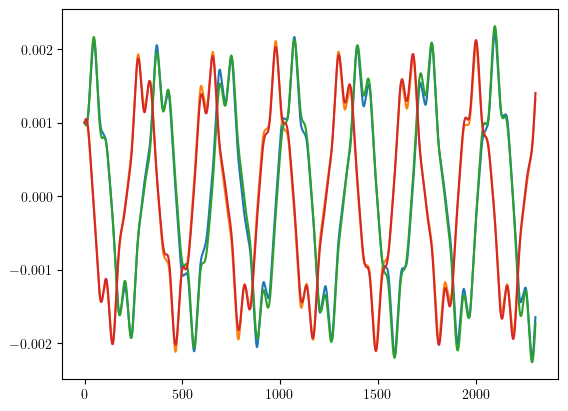

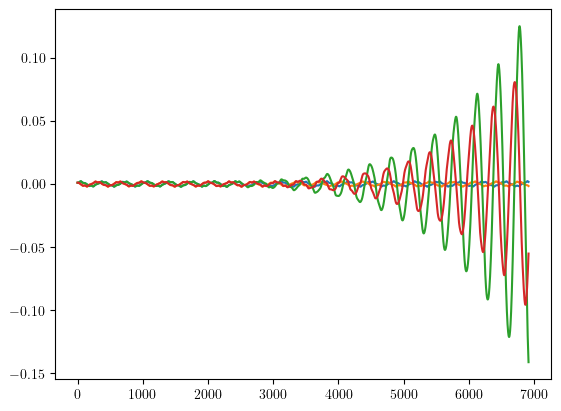

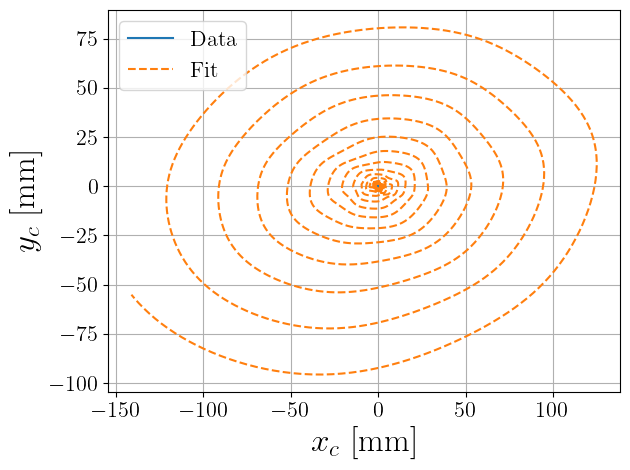

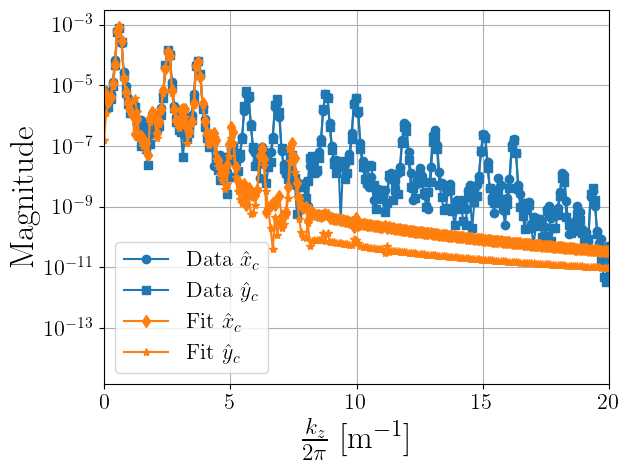

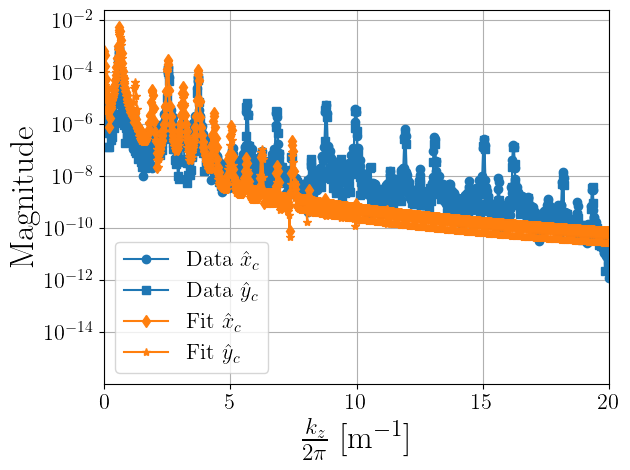

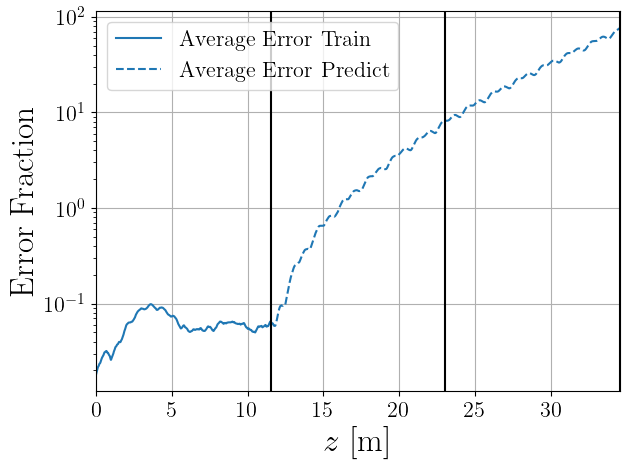

In [100]:
turn1 = pos.shape[0]
turn2 = int(pos_turns.shape[0]*0.4)
turn3 = int(pos_turns.shape[0]*0.6)
# r2xmat = np.zeros(Ntest)
# r2ymat = np.zeros(Ntest)

# r2xmat_P2 = np.zeros(Ntest)
# r2ymat_P2 = np.zeros(Ntest)

# r2xmat_P3 = np.zeros(Ntest)
# r2ymat_P3 = np.zeros(Ntest)

# scan variables
threshold = 0.000
alpha = 0.1

# get coefs
coefs = []
# xperp_err_mat = np.empty()

opt = ps.STLSQ(threshold=threshold,alpha=alpha)
model = ps.SINDy(feature_library=generalized_library,
         optimizer=opt,
         feature_names=["z","x_c", "y_c"])

model.fit(XY, t=dz,quiet=True) # fit
coefs.append(model.coefficients()) # append coefficients

model.print()

[z0,x0,y0] = XY[0,:]
sim = model.simulate([z0,x0, y0], t=XY[:,0])
err = XY - sim # error

# get error for training
# np.sum(err[:,1:]**2,axis=0)/np.sum((XY[:,1:] - np.mean(XY[:,1:],axis=0))**2,axis=0)
[r2x,r2y] = 1 - np.sum(err[:,1:]**2,axis=0)/np.sum((XY[:,1:] - np.mean(XY[:,1:],axis=0))**2,axis=0)
print(r2x,r2y)
# r2ymat = 1 - np.var(err[:,2])/(np.var(XY[:,2]))

# now prediction
sim_turns_all = model.simulate([z0,x0, y0], t=pos_turns[:turn3,0])

np.savetxt("case1.txt",sim_turns_all,delimiter=',')

# error for prediction over 3 turns
errt2 = XY_turns[:turn2,:] - sim_turns_all[:turn2,:]
errt3 = XY_turns[:turn3,:] - sim_turns_all[:turn3,:]
xperp_err = np.sqrt( errt3[:,xidx]**2 + errt3[:,yidx]**2)/np.sqrt( np.var(XY_turns[:turn3,xidx]) + np.var(XY_turns[:turn3,yidx]))
# moving average of bouncy error
xperp_err_ave = uniform_filter1d(xperp_err,size=200,axis=0,mode='nearest')
xperp_err_ave_case1 = xperp_err_ave
# if it == 0:
#     xperp_err_mat = np.append([xperp_err_ave],[xperp_err_ave],axis=0)
# else:
#     xperp_err_mat = np.append(xperp_err_mat,[xperp_err_ave],axis=0)

# get error for predicting up to turn 2
[r2x_P2,r2y_P2] = 1 - np.sum(errt2[:,1:]**2,axis=0)/np.sum((XY_turns[:turn2,1:] - np.mean(XY_turns[:turn2,1:],axis=0))**2,axis=0)
print("Turn 2 R^2 x: ", r2x_P2)
print("Turn 2 R^2 y: ", r2y_P2)
# get error for predicting up to turn 3
[r2x_P3,r2y_P3] = 1 - np.sum(errt3[:,1:]**2,axis=0)/np.sum((XY_turns[:turn3,1:] - np.mean(XY_turns[:turn3,1:],axis=0))**2,axis=0)
print("Turn 3 R^2 x: ", r2x_P3)
print("Turn 3 R^2 y: ", r2y_P3)

#print("Turn 1 <x> Data",np.mean(XY_turns[:turn1,1:],axis=0))
#print("Turn 1 <x> Sim",np.mean(sim_turns_all[:turn1,1:],axis=0))
print("Turn 1 <x> # Diff: ",(np.mean(sim_turns_all[:turn1,1:],axis=0)-np.mean(XY_turns[:turn1,1:],axis=0))/np.mean(XY_turns[:turn1,1:],axis=0))

#print("Turn 2 <x> Data",np.mean(XY_turns[:turn2,1:],axis=0))
#print("Turn 2 <x> Sim",np.mean(sim_turns_all[:turn2,1:],axis=0))
print("Turn 2 <x> # Diff: ",(np.mean(sim_turns_all[:turn2,1:],axis=0)-np.mean(XY_turns[:turn2,1:],axis=0))/np.mean(XY_turns[:turn2,1:],axis=0))

#print("Turn 3 <x> Data",np.mean(XY_turns[:turn3,1:],axis=0))
#print("Turn 3 <x> Sim",np.mean(sim_turns_all[:turn3,1:],axis=0))
print("Turn 3 <x> # Diff: ",(np.mean(sim_turns_all[:turn3,1:],axis=0)-np.mean(XY_turns[:turn3,1:],axis=0))/np.mean(XY_turns[:turn3,1:],axis=0))

#print("Turn 1 <x^2> Data",np.var(XY_turns[:turn1,1:],axis=0))
#print("Turn 1 <x^2> Sim",np.var(sim_turns_all[:turn1,1:],axis=0))
print("Turn 1 <x^2> # Diff: ",(np.var(sim_turns_all[:turn1,1:],axis=0)-np.var(XY_turns[:turn1,1:],axis=0))/np.var(XY_turns[:turn1,1:],axis=0))

#print("Turn 2 <x^2> Data",np.var(XY_turns[:turn2,1:],axis=0))
#print("Turn 2 <x^2> Sim",np.var(sim_turns_all[:turn2,1:],axis=0))
print("Turn 2 <x^2> # Diff: ",(np.var(sim_turns_all[:turn2,1:],axis=0)-np.var(XY_turns[:turn2,1:],axis=0))/np.var(XY_turns[:turn2,1:],axis=0))

#print("Turn 3 <x^2> Data",np.var(XY_turns[:turn3,1:],axis=0))
#print("Turn 3 <x^2> Sim",np.var(sim_turns_all[:turn3,1:],axis=0))
print("Turn 3 <x^2> # Diff: ",(np.var(sim_turns_all[:turn3,1:],axis=0)-np.var(XY_turns[:turn3,1:],axis=0))/np.var(XY_turns[:turn3,1:],axis=0))

# get centroid of data vs fit for training and up to turn2 and up to turn3
np.mean(sim_turns_all[:turn2,1:],axis=0)

# does the beam have the centroid of the centroid and the 2nd moment of the distribution for the centroid dynamics

plt.figure()
plt.plot(XY[:,1])
plt.plot(XY[:,2])
plt.plot(sim[:,1])
plt.plot(sim[:,2])
plt.show()

plt.figure()
plt.plot(pos_turns[:turn3,1])
plt.plot(pos_turns[:turn3,2])
plt.plot(sim_turns_all[:,1])
plt.plot(sim_turns_all[:,2])
plt.show()

plt.figure()
plt.plot(pos_turns[:turn3,1]*1000,pos_turns[:turn3,2]*1000,label='Data')
plt.plot(sim_turns_all[:,1]*1000,sim_turns_all[:,2]*1000,label=r'Fit',linestyle='--')
plt.xlabel(r"$x_c$ [mm]",fontsize=label_size)
plt.ylabel(r"$y_c$ [mm]",fontsize=label_size)
# plt.title(r"Solution Plot of $z\in(0,z_1)$",fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc='best',fontsize=leg_size)
plt.tight_layout()
plt.grid(True)
plt.savefig("./figures/Case1_Phase_Space.pdf",dpi=200,transparent=True)
plt.show()
plt.show()

plt.figure()
plt.grid(True)
plt.magnitude_spectrum(XY[:,1], Fs=1.0/dz, color=colors[0],marker="o",label=r"Data $\hat{x}_c$")
plt.magnitude_spectrum(XY[:,2], Fs=1.0/dz, color=colors[0],marker="s",label=r"Data $\hat{y}_c$")
plt.magnitude_spectrum(sim[:,1], Fs=1.0/dz, color=colors[1],marker="d",label=r"Fit $\hat{x}_c$")
plt.magnitude_spectrum(sim[:,2], Fs=1.0/dz, color=colors[1],marker="*",label=r"Fit $\hat{y}_c$")
plt.yscale("log")
plt.xlabel(r"$\frac{k_z}{2 \pi}$ [m$^{-1}$]",fontsize=label_size)
plt.ylabel(r"Magnitude",fontsize=label_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc='best',fontsize=leg_size)
plt.xlim([0,20])
# plt.ylim([1e-10,1e-2])
plt.tight_layout()
# plt.savefig("./figures/xc_yc_NonlinearFourier_Fourier_Trans.pdf",dpi=200,transparent=True)
plt.show()

plt.figure()
plt.grid(True)
plt.magnitude_spectrum(XY_turns[:turn3,1], Fs=1.0/dz, color=colors[0],marker="o",label=r"Data $\hat{x}_c$")
plt.magnitude_spectrum(XY_turns[:turn3,2], Fs=1.0/dz, color=colors[0],marker="s",label=r"Data $\hat{y}_c$")
plt.magnitude_spectrum(sim_turns_all[:,1], Fs=1.0/dz, color=colors[1],marker="d",label=r"Fit $\hat{x}_c$")
plt.magnitude_spectrum(sim_turns_all[:,2], Fs=1.0/dz, color=colors[1],marker="*",label=r"Fit $\hat{y}_c$")
plt.yscale("log")
plt.xlabel(r"$\frac{k_z}{2 \pi}$ [m$^{-1}$]",fontsize=label_size)
plt.ylabel(r"Magnitude",fontsize=label_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc='best',fontsize=leg_size)
plt.xlim([0,20])
# plt.ylim([1e-10,1e-2])
plt.tight_layout()
# plt.savefig("./figures/xc_yc_NonlinearFourier_Fourier_Trans.pdf",dpi=200,transparent=True)
plt.show()

plt.figure()
plt.plot(sim_turns_all[:turn1,0],xperp_err_ave[:turn1],color=colors[0],linestyle='-',label=r'Average Error Train')
plt.plot(sim_turns_all[turn1:turn3,0],xperp_err_ave[turn1:turn3],color=colors[0],linestyle='--',label=r'Average Error Predict')
plt.axvline(z01,color="black")
plt.axvline(z02,color="black")
plt.axvline(z03,color="black")
plt.axvline(z04,color="black")
plt.xlim([0,z03])
# plt.ylim([0.01,1])
plt.yscale("log")
plt.xlabel(r"$z$ [m]",fontsize=label_size)
plt.ylabel(r"Error Fraction",fontsize=label_size)
# plt.title(r"Solution Plot of $z\in(0,%.2f)$"%(pos[:,0][zidx]),fontsize=title_size)
plt.tick_params(axis = 'both', labelsize=tick_size)
plt.legend(loc='best',fontsize=leg_size)
plt.grid(True)
plt.tight_layout()
# plt.savefig("./figures/3D_SINDy_Error_3Turns_Physics_Reproduce.png",dpi=200,transparent=True)
plt.show()

In [101]:
# turn1 = pos.shape[0]
# turn2 = int(pos_turns.shape[0]*0.4)
# turn3 = int(pos_turns.shape[0]*0.6)
# # r2xmat = np.zeros(Ntest)
# # r2ymat = np.zeros(Ntest)

# # r2xmat_P2 = np.zeros(Ntest)
# # r2ymat_P2 = np.zeros(Ntest)

# # r2xmat_P3 = np.zeros(Ntest)
# # r2ymat_P3 = np.zeros(Ntest)

# # scan variables
# threshold = 0.001
# alpha = 0.25

# # get coefs
# coefs = []
# # xperp_err_mat = np.empty()

# opt = ps.STLSQ(threshold=threshold,alpha=alpha)
# model = ps.SINDy(feature_library=generalized_library,
#          optimizer=opt,
#          feature_names=["z","x_c", "y_c"])

# model.fit(XY, t=dz,quiet=True) # fit
# coefs.append(model.coefficients()) # append coefficients

# model.print()

# DAT = np.column_stack(
#         (np.array(model.get_feature_names())
#     ,model.coefficients()[1]) )
# np.savetxt("Case2_xc.txt",DAT,delimiter=" ", fmt="%s")

# DAT = np.column_stack(
#         (np.array(model.get_feature_names())
#     ,model.coefficients()[2]) )
# np.savetxt("Case2_yc.txt",DAT,delimiter=" ", fmt="%s")

# [z0,x0,y0] = XY[0,:]
# sim = model.simulate([z0,x0, y0], t=XY[:,0])
# err = XY - sim # error

# # get error for training
# # np.sum(err[:,1:]**2,axis=0)/np.sum((XY[:,1:] - np.mean(XY[:,1:],axis=0))**2,axis=0)
# [r2x,r2y] = 1 - np.sum(err[:,1:]**2,axis=0)/np.sum((XY[:,1:] - np.mean(XY[:,1:],axis=0))**2,axis=0)
# print(r2x,r2y)
# # r2ymat = 1 - np.var(err[:,2])/(np.var(XY[:,2]))

# # now prediction
# sim_turns_all = model.simulate([z0,x0, y0], t=pos_turns[:turn3,0])

# np.savetxt("case2.txt",sim_turns_all,delimiter=',')

# # error for prediction over 3 turns
# errt2 = XY_turns[:turn2,:] - sim_turns_all[:turn2,:]
# errt3 = XY_turns[:turn3,:] - sim_turns_all[:turn3,:]
# xperp_err = np.sqrt( errt3[:,xidx]**2 + errt3[:,yidx]**2)/np.sqrt( np.var(XY_turns[:turn3,xidx]) + np.var(XY_turns[:turn3,yidx]))
# # moving average of bouncy error
# xperp_err_ave = uniform_filter1d(xperp_err,size=200,axis=0,mode='nearest')
# xperp_err_ave_case2 = xperp_err_ave
# # if it == 0:
# #     xperp_err_mat = np.append([xperp_err_ave],[xperp_err_ave],axis=0)
# # else:
# #     xperp_err_mat = np.append(xperp_err_mat,[xperp_err_ave],axis=0)

# # get error for predicting up to turn 2
# [r2x_P2,r2y_P2] = 1 - np.sum(errt2[:,1:]**2,axis=0)/np.sum((XY_turns[:turn2,1:] - np.mean(XY_turns[:turn2,1:],axis=0))**2,axis=0)
# print("Turn 2 R^2 x: ", r2x_P2)
# print("Turn 2 R^2 y: ", r2y_P2)
# # get error for predicting up to turn 3
# [r2x_P3,r2y_P3] = 1 - np.sum(errt3[:,1:]**2,axis=0)/np.sum((XY_turns[:turn3,1:] - np.mean(XY_turns[:turn3,1:],axis=0))**2,axis=0)
# print("Turn 3 R^2 x: ", r2x_P3)
# print("Turn 3 R^2 y: ", r2y_P3)

# #print("Turn 1 <x> Data",np.mean(XY_turns[:turn1,1:],axis=0))
# #print("Turn 1 <x> Sim",np.mean(sim_turns_all[:turn1,1:],axis=0))
# print("Turn 1 <x> # Diff: ",(np.mean(sim_turns_all[:turn1,1:],axis=0)-np.mean(XY_turns[:turn1,1:],axis=0))/np.mean(XY_turns[:turn1,1:],axis=0))

# #print("Turn 2 <x> Data",np.mean(XY_turns[:turn2,1:],axis=0))
# #print("Turn 2 <x> Sim",np.mean(sim_turns_all[:turn2,1:],axis=0))
# print("Turn 2 <x> # Diff: ",(np.mean(sim_turns_all[:turn2,1:],axis=0)-np.mean(XY_turns[:turn2,1:],axis=0))/np.mean(XY_turns[:turn2,1:],axis=0))

# #print("Turn 3 <x> Data",np.mean(XY_turns[:turn3,1:],axis=0))
# #print("Turn 3 <x> Sim",np.mean(sim_turns_all[:turn3,1:],axis=0))
# print("Turn 3 <x> # Diff: ",(np.mean(sim_turns_all[:turn3,1:],axis=0)-np.mean(XY_turns[:turn3,1:],axis=0))/np.mean(XY_turns[:turn3,1:],axis=0))

# #print("Turn 1 <x^2> Data",np.var(XY_turns[:turn1,1:],axis=0))
# #print("Turn 1 <x^2> Sim",np.var(sim_turns_all[:turn1,1:],axis=0))
# print("Turn 1 <x^2> # Diff: ",(np.var(sim_turns_all[:turn1,1:],axis=0)-np.var(XY_turns[:turn1,1:],axis=0))/np.var(XY_turns[:turn1,1:],axis=0))

# #print("Turn 2 <x^2> Data",np.var(XY_turns[:turn2,1:],axis=0))
# #print("Turn 2 <x^2> Sim",np.var(sim_turns_all[:turn2,1:],axis=0))
# print("Turn 2 <x^2> # Diff: ",(np.var(sim_turns_all[:turn2,1:],axis=0)-np.var(XY_turns[:turn2,1:],axis=0))/np.var(XY_turns[:turn2,1:],axis=0))

# #print("Turn 3 <x^2> Data",np.var(XY_turns[:turn3,1:],axis=0))
# #print("Turn 3 <x^2> Sim",np.var(sim_turns_all[:turn3,1:],axis=0))
# print("Turn 3 <x^2> # Diff: ",(np.var(sim_turns_all[:turn3,1:],axis=0)-np.var(XY_turns[:turn3,1:],axis=0))/np.var(XY_turns[:turn3,1:],axis=0))

# # get centroid of data vs fit for training and up to turn2 and up to turn3
# np.mean(sim_turns_all[:turn2,1:],axis=0)

# # does the beam have the centroid of the centroid and the 2nd moment of the distribution for the centroid dynamics

# plt.figure()
# plt.plot(XY[:,1])
# plt.plot(XY[:,2])
# plt.plot(sim[:,1])
# plt.plot(sim[:,2])
# plt.show()

# plt.figure()
# plt.plot(pos_turns[:turn3,1])
# plt.plot(pos_turns[:turn3,2])
# plt.plot(sim_turns_all[:,1])
# plt.plot(sim_turns_all[:,2])
# plt.show()

# plt.figure()
# plt.plot(pos_turns[:turn3,1]*1000,pos_turns[:turn3,2]*1000,label='Data')
# plt.plot(sim_turns_all[:,1]*1000,sim_turns_all[:,2]*1000,label=r'Fit',linestyle='--')
# plt.xlabel(r"$x_c$ [mm]",fontsize=label_size)
# plt.ylabel(r"$y_c$ [mm]",fontsize=label_size)
# # plt.title(r"Solution Plot of $z\in(0,z_1)$",fontsize=title_size)
# plt.tick_params(axis = 'both', labelsize=tick_size)
# plt.legend(loc='best',fontsize=leg_size)
# plt.tight_layout()
# plt.grid(True)
# plt.savefig("./figures/Case2_Phase_Space.pdf",dpi=200,transparent=True)
# plt.show()
# plt.show()

# plt.figure()
# plt.grid(True)
# plt.magnitude_spectrum(XY[:,1], Fs=1.0/dz, color=colors[0],marker="o",label=r"Data $\hat{x}_c$")
# plt.magnitude_spectrum(XY[:,2], Fs=1.0/dz, color=colors[0],marker="s",label=r"Data $\hat{y}_c$")
# plt.magnitude_spectrum(sim[:,1], Fs=1.0/dz, color=colors[1],marker="d",label=r"Fit $\hat{x}_c$")
# plt.magnitude_spectrum(sim[:,2], Fs=1.0/dz, color=colors[1],marker="*",label=r"Fit $\hat{y}_c$")
# plt.yscale("log")
# plt.xlabel(r"$\frac{k_z}{2 \pi}$ [m$^{-1}$]",fontsize=label_size)
# plt.ylabel(r"Magnitude",fontsize=label_size)
# plt.tick_params(axis = 'both', labelsize=tick_size)
# plt.legend(loc='best',fontsize=leg_size)
# plt.xlim([0,20])
# # plt.ylim([1e-10,1e-2])
# plt.tight_layout()
# # plt.savefig("./figures/xc_yc_NonlinearFourier_Fourier_Trans.pdf",dpi=200,transparent=True)
# plt.show()

# plt.figure()
# plt.grid(True)
# plt.magnitude_spectrum(XY_turns[:turn3,1], Fs=1.0/dz, color=colors[0],marker="o",label=r"Data $\hat{x}_c$")
# plt.magnitude_spectrum(XY_turns[:turn3,2], Fs=1.0/dz, color=colors[0],marker="s",label=r"Data $\hat{y}_c$")
# plt.magnitude_spectrum(sim_turns_all[:,1], Fs=1.0/dz, color=colors[1],marker="d",label=r"Fit $\hat{x}_c$")
# plt.magnitude_spectrum(sim_turns_all[:,2], Fs=1.0/dz, color=colors[1],marker="*",label=r"Fit $\hat{y}_c$")
# plt.yscale("log")
# plt.xlabel(r"$\frac{k_z}{2 \pi}$ [m$^{-1}$]",fontsize=label_size)
# plt.ylabel(r"Magnitude",fontsize=label_size)
# plt.tick_params(axis = 'both', labelsize=tick_size)
# plt.legend(loc='best',fontsize=leg_size)
# plt.xlim([0,20])
# # plt.ylim([1e-10,1e-2])
# plt.tight_layout()
# # plt.savefig("./figures/xc_yc_NonlinearFourier_Fourier_Trans.pdf",dpi=200,transparent=True)
# plt.show()

# plt.figure()
# plt.plot(sim_turns_all[:turn1,0],xperp_err_ave[:turn1],color=colors[0],linestyle='-',label=r'Average Error Train')
# plt.plot(sim_turns_all[turn1:turn3,0],xperp_err_ave[turn1:turn3],color=colors[0],linestyle='--',label=r'Average Error Predict')
# plt.axvline(z01,color="black")
# plt.axvline(z02,color="black")
# plt.axvline(z03,color="black")
# plt.axvline(z04,color="black")
# plt.xlim([0,z03])
# # plt.ylim([0.01,1])
# plt.yscale("log")
# plt.xlabel(r"$z$ [m]",fontsize=label_size)
# plt.ylabel(r"Error Fraction",fontsize=label_size)
# # plt.title(r"Solution Plot of $z\in(0,%.2f)$"%(pos[:,0][zidx]),fontsize=title_size)
# plt.tick_params(axis = 'both', labelsize=tick_size)
# plt.legend(loc='best',fontsize=leg_size)
# plt.grid(True)
# plt.tight_layout()
# # plt.savefig("./figures/3D_SINDy_Error_3Turns_Physics_Reproduce.png",dpi=200,transparent=True)
# plt.show()

In [102]:
# turn1 = pos.shape[0]
# turn2 = int(pos_turns.shape[0]*0.4)
# turn3 = int(pos_turns.shape[0]*0.6)
# # r2xmat = np.zeros(Ntest)
# # r2ymat = np.zeros(Ntest)

# # r2xmat_P2 = np.zeros(Ntest)
# # r2ymat_P2 = np.zeros(Ntest)

# # r2xmat_P3 = np.zeros(Ntest)
# # r2ymat_P3 = np.zeros(Ntest)

# # scan variables
# threshold = 0.0001
# alpha = 0.05

# # get coefs
# coefs = []
# # xperp_err_mat = np.empty()

# opt = ps.STLSQ(threshold=threshold,alpha=alpha)
# model = ps.SINDy(feature_library=generalized_library,
#          optimizer=opt,
#          feature_names=["z","x_c", "y_c"])

# model.fit(XY, t=dz,quiet=True) # fit
# coefs.append(model.coefficients()) # append coefficients

# # model.print(precision=threshold)

# DAT = np.column_stack(
#         (np.array(model.get_feature_names())
#     ,model.coefficients()[1]) )
# np.savetxt("Case3_xc.txt",DAT,delimiter=" ", fmt="%s")

# DAT = np.column_stack(
#         (np.array(model.get_feature_names())
#     ,model.coefficients()[2]) )
# np.savetxt("Case3_yc.txt",DAT,delimiter=" ", fmt="%s")

# [z0,x0,y0] = XY[0,:]
# sim = model.simulate([z0,x0, y0], t=XY[:,0])
# err = XY - sim # error

# # get error for training
# # np.sum(err[:,1:]**2,axis=0)/np.sum((XY[:,1:] - np.mean(XY[:,1:],axis=0))**2,axis=0)
# [r2x,r2y] = 1 - np.sum(err[:,1:]**2,axis=0)/np.sum((XY[:,1:] - np.mean(XY[:,1:],axis=0))**2,axis=0)
# print(r2x,r2y)
# # r2ymat = 1 - np.var(err[:,2])/(np.var(XY[:,2]))

# # now prediction
# sim_turns_all = model.simulate([z0,x0, y0], t=pos_turns[:turn3,0])
# np.savetxt("case3.txt",sim_turns_all,delimiter=',')

# # error for prediction over 3 turns
# errt2 = XY_turns[:turn2,:] - sim_turns_all[:turn2,:]
# errt3 = XY_turns[:turn3,:] - sim_turns_all[:turn3,:]
# xperp_err = np.sqrt( errt3[:,xidx]**2 + errt3[:,yidx]**2)/np.sqrt( np.var(XY_turns[:turn3,xidx]) + np.var(XY_turns[:turn3,yidx]))
# # moving average of bouncy error
# xperp_err_ave = uniform_filter1d(xperp_err,size=200,axis=0,mode='nearest')
# xperp_err_ave_case3 = xperp_err_ave
# # if it == 0:
# #     xperp_err_mat = np.append([xperp_err_ave],[xperp_err_ave],axis=0)
# # else:
# #     xperp_err_mat = np.append(xperp_err_mat,[xperp_err_ave],axis=0)

# # get error for predicting up to turn 2
# [r2x_P2,r2y_P2] = 1 - np.sum(errt2[:,1:]**2,axis=0)/np.sum((XY_turns[:turn2,1:] - np.mean(XY_turns[:turn2,1:],axis=0))**2,axis=0)
# print("Turn 2 R^2 x: ", r2x_P2)
# print("Turn 2 R^2 y: ", r2y_P2)
# # get error for predicting up to turn 3
# [r2x_P3,r2y_P3] = 1 - np.sum(errt3[:,1:]**2,axis=0)/np.sum((XY_turns[:turn3,1:] - np.mean(XY_turns[:turn3,1:],axis=0))**2,axis=0)
# print("Turn 3 R^2 x: ", r2x_P3)
# print("Turn 3 R^2 y: ", r2y_P3)

# #print("Turn 1 <x> Data",np.mean(XY_turns[:turn1,1:],axis=0))
# #print("Turn 1 <x> Sim",np.mean(sim_turns_all[:turn1,1:],axis=0))
# print("Turn 1 <x> # Diff: ",(np.mean(sim_turns_all[:turn1,1:],axis=0)-np.mean(XY_turns[:turn1,1:],axis=0))/np.mean(XY_turns[:turn1,1:],axis=0))

# #print("Turn 2 <x> Data",np.mean(XY_turns[:turn2,1:],axis=0))
# #print("Turn 2 <x> Sim",np.mean(sim_turns_all[:turn2,1:],axis=0))
# print("Turn 2 <x> # Diff: ",(np.mean(sim_turns_all[:turn2,1:],axis=0)-np.mean(XY_turns[:turn2,1:],axis=0))/np.mean(XY_turns[:turn2,1:],axis=0))

# #print("Turn 3 <x> Data",np.mean(XY_turns[:turn3,1:],axis=0))
# #print("Turn 3 <x> Sim",np.mean(sim_turns_all[:turn3,1:],axis=0))
# print("Turn 3 <x> # Diff: ",(np.mean(sim_turns_all[:turn3,1:],axis=0)-np.mean(XY_turns[:turn3,1:],axis=0))/np.mean(XY_turns[:turn3,1:],axis=0))

# #print("Turn 1 <x^2> Data",np.var(XY_turns[:turn1,1:],axis=0))
# #print("Turn 1 <x^2> Sim",np.var(sim_turns_all[:turn1,1:],axis=0))
# print("Turn 1 <x^2> # Diff: ",(np.var(sim_turns_all[:turn1,1:],axis=0)-np.var(XY_turns[:turn1,1:],axis=0))/np.var(XY_turns[:turn1,1:],axis=0))

# #print("Turn 2 <x^2> Data",np.var(XY_turns[:turn2,1:],axis=0))
# #print("Turn 2 <x^2> Sim",np.var(sim_turns_all[:turn2,1:],axis=0))
# print("Turn 2 <x^2> # Diff: ",(np.var(sim_turns_all[:turn2,1:],axis=0)-np.var(XY_turns[:turn2,1:],axis=0))/np.var(XY_turns[:turn2,1:],axis=0))

# #print("Turn 3 <x^2> Data",np.var(XY_turns[:turn3,1:],axis=0))
# #print("Turn 3 <x^2> Sim",np.var(sim_turns_all[:turn3,1:],axis=0))
# print("Turn 3 <x^2> # Diff: ",(np.var(sim_turns_all[:turn3,1:],axis=0)-np.var(XY_turns[:turn3,1:],axis=0))/np.var(XY_turns[:turn3,1:],axis=0))

# # get centroid of data vs fit for training and up to turn2 and up to turn3
# np.mean(sim_turns_all[:turn2,1:],axis=0)

# # does the beam have the centroid of the centroid and the 2nd moment of the distribution for the centroid dynamics

# plt.figure()
# plt.plot(XY[:,1])
# plt.plot(XY[:,2])
# plt.plot(sim[:,1])
# plt.plot(sim[:,2])
# plt.show()

# plt.figure()
# plt.plot(pos_turns[:turn3,1])
# plt.plot(pos_turns[:turn3,2])
# plt.plot(sim_turns_all[:,1])
# plt.plot(sim_turns_all[:,2])
# plt.show()

# plt.figure()
# plt.plot(pos_turns[:turn3,1]*1000,pos_turns[:turn3,2]*1000,label='Data')
# plt.plot(sim_turns_all[:,1]*1000,sim_turns_all[:,2]*1000,label=r'Fit',linestyle='--')
# plt.xlabel(r"$x_c$ [mm]",fontsize=label_size)
# plt.ylabel(r"$y_c$ [mm]",fontsize=label_size)
# # plt.title(r"Solution Plot of $z\in(0,z_1)$",fontsize=title_size)
# plt.tick_params(axis = 'both', labelsize=tick_size)
# plt.legend(loc='best',fontsize=leg_size)
# plt.tight_layout()
# plt.grid(True)
# plt.savefig("./figures/Case3_Phase_Space.pdf",dpi=200,transparent=True)
# plt.show()
# plt.show()

# plt.figure()
# plt.grid(True)
# plt.magnitude_spectrum(XY[:,1], Fs=1.0/dz, color=colors[0],marker="o",label=r"Data $\hat{x}_c$")
# plt.magnitude_spectrum(XY[:,2], Fs=1.0/dz, color=colors[0],marker="s",label=r"Data $\hat{y}_c$")
# plt.magnitude_spectrum(sim[:,1], Fs=1.0/dz, color=colors[1],marker="d",label=r"Fit $\hat{x}_c$")
# plt.magnitude_spectrum(sim[:,2], Fs=1.0/dz, color=colors[1],marker="*",label=r"Fit $\hat{y}_c$")
# plt.yscale("log")
# plt.xlabel(r"$\frac{k_z}{2 \pi}$ [m$^{-1}$]",fontsize=label_size)
# plt.ylabel(r"Magnitude",fontsize=label_size)
# plt.tick_params(axis = 'both', labelsize=tick_size)
# plt.legend(loc='best',fontsize=leg_size)
# plt.xlim([0,20])
# # plt.ylim([1e-10,1e-2])
# plt.tight_layout()
# # plt.savefig("./figures/xc_yc_NonlinearFourier_Fourier_Trans.pdf",dpi=200,transparent=True)
# plt.show()

# plt.figure()
# plt.grid(True)
# plt.magnitude_spectrum(XY_turns[:turn3,1], Fs=1.0/dz, color=colors[0],marker="o",label=r"Data $\hat{x}_c$")
# plt.magnitude_spectrum(XY_turns[:turn3,2], Fs=1.0/dz, color=colors[0],marker="s",label=r"Data $\hat{y}_c$")
# plt.magnitude_spectrum(sim_turns_all[:,1], Fs=1.0/dz, color=colors[1],marker="d",label=r"Fit $\hat{x}_c$")
# plt.magnitude_spectrum(sim_turns_all[:,2], Fs=1.0/dz, color=colors[1],marker="*",label=r"Fit $\hat{y}_c$")
# plt.yscale("log")
# plt.xlabel(r"$\frac{k_z}{2 \pi}$ [m$^{-1}$]",fontsize=label_size)
# plt.ylabel(r"Magnitude",fontsize=label_size)
# plt.tick_params(axis = 'both', labelsize=tick_size)
# plt.legend(loc='best',fontsize=leg_size)
# plt.xlim([0,20])
# # plt.ylim([1e-10,1e-2])
# plt.tight_layout()
# # plt.savefig("./figures/xc_yc_NonlinearFourier_Fourier_Trans.pdf",dpi=200,transparent=True)
# plt.show()

# plt.figure()
# plt.plot(sim_turns_all[:turn1,0],xperp_err_ave[:turn1],color=colors[0],linestyle='-',label=r'Average Error Train')
# plt.plot(sim_turns_all[turn1:turn3,0],xperp_err_ave[turn1:turn3],color=colors[0],linestyle='--',label=r'Average Error Predict')
# plt.axvline(z01,color="black")
# plt.axvline(z02,color="black")
# plt.axvline(z03,color="black")
# plt.axvline(z04,color="black")
# plt.xlim([0,z03])
# # plt.ylim([0.01,1])
# plt.yscale("log")
# plt.xlabel(r"$z$ [m]",fontsize=label_size)
# plt.ylabel(r"Error Fraction",fontsize=label_size)
# # plt.title(r"Solution Plot of $z\in(0,%.2f)$"%(pos[:,0][zidx]),fontsize=title_size)
# plt.tick_params(axis = 'both', labelsize=tick_size)
# plt.legend(loc='best',fontsize=leg_size)
# plt.grid(True)
# plt.tight_layout()
# # plt.savefig("./figures/3D_SINDy_Error_3Turns_Physics_Reproduce.png",dpi=200,transparent=True)
# plt.show()

In [103]:
# plt.figure()

# plt.plot(sim_turns_all[:turn3,0],xperp_err_ave_case1[:turn3],color=colors[0],linestyle='-',label=r'Case 1')
# #plt.plot(sim_turns_all[turn1:turn3,0],xperp_err_ave_case1[turn1:turn3],color=colors[0],linestyle='--')

# plt.plot(sim_turns_all[:turn3,0],xperp_err_ave_case2[:turn3],color=colors[1],linestyle='--',label=r'Case 2')
# #plt.plot(sim_turns_all[turn1:turn3,0],xperp_err_ave_case2[turn1:turn3],color=colors[1],linestyle='--')

# plt.plot(sim_turns_all[:turn3,0],xperp_err_ave_case3[:turn3],color=colors[2],linestyle='-.',label=r'Case 3')
# #plt.plot(sim_turns_all[turn1:turn3,0],xperp_err_ave_case3[turn1:turn3],color=colors[2],linestyle='--')

# plt.axvline(z01,color="black")
# plt.axvline(z02,color="black")
# plt.axvline(z03,color="black")
# plt.axvline(z04,color="black")
# plt.xlim([0,z03])
# plt.axvspan(0.0, z01, facecolor='gray', alpha=0.25)
# # plt.ylim([0.01,1])
# plt.yscale("log")
# plt.xlabel(r"$z$ [m]",fontsize=label_size)
# plt.ylabel(r"Error Fraction",fontsize=label_size)
# plt.tick_params(axis = 'both', labelsize=tick_size)
# plt.legend(loc='upper center',fontsize=leg_size)
# plt.grid(True)
# plt.tight_layout()
# plt.savefig("./figures/3SINDy_Error_3Turns_Case_Comp.pdf",dpi=200,transparent=True)
# plt.show()

In [104]:
# np.savetxt("case1_err.txt",xperp_err_ave_case1,delimiter=',')
# np.savetxt("case2_err.txt",xperp_err_ave_case2,delimiter=',')
# np.savetxt("case3_err.txt",xperp_err_ave_case3,delimiter=',')

# Chaos?

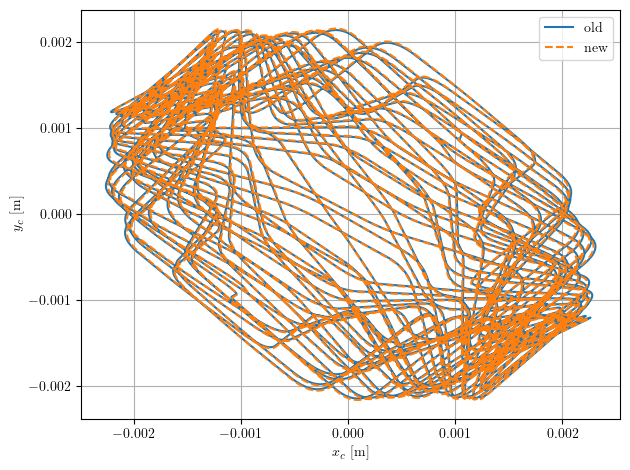

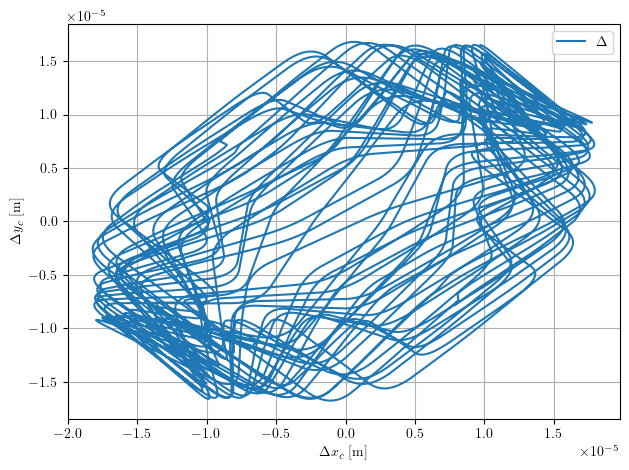

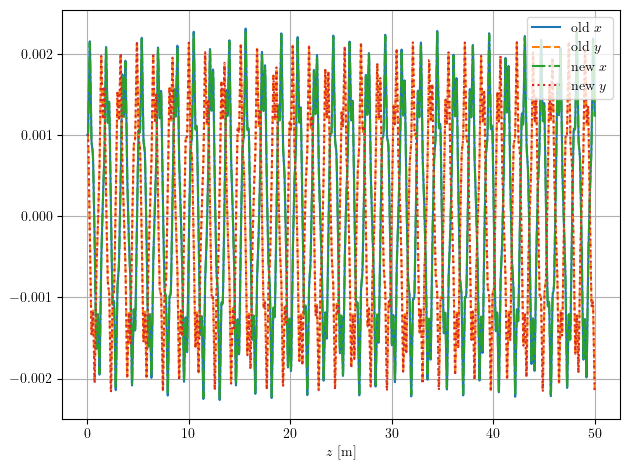

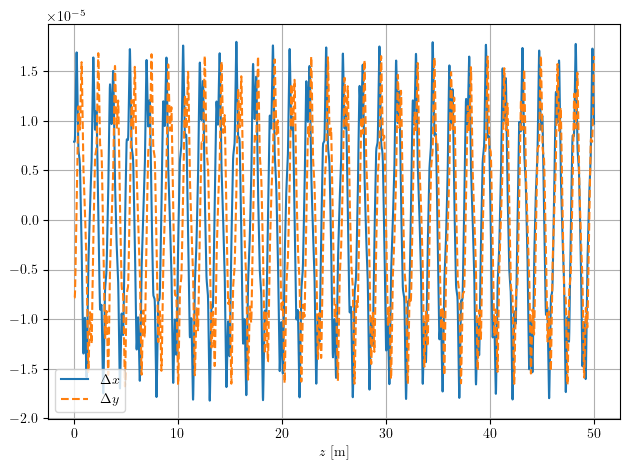

In [105]:
# try a simulation with a slightly different IC and see what occurs
# load in the data
pos_turns = np.loadtxt("pos_turns.txt")
pos_diffset = np.loadtxt("pos_diffset.txt")

zidx = 10000; xidx = 1; yidx = 2

# plot the things
plt.figure()
plt.plot(pos_turns[:zidx,xidx],pos_turns[:zidx,yidx],'-',ms=ms_size,label=r'old')
plt.plot(pos_diffset[:zidx,xidx],pos_diffset[:zidx,yidx],'--',ms=ms_size,label=r'new')
# plt.plot(err[:zidx,xidx],err[:zidx,yidx],'-.',label=r'Error')
plt.xlabel(r"$x_c$ [m]")#,fontsize=label_size)
plt.ylabel(r"$y_c$ [m]")#,fontsize=label_size)
plt.tick_params(axis = 'both')#, labelsize=tick_size)
plt.legend(loc='best')#,fontsize=leg_size)
plt.tight_layout()
plt.grid(True)
plt.tight_layout()
plt.show()

# plot the things
plt.figure()
plt.plot(pos_turns[:zidx,xidx] - pos_diffset[:zidx,xidx],pos_turns[:zidx,yidx]-pos_diffset[:zidx,yidx],'-',ms=ms_size,label=r'$\Delta$')
# plt.plot(err[:zidx,xidx],err[:zidx,yidx],'-.',label=r'Error')
plt.xlabel(r"$\Delta x_c$ [m]")#,fontsize=label_size)
plt.ylabel(r"$\Delta y_c$ [m]")#,fontsize=label_size)
plt.tick_params(axis = 'both')#, labelsize=tick_size)
plt.legend(loc='best')#,fontsize=leg_size)
plt.tight_layout()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(pos_turns[:zidx,0],pos_turns[:zidx,xidx],'-',ms=ms_size,label=r'old $x$')
plt.plot(pos_turns[:zidx,0],pos_turns[:zidx,yidx],'--',ms=ms_size,label=r'old $y$')
plt.plot(pos_turns[:zidx,0],pos_diffset[:zidx,xidx],'-.',ms=ms_size,label=r'new $x$')
plt.plot(pos_turns[:zidx,0],pos_diffset[:zidx,yidx],':',ms=ms_size,label=r'new $y$')
# plt.plot(err[:zidx,xidx],err[:zidx,yidx],'-.',label=r'Error')
plt.xlabel(r"$z$ [m]")#,fontsize=label_size)
# plt.ylabel(r"$$ [m]")#,fontsize=label_size)
plt.tick_params(axis = 'both')#, labelsize=tick_size)
plt.legend(loc='best')#,fontsize=leg_size)
plt.tight_layout()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(pos_turns[:zidx,0],pos_turns[:zidx,xidx]-pos_diffset[:zidx,xidx],'-',ms=ms_size,label=r'$\Delta x$')
plt.plot(pos_turns[:zidx,0],pos_turns[:zidx,yidx]-pos_diffset[:zidx,yidx],'--',ms=ms_size,label=r'$\Delta y$')
# plt.plot(pos_turns[:zidx,0],pos_turns[:zidx,xidx]-pos_diffset[:zidx,xidx],'-',ms=ms_size,label=r'$\Delta x$')
# plt.plot(pos_turns[:zidx,0],pos_turns[:zidx,yidx]-pos_diffset[:zidx,yidx],'-',ms=ms_size,label=r'$\Delta y$')
# plt.plot(err[:zidx,xidx],err[:zidx,yidx],'-.',label=r'Error')
plt.xlabel(r"$z$ [m]")#,fontsize=label_size)
# plt.ylabel(r"$\Delta y_c$ [m]")#,fontsize=label_size)
plt.tick_params(axis = 'both')#, labelsize=tick_size)
plt.legend(loc='best')#,fontsize=leg_size)
plt.tight_layout()
plt.grid(True)
plt.tight_layout()
plt.show()

(11525,)
(11525,)


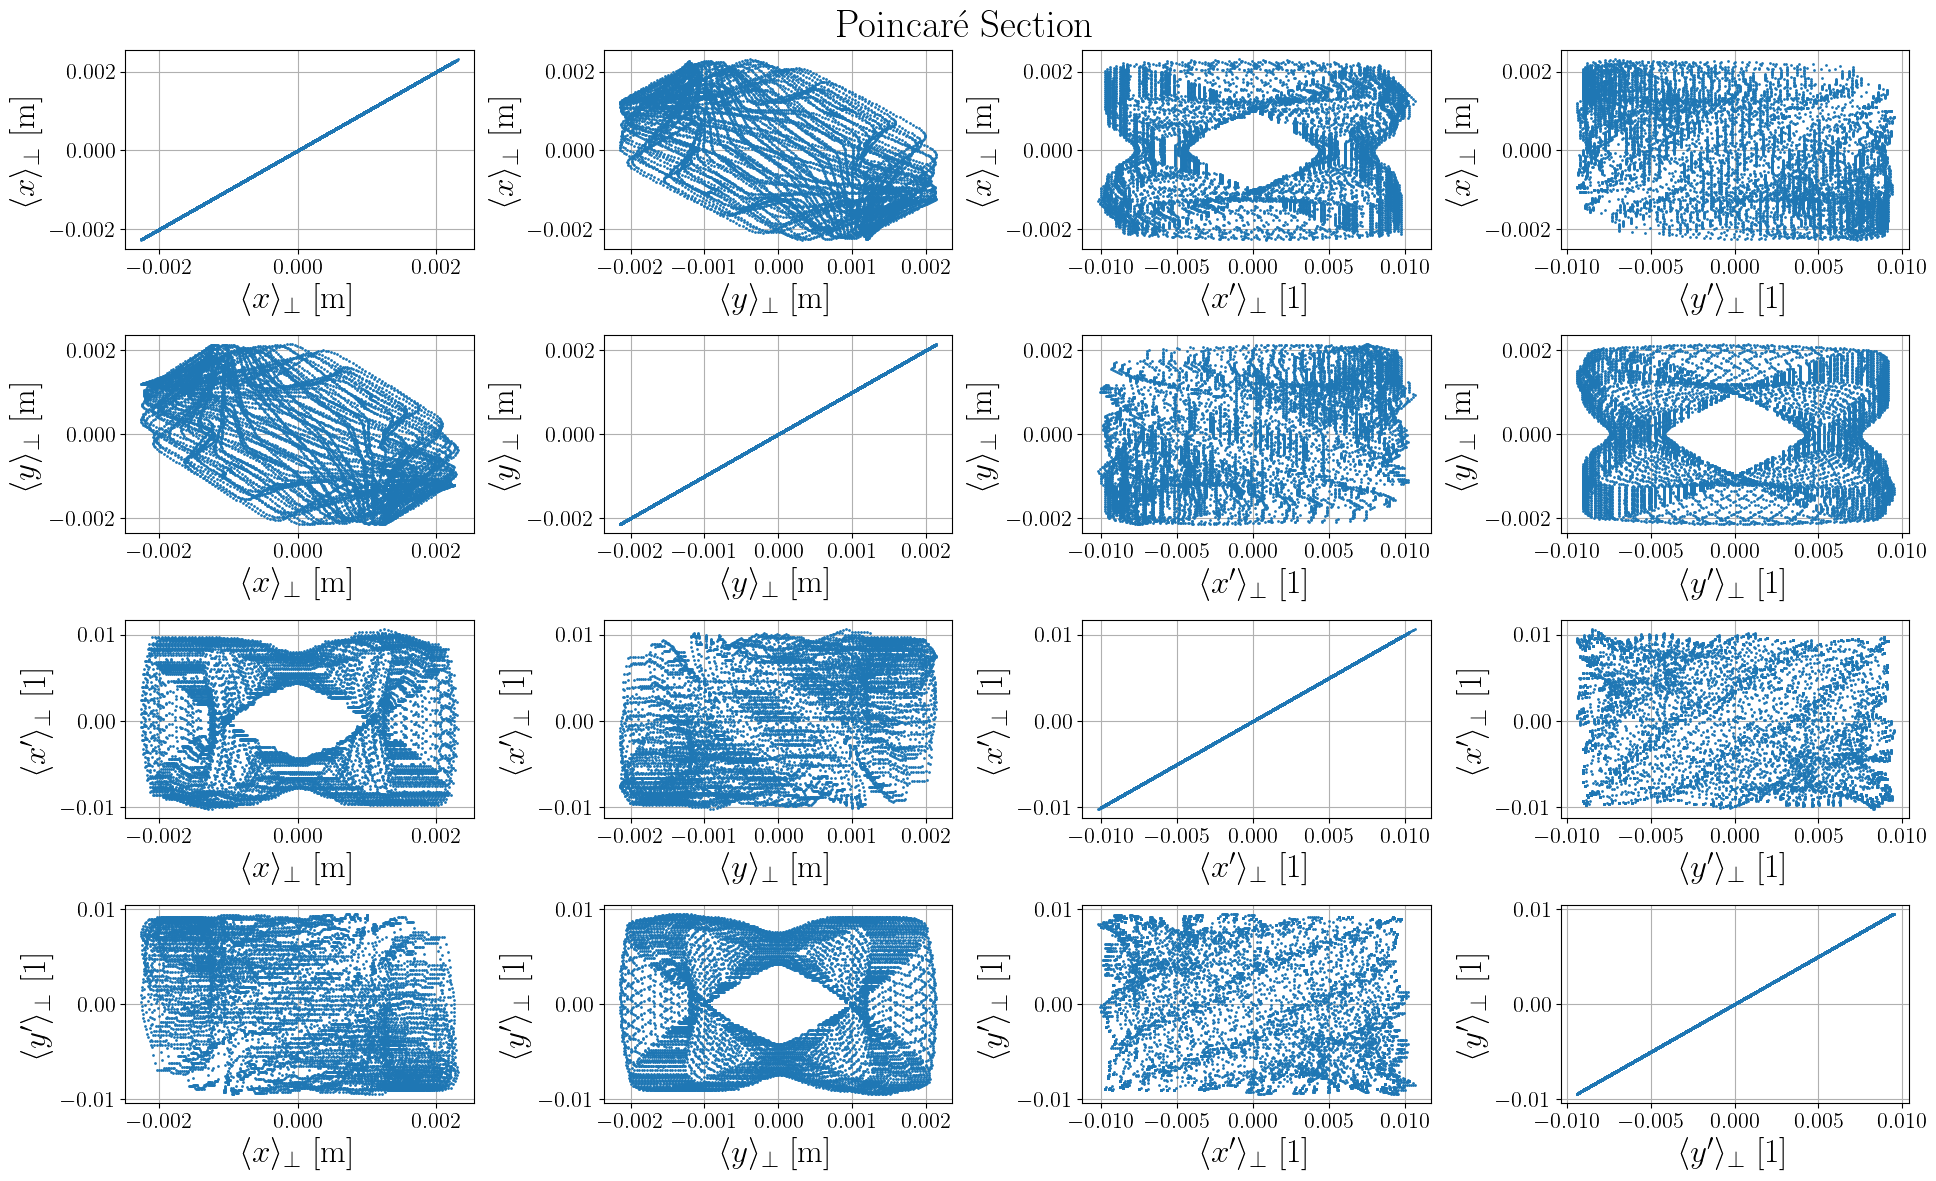

In [106]:
from pysindy.differentiation import FiniteDifference
from pysindy.differentiation import SmoothedFiniteDifference
fd = FiniteDifference(order=2)

# plot plot
z = pos_turns[:,0]
x_c = pos_turns[:,1]
y_c = pos_turns[:,2]

x_c10 = uniform_filter1d(x_c,size=10,axis=0,mode='nearest')
y_c10 = uniform_filter1d(y_c,size=10,axis=0,mode='nearest')

print(z.shape)
print(x_c10.shape)

x_c10p = (x_c[1:-4] - x_c[:-5])/(z[1]-z[0])
y_c10p = (y_c[1:-4] - y_c[:-5])/(z[1]-z[0])

XY = np.array([x_c[:-5],y_c[:-5],x_c10p,y_c10p]).T
XY.shape

labelstr = [r"$\langle x \rangle_{\perp}$ [m]",r"$\langle y \rangle_{\perp}$ [m]",r"$\langle x' \rangle_{\perp}$ [1]",r"$\langle y' \rangle_{\perp}$ [1]"]

dim = 4
fig, axs = plt.subplots(dim,dim,figsize=(12*GR,12))

for i in range(dim):
    for j in range(dim):
        
        axs[i,j].plot(XY[:,j],XY[:,i],'o',markersize=1.0)
        axs[i,j].set_xlabel(labelstr[j],fontsize=label_size)
        axs[i,j].set_ylabel(labelstr[i],fontsize=label_size)
        axs[i,j].tick_params(axis = 'both', labelsize=tick_size)
        axs[i,j].grid(True)

plt.suptitle(r"Poincar\'e Section",fontsize=title_size)
plt.tight_layout()
plt.show()

This system does not have Chaos. It's just quasiperiodic motion.